# How Much Should I Pay For My Bottle of Wine?
With wine being such a widely diverse universe with so many different regions of origin, styles and flavour profiles, is it possible to teach a computer to identify features which could give us an indication of a wine's expected price? Being an industry steeped in millenia of tradition, we would likely expect some of the premier appellations around the world to dominate, but whether that assessment will stand up to analytical muster - and which hidden gems might give you more bang for your buck - is the goal of our investigation.

By carrying out a web-scraping exercise on the [Wine Enthusiast](https://www.winemag.com/?s=&drink_type=wine&page=1&search_type=reviews) website we aim to investigate which characteristics are good indicators of a wine's price, both by its objective qualities as well as the subjective views from professional wine experts' own descriptions of flavour and aroma profiles.

## Table of Contents
1. **Web-scraping**<br>
    1.1 Web-scraping code<br>
    1.2 BeautifulSoup Functions for Data Extraction & Formatting<br>
    1.3 Function to Collate & Convert Data to DataFrame<br>
    1.4 Extracting Vintage Year From Title<br><br>
2. **Exploratory Data Analysis**<br>
    2.1 Data Dictionary<br>
    2.2 Data Cleaning<br>
    2.3 Wine Quality Investigation<br>
    2.4 Wine Price Investigation<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4.1 Investigation Into Trends in Quantitative Features vs. Wine Prices<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4.2 Investigation Into Trends in Categorical Features vs. Wine Prices<br><br>
3. **Modelling**<br>
    3.1 Regression Analysis of Quantitative Fields<br>
    3.2 Incorporating Categorical Features<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3.2.1 Additional Data Preparation<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3.2.2 Linear Regression<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3.2.3 Stochastic Gradient Descent Regression<br>
    3.3 Model Evaluation<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3.3.1 Calculating Confidence Intervals of Parameter Estimates<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3.3.2 Coefficient Analysis<br>
    &nbsp;&nbsp;&nbsp;&nbsp;3.3.3 Residual Plot<br><br>
4. **Further Areas of Study**<br>
    4.1 Feature Engineering<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.1.1 Polynomial Feature Investigation<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.1.2 Fitting an Exponential Model of Rating vs. Price<br>
    4.2 Natural Language Processing<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.2.1 Count Vectorizer<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.2.2 Term Frequency - Inverse Document Frequency (TF-IDF)<br>

In [1]:
import numpy as np
import pandas as pd
import time
import joblib
from time import sleep
from tqdm import tqdm

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Web-scraping
import requests
from bs4 import BeautifulSoup

# Feature Extraction & EDA
import scipy
import re
from statsmodels.graphics.gofplots import qqplot

# Modelling
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from wordcloud import WordCloud
import nltk

# Dimensionality reduction
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_component_variance
from mca import MCA

# Feature Engineering
from scipy.optimize import curve_fit

# Configure for retina display
%config InlineBackend.figure_format = 'retina'

# 1. Web-scraping
### 1.1 Web-scraping code
To source the data for this project, first we needed to collate information about a large number of wines, which we sought via web-scraping utilising the requests and BeautifulSoup python packages.

```python
# Open file to store raw HTML scrape in append mode
f = open("wine_pages.md","a")

# Specify headers to use when querying the site - default other than User-Agent
headers = {'User-Agent':"Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) AppleWebKit/537.36 "
                        "(KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36",
           'Accept-Encoding':'gzip, deflate',
           'Accept':'*/*',
           'Connection':'keep-alive'}

# List of reviews
for page_no in range(1,2500):
    URL = f"https://www.winemag.com/?s=&drink_type=wine&page={page_no}&sort_by=pub_date_web&sort_dir=desc&search_type=reviews"
    r = requests.get(URL,headers=headers)
    sleep(15) # Pause after initial request
    page = BeautifulSoup(r.text,"html.parser")
    
    # Get individual links for each wine review (20 listed per page) using BeautifulSoup querying
    # wine_cards is a list of the relevant tags, including a link to the full review page
    wine_cards = page.find_all("li",class_="review-item")
    
    # Cycle through the review links collected and write to file
    for idx,wine_card in enumerate(wine_cards):
        try:
            # Extract the URL for the individual review page
            review_URL = wine_card.find_next("a",class_="review-listing row").attrs["href"]
            # Scrape the information from the site
            r_review = requests.get(review_URL,headers=headers)
            # Print an output for ease of ongoing monitoring
            print(f"Page {int(page_no)} | Response {r_review.status_code} | Card {idx+1} | URL {review_URL}")
            f.write(r_review.text)
            # This string added simply to ensure easy splitting later on
            f.write("SPLIT_HERE_SPLIT_HERE_SPLIT_HERE")
            sleep(10)
        except:
            # An escape clause in case of unstable connections
            print("Connection fault - pausing for 2 minutes to reset")
            sleep(120)

f.close()
```

Example output:

`Page 1923 | Response 200 | Card 6 | URL https://www.winemag.com/buying-guide/balbas-2014-ritus-ribera-del-duero/`<br>
`Page 1923 | Response 200 | Card 7 | URL https://www.winemag.com/buying-guide/legon-2014-reserva-ribera-del-duero/`<br>
`Page 1923 | Response 200 | Card 8 | URL https://www.winemag.com/buying-guide/zotovich-2017-grenache-sta-rita-hills/`<br>
`...`

### 1.1 Initial Parsing of Individual Reviews
Once the raw text files with all the HTML information had been collected, this needs to be queried using BeautifulSoup to extract the relevant features of the wine listed on each page.

```python
f = open("wine_pages.md","r")

whole_doc = f.read()
all_pages = whole_doc.split("SPLIT_HERE_SPLIT_HERE_SPLIT_HERE") # The string from the scraping code
```

### 1.2 BeautifulSoup Functions for Data Extraction & Formatting
It made the most sense to extract the title and review/reviewer separately, whereas the the primary and secondary attributes were already given in list formats within the HTML structure on each page and therefore could be extracted at the same time.

These functions were designed to be used iteratively on each individual result in the `all_pages` list.

```python
def fetch_title(result):
    """
    Function to extract wine title from HTML.
    
    Takes a single web-page as input
    Returns a dictionary with the field as key
    """
    page = BeautifulSoup(result,"html.parser")
    try:
        return {'title': page.find("div",class_="header__title").find("h1").text.strip()}
    # Escape clause in case of bounced requests, captcha pages, etc.
    except:
        return {'title': np.nan}
    
def fetch_review(result):
    """
    Function to extract review & reviewer from HTML
    
    Takes a single web-page as input
    Returns a dictionary with the fields as keys
    """
    page = BeautifulSoup(result,"html.parser")
    try:
        # As the name of the reviewer was at the end of each review, these
        # elements can be returned together, although the name was removed
        # from each wine's review using a simple .replace() function.
        name = page.find("p",class_="description").find("span").text
        return {'review'   : page.find("p",class_="description").text.replace(name,"").strip(),
                'reviewer' : name}
    # Escape clause in case of bounced requests, captcha pages, etc.
    except:
        return {'review'   : np.nan,
                'reviewer' : np.nan}
    
def fetch_primary_attributes(result):
    """
    Function to extract primary wine attributes from HTML
    
    Takes a single web-page as input
    Returns a dictionary with the fields as keys
    """
    page = BeautifulSoup(result,"html.parser")
    # As not all pages have info for every attribute, start with np.nan to avoid empty cells
    attributes  = {'rating'      : np.nan,
                   'price'       : np.nan,
                   'designation' : np.nan,
                   'variety'     : np.nan,
                   'country'     : np.nan,
                   'appellation' : np.nan,
                   'sub_region1' : np.nan,
                   'sub_region2' : np.nan,
                   'winery'      : np.nan}
    try:
        # Generate the list of attributes as named on the website itself to construct the dict
        raw_list = page.find("ul",class_="primary-info").find_all("li")
        for entry in raw_list:
            # Limit the iterator to the first two "span" HTML tags; the attribute name and its value
            attrib_list = [field.text for idx,field in zip(range(2),entry.find_all("span"))]
            # The 0th entry is used to reference into the attributes dictionary, the 1st is its value
            attributes[attrib_list[0].lower()] = attrib_list[1]

        # Now we have our raw data, we need to do some formatting and cleaning
        try:
            # The prices have a comma after the value and a USD currency symbol in front
            # Slicing from after the 1st character removes the symbol and then cast as int
            attributes['price'] = int(attributes['price'].split(",")[0][1:])
        except:
            attributes['price'] = np.nan
            
        try:
            # Cast rating string as int
            attributes['rating'] = int(attributes['rating'])
        except:
            attributes['rating'] = np.nan
            
        # The appellation field can be deconstructed into country and sub-region(s)
        # Negative sub-scripting is used as the format on the site starts at the smallest
        # region and then largest (i.e. country) last & not all wines have multiple sub-
        # regions specified.
        try:
            attributes['country'] = attributes['appellation'].split(",")[-1].strip()
        except:
            attributes['country'] = np.nan
        try:
            attributes['sub_region1'] = attributes['appellation'].split(",")[-3].strip()
        except:
            attributes['sub_region1'] = np.nan
        try:
            attributes['sub_region2'] = attributes['appellation'].split(",")[-4].strip()
        except:
            attributes['sub_region2'] = np.nan
            
        # Appellation is handled last as it removes the sub-regions when executed
        try:
            attributes['appellation'] = attributes['appellation'].split(",")[-2].strip()
        except:
            attributes['appellation'] = np.nan

        return attributes
    # Escape clause in case of bounced requests, captcha pages, etc.
    except:
        return attributes
    
def fetch_secondary_attributes(result):
    """
    Function to extract secondary attributes from HTML
    
    Takes a single web-page as input
    Returns a dictionary with the fields as keys
    """
    page = BeautifulSoup(result,"html.parser")
    # As not all pages have info for every attribute, start with np.nan to avoid empty cells
    attributes  = {'alcohol'         : np.nan,
                   'bottle size'     : np.nan,
                   'category'        : np.nan,
                   'importer'        : np.nan,
                   'date published'  : np.nan,
                   'user avg rating' : np.nan}
    try:
        # Generate the list of attributes as named on the website itself for the dictionary
        raw_list = page.find("ul",class_="secondary-info").find_all("li")
        for entry in raw_list:
            # Limit the iterator to the first two "span" HTML tags; the attribute name and its value
            attrib_list = [field.text for idx,field in zip(range(2),entry.find_all("span"))]
            attributes[attrib_list[0].lower()] = attrib_list[1]

        # Now we have our raw data, we need to do some formatting and cleaning
        try:
            # Cast alcohol as float value, slicing away the trailing % character
            attributes['alcohol'] = float(attributes['alcohol'][:-1])/100.
        except:
            attributes['alcohol'] = np.nan

        try:
            # Some bottles were listed in litres, some in millilitres
            if 'L' in attributes['bottle size']:
                attributes['bottle size'] = int(eval(attributes['bottle size'].replace("L",""))*1000)
            elif 'ml' in attributes['bottle size']:
                attributes['bottle size'] = int(eval(attributes['bottle size'].replace("ml","")))
        except:
            attributes['bottle size'] = np.nan

        try:
            # Cast pulishing date as pandas datetime format
            attributes['date published'] = pd.to_datetime(attributes['date published'])
        except:
            attributes['date published'] = np.nan

        return attributes
    
    # Escape clause in case of bounced requests, captcha pages, etc.
    except:
        return attributes
```

### 1.3 Function to Collate & Convert Data to DataFrame
Now we have our individual working functions to extract different features within the page, we can build an all-encompassing function which will stitch all these elements together into a DataFrame.

```python
def fetch_all(result,idx):
    """
    Function to fetch all wine data from HTML
    
    Dependent on:
    - fetch_title(),
    - fetch_review(),
    - fetch_reviewer(),
    - fetch_primary_attributes() &
    - fetch_secondary_attributes()
    
    Takes a single web-page and index as inputs
    Returns an indexed Pandas DataFrame
    """
    all_data = {}
    title = fetch_title(result)
    review = fetch_review(result)
    reviewer = fetch_reviewer(result)
    prim_attribs = fetch_primary_attributes(result)
    sec_attribs = fetch_secondary_attributes(result)
    
    # Join all the dictionaries together
    all_data.update(title)
    all_data.update(review)
    all_data.update(reviewer)
    all_data.update(prim_attribs)
    all_data.update(sec_attribs)
    
    return pd.DataFrame(all_data,index=[idx])
```

We then need to concatenate each individual DataFrame (named `wine` below) to get our full dataset and remove erroneous entries for when the scraper crashed, blocked attempts, captcha etc. We also emplyed the tqdm package in order to be able to track this process as it was extracting, collating and then concatenating the data from the raw HTML files.

As all the wines clearly should have a title, this is the best column to perform the `.dropna()` function upon to filter out such erroneous instances. As mentioned earlier, certain other attributes were not included for all wines.

```python
wine = pd.concat([fetch_all(result=page,idx=idx) for idx,page in tqdm(enumerate(all_pages))])

wine.drop(wine[wine['title'].isna()].index,inplace=True)
```

### 1.4 Extracting Vintage Year From Title
Using a very simple RegEx we can extract the 4-digit long vintage from each wine's title.

```python
def extract_vintage(title):
    """
    Function to filter vintages from titles using RegEx and
    a series of logical statements.
    
    Takes a the title as a string as input
    Returns the vintage year, NV (if non-vintage) or N/A if
    no year is specified
    """
    year = re.findall("\d{4}",title)
    # For Non-Vintage (NV) wines (NV Cava, NV Champagne, etc.)
    if " NV " in title:
        return "NV"
    # If only one 4-digit number found, return
    elif len(year) == 1:
        return int(year[0])
    # If >1 4-digit number found (e.g. name of winery includes founding year),
    # apply quick logic to take the closest to current year as that will be
    # the vintage of the wine drank; a wine cannot be made before a winery has
    # even been founded!
    elif len(year) > 1:
        # Calculate the distance of each 4-digit value from the current year
        diff = [abs(int(i)-2021) for i in year]
        # Index into the list at the location of the minimum value
        return int(year[diff.index(min(diff))])
    else:
        return np.nan
    
wine['vintage'] = wine['title'].apply(extract_vintage)
```

Now that we have the vintages of the wines, and the dates that they were reviwed, we can make a simple calculation to also get an approximate age of the wines when they were drank.

```python
# First create a boolean mask for NV wines, which we will use later as well
NV_mask = wine['vintage']=="NV"

# Apply the ~ (NOT) boolean pandas filter rule using the NV mask, and subtracting the vintage year
# This should give us an approximate age of the wine when it was reviewed
wine['age_when_drank'] = wine['date published'][~NV_mask].apply(lambda x: x.year) - wine['vintage'][~NV_mask]
```

This data was then written to a CSV file using the `.to_csv()` function to make it easier to recall the data, as well as greatly reducing disk space compared to the raw HTML text files (from a few GB down to ~25MB).

```python
wine.drop_duplicates(keep="first").to_csv("wine_data.csv")
```

# 2. Exploratory Data Analysis
Now that we have our dataset, we can begin our exploratory data analysis (EDA) to get build a better understanding of what we will be working with.

In [2]:
wine = pd.read_csv("assets/wine_data.csv",index_col="Unnamed: 0")

# Try to cast int dtypes on appropriate columns
wine['rating'] = wine['rating'].astype(int,errors='ignore')
wine['price'] = wine['price'].astype(int,errors='ignore') # Fails due to NaN values
wine['bottle size'] = wine['bottle size'].astype(int,errors='ignore')
wine['age_when_drank'] = wine['age_when_drank'].astype(int,errors='ignore') # Fails due to NaN values
wine['vintage'] = wine['vintage'].astype(str,errors='ignore') # Ensure categorical treatment

# Recover the NV_mask mentioned earlier from the web-scraping code
NV_mask = wine['vintage']=="NV"

print(wine.shape)

(47674, 20)


Now that the data has been collated using the website's headings, we can fill blank spaces simply for ease of use within python for the remainder of our analysis.

In [3]:
new_column_headings = [heading.replace(" ","_") for heading in wine.columns]

wine.columns = new_column_headings

print(wine.columns)

Index(['title', 'review', 'reviewer', 'rating', 'price', 'designation',
       'variety', 'country', 'appellation', 'sub_region1', 'sub_region2',
       'winery', 'alcohol', 'bottle_size', 'category', 'importer',
       'date_published', 'user_avg_rating', 'vintage', 'age_when_drank'],
      dtype='object')


### 2.1 Data Dictionary

|Feature|Description|
|---|---|
|<b>title</b>|The name of the wine|
|<b>review</b>|The subjective description of the profile of the wine|
|<b>reviewer</b>|The name of the professional reviewer who tasted the wine|
|<b>rating</b>|A points system indicating the quality of the wine|
|<b>price</b>|The price of the wine in US\$|
|<b>designation</b>|The particular brand of the wine, where applicable|
|<b>variety</b>|The grape varities, blends or styles of the wine, as appropriate for the given wine|
|<b>country</b>|The country of origin|
|<b>appellation</b>|The region in which the wine was made|
|<b>sub_region1</b>|A second, more granular region in which the wine was made (where applicable)|
|<b>sub_region2</b>|A third, more granular region in which the wine was made (where applicable)|
|<b>winery</b>|The winemaker|
|<b>alcohol</b>|The fraction of the wine's alcohol by volume|
|<b>bottle_size</b>|The size of the wine bottle reviewed (ml)|
|<b>category</b>|The style of the wine (red, white, rose, sparkling etc.)|
|<b>importer</b>|The importing merchant of the wine (where applicable)|
|<b>date_published</b>|The date the review was published|
|<b>user_avg_rating</b>|The average user-submitted rating of the wine|
|<b>vintage</b>|The year in which the grapes were harvested|
|<b>age_when_drank</b>|The approximate age of the wine when it was reviewed|

### 2.2 Data Cleaning

In [4]:
wine.describe()

,rating,price,alcohol,bottle_size,age_when_drank
count,47674.000000,45065.000000,47191.000000,47674.000000,45917.000000
mean,89.855162,41.785998,0.138927,750.974221,2.839449
std,2.939931,65.214285,0.282059,81.247384,1.958263
min,80.000000,3.000000,0.005000,200.000000,0.000000
25%,88.000000,20.000000,0.130000,750.000000,2.000000
50%,90.000000,30.000000,0.135000,750.000000,3.000000
75%,92.000000,50.000000,0.145000,750.000000,3.000000
max,100.000000,8500.000000,54.800000,3000.000000,100.000000


A quick inspection of the numerical fields of our data would suggest some potential problems. Firstly, while 75% of our data falls at or below \\$50 a bottle, there are significantly more expensive wines in the dataset up to a max of \\$8,500.

Next, the age of the wine when it was drank could also potentially be an issue given that the majority of wines appear to have been drunk young, but there are some (very) old wines also included all the way up to 100 years old.

Finally, the alcoholic content of wines seems to have some problems, given the min and max values suggesting nearly entirely non-alcoholic wine and values outside of the domain of the variable (between 0.0 and 1.0).

In [5]:
wine[wine['alcohol']>0.30].head(5)

,title,review,reviewer,rating,price,designation,variety,country,appellation,sub_region1,sub_region2,winery,alcohol,bottle_size,category,importer,date_published,user_avg_rating,vintage,age_when_drank
2400,Château Bessan Ségur 2016 Cru Bourgeois (Médoc),"Ripe and smoky, this wine is just approaching ...",Roger Voss,90,17.0,Cru Bourgeois,Bordeaux-style Red Blend,France,Bordeaux,Médoc,NaN,Château Bessan Ségur,1.25,750,Red,Black Hawk Imports,2021-04-01,Not rated yet [Add Your Review],2016,5.0
2429,Château du Seuil 2019 Graves,"This well-structured, wood-aged wine is poised...",Roger Voss,90,19.0,NaN,Bordeaux-style White Blend,France,Bordeaux,Graves,NaN,Château du Seuil,1.25,750,White,DB Wine Selection,2021-04-01,Not rated yet [Add Your Review],2019,2.0
3281,Domaine le Clos du Caillou 2017 La Réserve Red...,Penetrating streaks of blackberry jam and fig ...,Anna Lee C. Iijima,97,140.0,La Réserve,Rhône-style Red Blend,France,Rhône Valley,Châteauneuf-du-Pape,NaN,Domaine le Clos du Caillou,1.40,750,Red,Dionysos Imports Inc,2021-03-01,Not rated yet [Add Your Review],2017,4.0
3739,Domaine Moulin-Tacussel 2017 Red (Châteauneuf-...,This producer's 2017 tradition cuvée is deligh...,Anna Lee C. Iijima,94,50.0,NaN,Rhône-style Red Blend,France,Rhône Valley,Châteauneuf-du-Pape,NaN,Domaine Moulin-Tacussel,0.94,750,Red,Alain Junguenet Selection,2021-03-01,Not rated yet [Add Your Review],2017,4.0
6206,Château La Tuilière 2018 Tradition (Côtes de ...,"This ripe, full and juicy blend of 65% Merlot ...",Roger Voss,88,26.0,Tradition,Bordeaux-style Red Blend,France,Bordeaux,Côtes de Bourg,NaN,Château La Tuilière,0.88,750,Red,"Frederick Wildman & Sons, Ltd",2021-03-01,Not rated yet [Add Your Review],2018,3.0


After examining a number of these wines it would appear that they all have erroneous data that was entered onto the website; some have the same ABV as bottle size (e.g. 750%), some have numbers that are the same as the rating (e.g. row `3739` above was awarded 94 points and also a 94% ABV), and others it appears to be a case of the number being recorded an order of magnitude too high.

In other cases at the other extreme of the spectrum we can examine the very low ABV wines.

In [6]:
wine[wine['alcohol']<0.05].head(5)

,title,review,reviewer,rating,price,designation,variety,country,appellation,sub_region1,sub_region2,winery,alcohol,bottle_size,category,importer,date_published,user_avg_rating,vintage,age_when_drank
2939,Quady 2019 Electra Moscato (California),Effusive floral and honey aromas meet ripe and...,Jim Gordon,88,16.0,Electra,"Moscato, Muscat",US,California,California Other,California,Quady,0.045,750,Dessert,NaN,2021-04-01,Not rated yet [Add Your Review],2019,2.0
3464,Bernhard Ott 2016 Ried Stein Grüner Veltliner ...,"A touch of flint and fresh, white field mushro...",Anne Krebiehl MW,95,65.0,Ried Stein,Grüner Veltliner,Austria,Kamptal,NaN,NaN,Bernhard Ott,0.020,750,White,"Skurnik Wines, Inc",2021-03-01,Not rated yet [Add Your Review],2016,5.0
6876,Giesen 2020 0% Dealcoholized Sauvignon Blanc (...,The nose offers straightforward notes of yeast...,Christina Pickard,83,15.0,0% Dealcoholized,Sauvignon Blanc,New Zealand,Marlborough,NaN,NaN,Giesen,0.005,750,White,Pacific Highway Wines & Spirits,2021-03-01,Not rated yet [Add Your Review],2020,1.0
15855,Gustave Lorentz 2019 Réserve Gewurztraminer (A...,"In this wine, notes of ripe melon have overton...",Anne Krebiehl MW,89,28.0,Réserve,"Gewürztraminer, Gewürztraminer",France,Alsace,Alsace,NaN,Gustave Lorentz,0.012,750,White,Quintessential Wines,2020-10-01,Not rated yet [Add Your Review],2019,1.0
29591,Electra 2018 Electra Moscato (California),"This rosé wine is very floral in aroma, very s...",Jim Gordon,89,16.0,Electra,"Moscato, Muscat",US,California,California Other,California,Electra,0.045,750,Dessert,NaN,2020-03-01,Not rated yet [Add Your Review],2018,2.0


As we can see from the above, there is a variety of different cases present. There are dessert wines which naturally have low ABV, wines that have purposefully been made as non- or low-ABV, and also some wines with erroneous data entered on the website from a quick comparison to alternate sources.

Given the difficulty in delineating between all of the different problematic cases within the ABV field, the easiest solution at present is to drop it as a feature from our data; if we don't have confidence in the data within the feature then its predictive power is also undermined.

In [7]:
wine.drop('alcohol',axis=1,inplace=True)

We can also investigate the diversity of the fields we are working with; while we expect the reviews and wines themselves to differ, features such as country of origin or categories of wine will naturally have some degree of repetition.

In [8]:
unique_values = pd.DataFrame(wine.columns,columns=["Feature"])
unique_values['Unique Values'] = [len(wine[col].unique()) for col in wine.columns]
unique_values['Non-Null Entries'] = [wine[col].notna().sum() for col in wine.columns]
unique_values

,Feature,Unique Values,Non-Null Entries
0,title,47377,47674
1,review,47655,47674
2,reviewer,18,47674
3,rating,21,47674
4,price,304,45065
5,designation,20416,35444
6,variety,592,47674
7,country,37,47674
8,appellation,310,47668
9,sub_region1,721,40865


In [9]:
wine['user_avg_rating'].unique()

array(['Not rated yet [Add Your Review]'], dtype=object)

The above shows that the `user_avg_rating` appears to be a field that the site itself perhaps has not yet fully developed, so we have removed it from the dataset.

In [10]:
wine.drop(columns='user_avg_rating',inplace=True)

##### Different wines, but repeated titles or reviews?

Interestingly, it would also appear that some of the wine titles and reviews, which intuitively should all be unique, have some duplicates in the dataset which we will need to investigate further.

##### Duplicated Reviews
Let's begin by looking into the duplicated reviews to try and understand how this can be the case for what should be different wines, if our `.drop_duplicates()` has worked properly, based on the data we have managed to scrape.

In [11]:
wine[wine.duplicated('review',keep=False)].sort_values('review').shape

(38, 18)

In [12]:
wine[wine.duplicated('review',keep=False)].sort_values('review').head(6)

,title,review,reviewer,rating,price,designation,variety,country,appellation,sub_region1,sub_region2,winery,bottle_size,category,importer,date_published,vintage,age_when_drank
47052,Poggio al Tesoro 2018 Rosato Red (Bolgheri),A blend of 70% Sangiovese and 30% Cabernet Sau...,Kerin O’Keefe,89,NaN,Rosato,"Red Blends, Red Blends",Italy,Tuscany,Bolgheri,NaN,Poggio al Tesoro,750,Rose,LUX Wines,2019-07-01,2018,1.0
46799,Castello di Bossi 2018 Rosato (Toscana),A blend of 70% Sangiovese and 30% Cabernet Sau...,Kerin O’Keefe,90,20.0,NaN,"Rosato, Rosé",Italy,Tuscany,Toscana,NaN,Castello di Bossi,750,Rose,LLS–Winebow,2019-07-01,2018,1.0
34464,Palato do Côa 2018 Palato Colheita White (Douro),"A creamy, fruity wine that balances ripe white...",Roger Voss,88,18.0,Palato Colheita,Portuguese White,Portugal,Douro,NaN,NaN,Palato do Côa,750,White,Cohen Siderow Wine Imports LLC,2019-12-31,2018,1.0
34641,Palato do Côa 2018 Vinhas do Côa Branco White ...,"A creamy, fruity wine that balances ripe white...",Roger Voss,88,18.0,Vinhas do Côa Branco,Portuguese White,Portugal,Douro,NaN,NaN,Palato do Côa,750,White,Cohen Siderow Wine Imports LLC,2019-12-31,2018,1.0
43268,Türk 2018 Kremser Weinberge Grüner Veltliner (...,A slight overtone of ripe mango hovers on the ...,Anne Krebiehl MW,90,17.0,Kremser Weinberge,Grüner Veltliner,Austria,Niederösterreich,NaN,NaN,Türk,750,White,Balanced Wine Selections LLC,2019-09-01,2018,1.0
43021,Weingut Frank 2017 Ried Hoher Weg Reserve Grün...,A slight overtone of ripe mango hovers on the ...,Anne Krebiehl MW,90,47.0,Ried Hoher Weg Reserve,Grüner Veltliner,Austria,Weinviertel,NaN,NaN,Weingut Frank,750,White,August Wine Group,2019-09-01,2017,2.0


From the above entries we can see a couple of different cases which explain what has gone wrong for these observations. The entries at index `34464` and `34641` (3rd and 4th in the table above) are indeed the same wine, but were duplicated on the site aside from a minor difference in the wine's designation, while the top two and bottom two are where the incorrect reviews must have accidentally been uploaded for some wines.

For example, [Palari 2015 Rosso del Soprano Red (Terre Siciliane)](https://www.winemag.com/buying-guide/palari-2015-rosso-del-soprano-red-terre-siciliane/) and [Maschio dei Cavalieri 2018 Rive di Colbertaldo Brut (Valdobbiadene Prosecco Superiore)](https://www.winemag.com/buying-guide/maschio-dei-cavalieri-2018-rive-di-colbertaldo-brut-valdobbiadene-prosecco-superiore/) are clearly different wines, but have the same review. Based on the description, it is clearly the Prosecco which would be the correct entry, but resolving this would require manual cleaning and an opinion to be cast on which is correct, which would naturally be hard to impossible in some cases and time consuming.

Luckily this is only for a small number of entries overall so we can remove these from the dataset without too much concern (less than 0.1% of our overall usable observations with price information).

In [13]:
wine.drop(wine[wine.duplicated('review',keep=False)].index,inplace=True)

##### Duplicated Titles
Next we can look at the duplicated titles to understand what might be the root cause of any repetition within that field.

In [14]:
wine[wine.duplicated('title',keep=False)].sort_values('title').shape

(593, 18)

In [15]:
wine[wine.duplicated('title',keep=False)].sort_values('title').head(4)

,title,review,reviewer,rating,price,designation,variety,country,appellation,sub_region1,sub_region2,winery,bottle_size,category,importer,date_published,vintage,age_when_drank
31653,Alban Roblin 2017 Sancerre,"This smooth, wood-aged wine has ripe tannins t...",Roger Voss,88,16.0,NaN,Pinot Noir,France,Loire Valley,Sancerre,NaN,Alban Roblin,750,Red,Princeton Corkscrew,2020-01-01,2017,3.0
31147,Alban Roblin 2017 Sancerre,"A ripe, full-bodied wine, this is juicy and de...",Roger Voss,90,15.0,NaN,Sauvignon Blanc,France,Loire Valley,Sancerre,NaN,Alban Roblin,750,White,Princeton Corkscrew,2020-01-01,2017,3.0
19510,Albert Bichot 2018 Chassagne-Montrachet,Gentle aromas of cream and yeast on the nose o...,Anne Krebiehl MW,92,103.0,NaN,Chardonnay,France,Burgundy,Chassagne-Montrachet,NaN,Albert Bichot,750,White,Albert Bichot USA,2020-08-01,2018,2.0
10505,Albert Bichot 2018 Chassagne-Montrachet,There almost is a sense of berry candy along w...,Anne Krebiehl MW,91,72.0,NaN,Pinot Noir,France,Burgundy,Chassagne-Montrachet,NaN,Albert Bichot,750,Red,Albert Bichot USA,2020-12-01,2018,2.0


From the above, we can see that some of these duplications come from a wine being named in the usual *\"old-world\"* convention of its appellation of origin, but still being unique wines. The 2 pairs of entries above, for example, are wines from the same appellation (Sancerre and Chassagne-Montrachet, in these cases), but are made from different red and white grape varietals permissable within those regions (i.e. Pinot Noir, Chardonnay and Sauvignon Blanc) and are therefore perfectly fine to leave within the data as unique entries.

However, from  further investigation we can see that this isn't always the case, such as the two examples below.

In [16]:
wine.loc[[41920,35233,5351,29237]]

,title,review,reviewer,rating,price,designation,variety,country,appellation,sub_region1,sub_region2,winery,bottle_size,category,importer,date_published,vintage,age_when_drank
41920,Wilson Creek 2018 Winemaker's Select Riesling ...,"Sour lime flesh, dried lemon peels and chisele...",Matt Kettmann,87,29.0,Winemaker's Select,Riesling,US,California,South Coast,Temecula Valley,Wilson Creek,750,White,NaN,2019-10-01,2018,1.0
35233,Wilson Creek 2018 Winemaker's Select Riesling ...,"Extremely vinous on the nose, this wine smells...",Matt Kettmann,83,29.0,Winemaker's Select,Riesling,US,California,South Coast,Temecula Valley,Wilson Creek,750,White,NaN,2019-12-31,2018,1.0
5351,Zantho 2017 Cuvée 1488 Red (Burgenland),Juicy plumminess on the nose is edged with cin...,Anne Krebiehl MW,90,35.0,Cuvée 1488,"Austrian Red Blend, Red Blends",Austria,Burgenland,NaN,NaN,Zantho,750,Red,Winemonger,2021-03-01,2017,4.0
29237,Zantho 2017 Cuvée 1488 Red (Burgenland),An almost creamy notion of roast hazelnut on t...,Anne Krebiehl MW,91,35.0,Cuvée 1488,"Austrian Red Blend, Red Blends",Austria,Burgenland,NaN,NaN,Zantho,750,Red,Winemonger,2020-03-01,2017,3.0


Here we do have a duplication of wines, but given they were tasted on different dates they would also be permissible, in my view, under the assertion that wines do indeed evolve over time and can change characteristics with age.

On the basis of the two analyses above, we can check for duplicates over multiple fields; the wine varietal (Pinot Noir, Chardonnay etc.) and the date of publication of the review, in addition to its title to delve into whether there really are falsely duplicated entries.

In [17]:
wine[wine.duplicated(['title','variety','date_published'],keep=False)].sort_values('title')

,title,review,reviewer,rating,price,designation,variety,country,appellation,sub_region1,sub_region2,winery,bottle_size,category,importer,date_published,vintage,age_when_drank
26175,Albert Bichot 2018 Domaine de Rochegrès (Moul...,This wine comes from a five-acre vineyard in t...,Roger Voss,94,38.0,Domaine de Rochegrès,Gamay,France,Beaujolais,Moulin-à-Vent,NaN,Albert Bichot,750,Red,Albert Bichot USA,2020-04-01,2018,2.0
26202,Albert Bichot 2018 Domaine de Rochegrès (Moul...,"Property of the Bichot family, this vineyard h...",Roger Voss,93,33.0,Domaine de Rochegrès,Gamay,France,Beaujolais,Moulin-à-Vent,NaN,Albert Bichot,750,Red,Albert Bichot USA,2020-04-01,2018,2.0
7118,Portalupi 2018 Shake Ridge Ranch Barbera (Amad...,"A deft touch of new oak and sumptuous, concent...",Jim Gordon,94,90.0,Shake Ridge Ranch,Barbera,US,California,Sierra Foothills,Amador County,Portalupi,750,Red,NaN,2020-12-31,2018,2.0
8010,Portalupi 2018 Shake Ridge Ranch Barbera (Amad...,"Reduced at first, this full-bodied wine brings...",Jim Gordon,91,45.0,Shake Ridge Ranch,Barbera,US,California,Sierra Foothills,Amador County,Portalupi,750,Red,NaN,2020-12-31,2018,2.0
45646,Porto Réccua NV Branco Dry White (Port),This is a pretty wine with acidity as well as ...,Roger Voss,87,16.0,Branco Dry White,"Port, Port Blend",Portugal,Port,NaN,NaN,Porto Réccua,750,Port/Sherry,Wine Enterprises LLC,2019-08-01,NV,NaN
45648,Porto Réccua NV Branco Dry White (Port),This is a pretty wine with acidity as well as ...,Roger Voss,87,16.0,Branco Dry White,"Port, Port Blend",Portugal,Port,NaN,NaN,Porto Réccua,750,Port/Sherry,Wine Enterprises LLC,2019-08-01,NV,NaN


This (thankfully) narrows down our potential +500 of duplicates down to just six entries, i.e. three wines. The top two pairs interestingly both have unique reviews and scores from the same reviewers - quite peculiar, but when you're responsible for tasting 10,000s of wines perhaps some leniency can be afforded to the reviewers!

Given that the reviews and points given are indeed unique, and that these entries make up such a small overall percentage of the dataset (less than 0.01%), we will retain the entries, given they are ultimately still both valid views and scores of the wines.

The bottom pair are duplicated in every cell except a comma after the word "tangy" in the review itself as the entry is duplicated on the website, so we can simply omit one of these entries.

In [18]:
wine.loc[45646]['review']

'This is a pretty wine with acidity as well as some tangy perfumed fruits. Its concentration, edged with sweet toffee, is intense.'

In [19]:
wine.loc[45648]['review']

'This is a pretty wine with acidity as well as some tangy, perfumed fruits. Its concentration, edged with sweet toffee, is intense.'

In [20]:
wine.drop(45648,axis=0,inplace=True)

##### Wines With Missing Price Information
As we are ultimately trying to build a model to predict how much we should be paying for our bottle of wine, any entries that are missing this information will need to be removed. We can see what % of our overall dataset this would be from the below calculation.

In [21]:
# Simple filter to calculate and return the % of wines with no price within our dataset
print(f"{round(100*wine[wine['price'].isna()].shape[0]/wine.shape[0],2)}%")

5.47%


Given we will still be left with the vast bulk of our data after this removal, we shall go ahead and remove these observations from the data.

In [22]:
wine.drop(wine[wine['price'].isna()].index,axis=0,inplace=True)

While also carrying out the EDA into the price feature, we find one wine whose price was accidentally [entered on the website](https://www.winemag.com/buying-guide/sean-minor-2018-nicole-marie-red-north-coast/) as its vintage, rather than the actual US\\$ price; we can simply remove this entry from our dataset.

In [23]:
# Scan across the dataset using a boolean filter of wines with vintages that are 
# equal to their prices. We subset first onto the non-NV wines and then compare
# the vintage and price columns (ensuring the vintages here are floats)
wine[~NV_mask][(wine['vintage'][~NV_mask].astype(float)==wine['price'][~NV_mask])]

<ipython-input-23-e3d8834a3e88>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wine[~NV_mask][(wine['vintage'][~NV_mask].astype(float)==wine['price'][~NV_mask])]


,title,review,reviewer,rating,price,designation,variety,country,appellation,sub_region1,sub_region2,winery,bottle_size,category,importer,date_published,vintage,age_when_drank
23701,Sean Minor 2018 Nicole Marie Red (North Coast),Vanilla and marshmallow aromas lead to effusiv...,Jim Gordon,86,2018.0,Nicole Marie,"Red Blends, Red Blends",US,California,North Coast,North Coast,Sean Minor,750,Red,NaN,2020-07-01,2018,2.0


In [24]:
wine.drop(23701,axis=0,inplace=True)

### 2.3 Wine Quality Investigation
We can also do some investigation into the distribution of higher and lower quality wines by separating them into different quality classes.

The [site itself](https://www.winemag.com/2010/04/09/you-asked-how-is-a-wines-score-determined/) gives the below classifications of wine qualities, based on their score. Wines scoring lower than 80 are deemed below acceptable quality and are not reviewed.

|Wine Classification|Wine Rating|
|---|---|
|Classic|98–100|
|Superb|94–97|
|Excellent|90–93|
|Very Good|87–89|
|Good|83–86|
|Acceptable|80–82|

In [25]:
def wine_class(rating):
    """
    Function to add a categorical grouping of wines
    based on their score & Wine Enthusiast's rating
    system.
    
    Takes the integer rating given as input
    Returns a tuple of the rating classification and an
    index value from 0 (Acceptable) to 5 (Classic)
    """
    if rating > 97:
        return ("Classic",5)
    elif rating > 93:
        return ("Superb",4)
    elif rating > 89:
        return ("Excellent",3)
    elif rating > 86:
        return ("Very Good",2)
    elif rating > 82:
        return ("Good",1)
    else:
        return ("Acceptable",0)
    
# Indexing into the classification string
wine['classification'] = wine['rating'].apply(lambda x: wine_class(x)[0])

# Indexing into the quasi-continuous value for QQ plotting
wine['class_count'] = wine['rating'].apply(lambda x: wine_class(x)[1])

/Users/jacklodge/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jacklodge/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


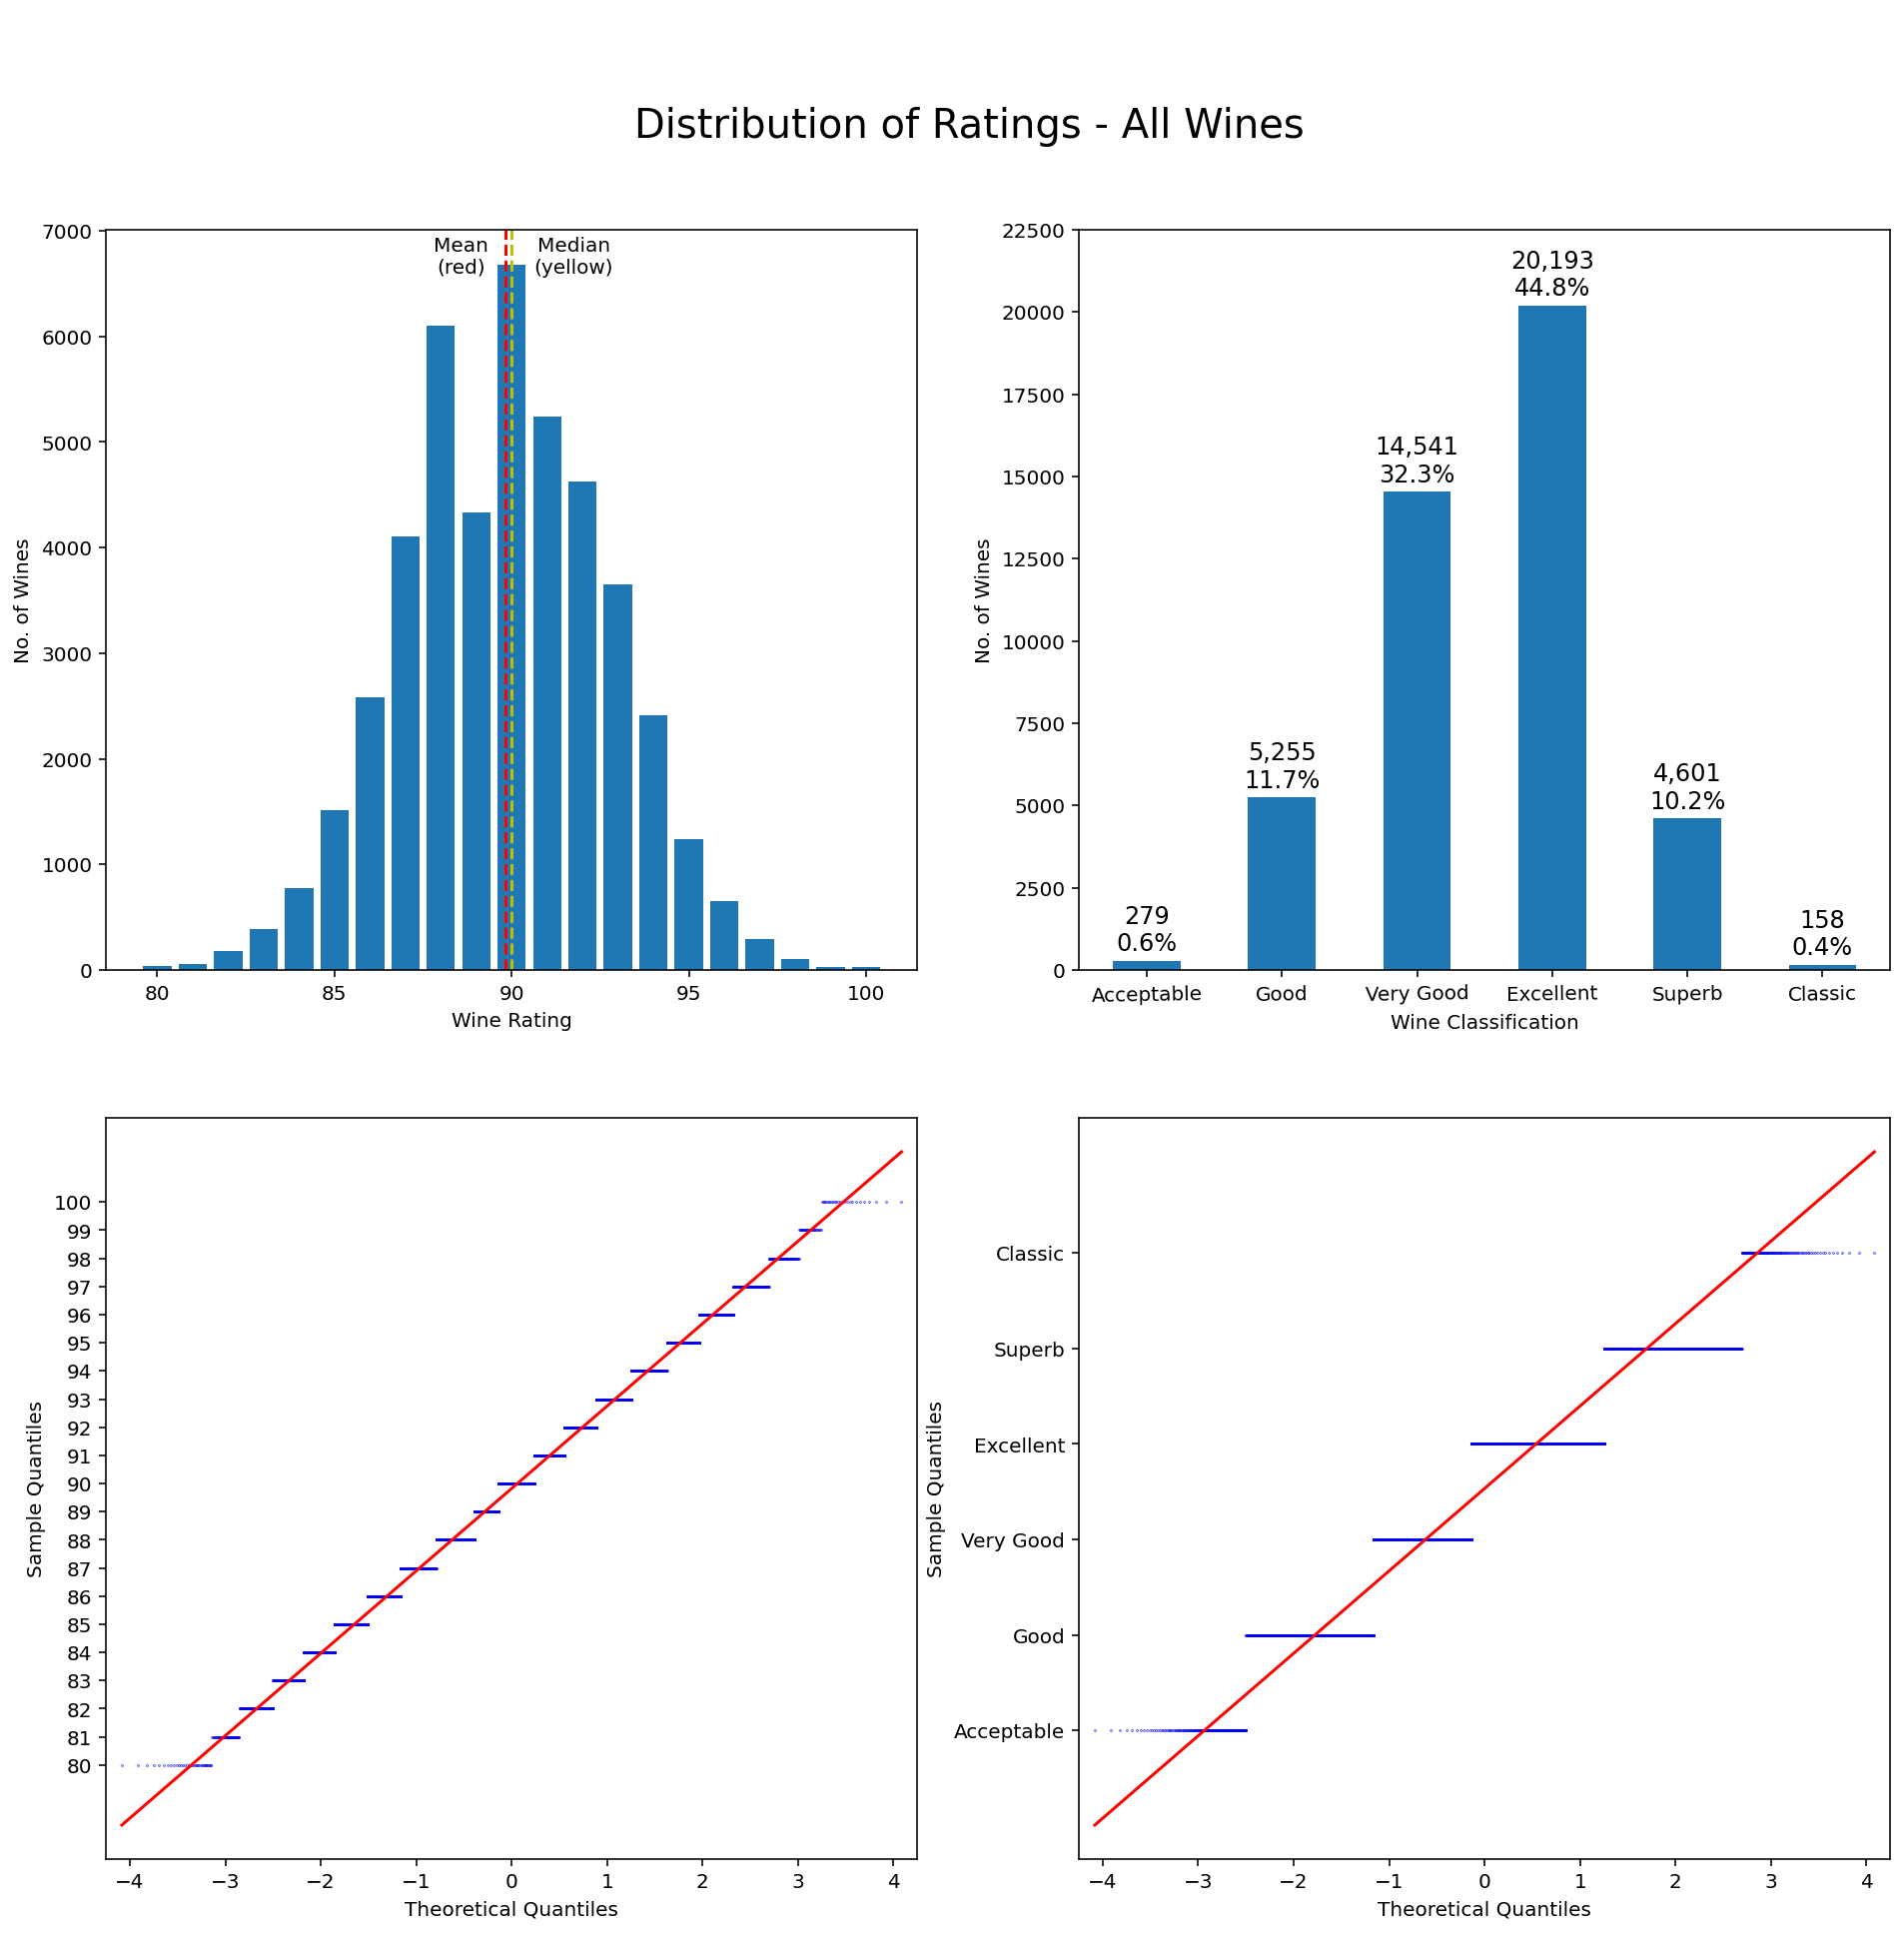

In [26]:
# Code block to plot the distributions of wine ratings and their associated QQ plots
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(16,15))

# Calculate mean and median values of the distribution
rtg_mean = wine['rating'].mean()
rtg_med = wine['rating'].median()

# Generate the x and y values from the indices and values above
x_vals = wine['rating'].value_counts().sort_index().index
y_vals = wine['rating'].value_counts().sort_index()

# Plot the first bar-chart of rating vs. number of reviews
ax1.bar(x=x_vals,height=y_vals)
ax1.axvline(rtg_mean,color='r',linestyle='--')
ax1.axvline(rtg_med,color='y',linestyle='--')
ax1.annotate("Mean\n(red)",(rtg_mean-1.25,6600),
             textcoords='offset points',xytext=(0,0),
             ha='center',fontsize=10)
ax1.annotate("Median\n(yellow)",(rtg_med+1.75,6600),
             textcoords='offset points',xytext=(0,0),
             ha='center',fontsize=10)
ax1.set_xlabel("Wine Rating")
ax1.set_ylabel("No. of Wines")

# Plot the second bar-chart of the grouped classifications vs. number of reviews
classifications = ['Acceptable','Good','Very Good','Excellent','Superb','Classic']
wine['classification'].value_counts().loc[classifications].plot(kind='bar',ax=ax2,rot=True)
ax2.set_ylabel("No. of Wines")
ax2.set_xlabel("Wine Classification")
ax2.set_ylim(0,22500)
for x_pos,y_pos in zip(range(6),wine['classification'].value_counts().loc[classifications]):
    label = f'{y_pos:,}\n{round(100*y_pos/wine.shape[0],1)}%'
    ax2.annotate(label,
                (x_pos,y_pos),
                textcoords='offset points',
                xytext=(0,5),
                ha='center',
                fontsize=12)

# Plot the 3rd and 4th plots using the qqplot function from statsmodels
qqplot(wine['rating'],line='s',marker='.',markersize=0.5,ax=ax3)
qqplot(wine['class_count'],line='s',marker='.',markersize=0.5,ax=ax4)
ax3.set_yticks(range(80,101))
ax4.set_yticks(range(0,6))
ax4.set_yticklabels(classifications,fontsize=10)

plt.suptitle("\n\nDistribution of Ratings - All Wines",fontsize=20)
plt.show()

In [27]:
wine['classification'].value_counts(normalize=True).loc[classifications]

Acceptable    0.006196
Good          0.116708
Very Good     0.322940
Excellent     0.448464
Superb        0.102183
Classic       0.003509
Name: classification, dtype: float64

From the above we can see that the wine ratings appear to closely follow a normal distribution in points score, but with a very slight negative skew as suggested by the median being higher than the mean as seen on the top left figure, although clearly this is a very minor difference.

The two Q-Q plots shown below each of the distributions support this, with the ratings closely following a linear relationship where the 'Superb' and 'Classic' distributions are not as well-centred along the linear relationship as the mid- to lower-rated wines.

There is also a clear class imbalance, with less than 1% of wines falling into the two extreme ends of the classification spectrum.

##### Generalisation of Distribution Analysis for Different Features
We can generalise the above code to look into any of the other variables to aid us in carrying out visual inspections of how the data are distributed across ratings.

In [28]:
# Function to plot the distributions of wine ratings and their associated QQ plots

def wine_dist_qq(column,variable):
    """
    Function to plot wine rating distributions & associated QQ plots.
    
    Takes a column's name and one of the categories within that column as input
    Returns a 2x2 plot of the given category's rating distribution, using both
    numerical ratings and classification groupings, and the QQ plots of those
    distributions assuming a normal distribution
    """
    # Create a mask over a given column and variable within that column
    mask = wine[column]==variable
    
    # Instantiate a 2x2 plot
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(16,15))
    
    # Plot the number of wines in each rating value for the given variable using the
    # mask from above.
    wine['rating'][mask].value_counts().sort_index().plot(kind='bar',ax=ax1,rot=True)
    ax1.set_xlabel("Wine Rating")
    ax1.set_ylabel("No. of Wines")
    
    # For loop to remove classes in the case of any particular mask resulting in zero 
    # wines of a particular classification; required for the .loc[] below as entering
    # values not present in the columns of the masked subset results in a pandas error
    all_class_types = ['Acceptable','Good','Very Good','Excellent','Superb','Classic']
    # Create a copy of the classifications list, as removing list elements while iterating
    # through the same list does not produce desired results.
    classifications = all_class_types.copy()
    for rtg_class in all_class_types:
        if rtg_class not in wine['classification'][mask].unique():
            classifications.remove(rtg_class)
            
    # Plot the number of wines in each classification as specified above
    wine['classification'][mask].value_counts().loc[classifications].plot(kind='bar',ax=ax2,rot=True)
    # Shift the top of the chart up slightly to make room for annotations later
    max_lvl = wine['classification'][mask].value_counts().max()*1.125
    ax2.set_ylim(0,max_lvl)
    ax2.set_ylabel("No. of Wines")
    ax2.set_xlabel("Wine Classification")
    # Add annotations with the count and % of population within each classification
    class_itr = range(len(classifications))
    for x_pos,y_pos in zip(class_itr,wine['classification'][mask].value_counts().loc[classifications]):
        label = f'{y_pos:,}\n{round(100*y_pos/wine.shape[0],1)}%'
        ax2.annotate(label,
                     (x_pos,y_pos),
                     textcoords='offset points',
                     xytext=(0,5),
                     ha='center')
    
    # Plot QQ plots versus a normal distribution using the statsmodels function qqplot
    qqplot(wine['rating'][mask],line='q',marker='.',markersize=0.5,ax=ax3)
    qqplot(wine['class_count'][mask],line='q',marker='.',markersize=0.5,ax=ax4)
    ax3.set_yticks(range(80,101))
    ax4.set_yticks(class_itr)    
    # Overwrite the numerical values (required by qqplot) with the classification labels
    ax4.set_yticklabels(classifications)
    
    plt.suptitle(f"\n\nDistribution of Ratings - {variable}",fontsize=20)
    plt.show()

An example of the `wine_dist_qq()` function in use, filtering into the `country` feature and subset on wines from the USA.

/Users/jacklodge/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jacklodge/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


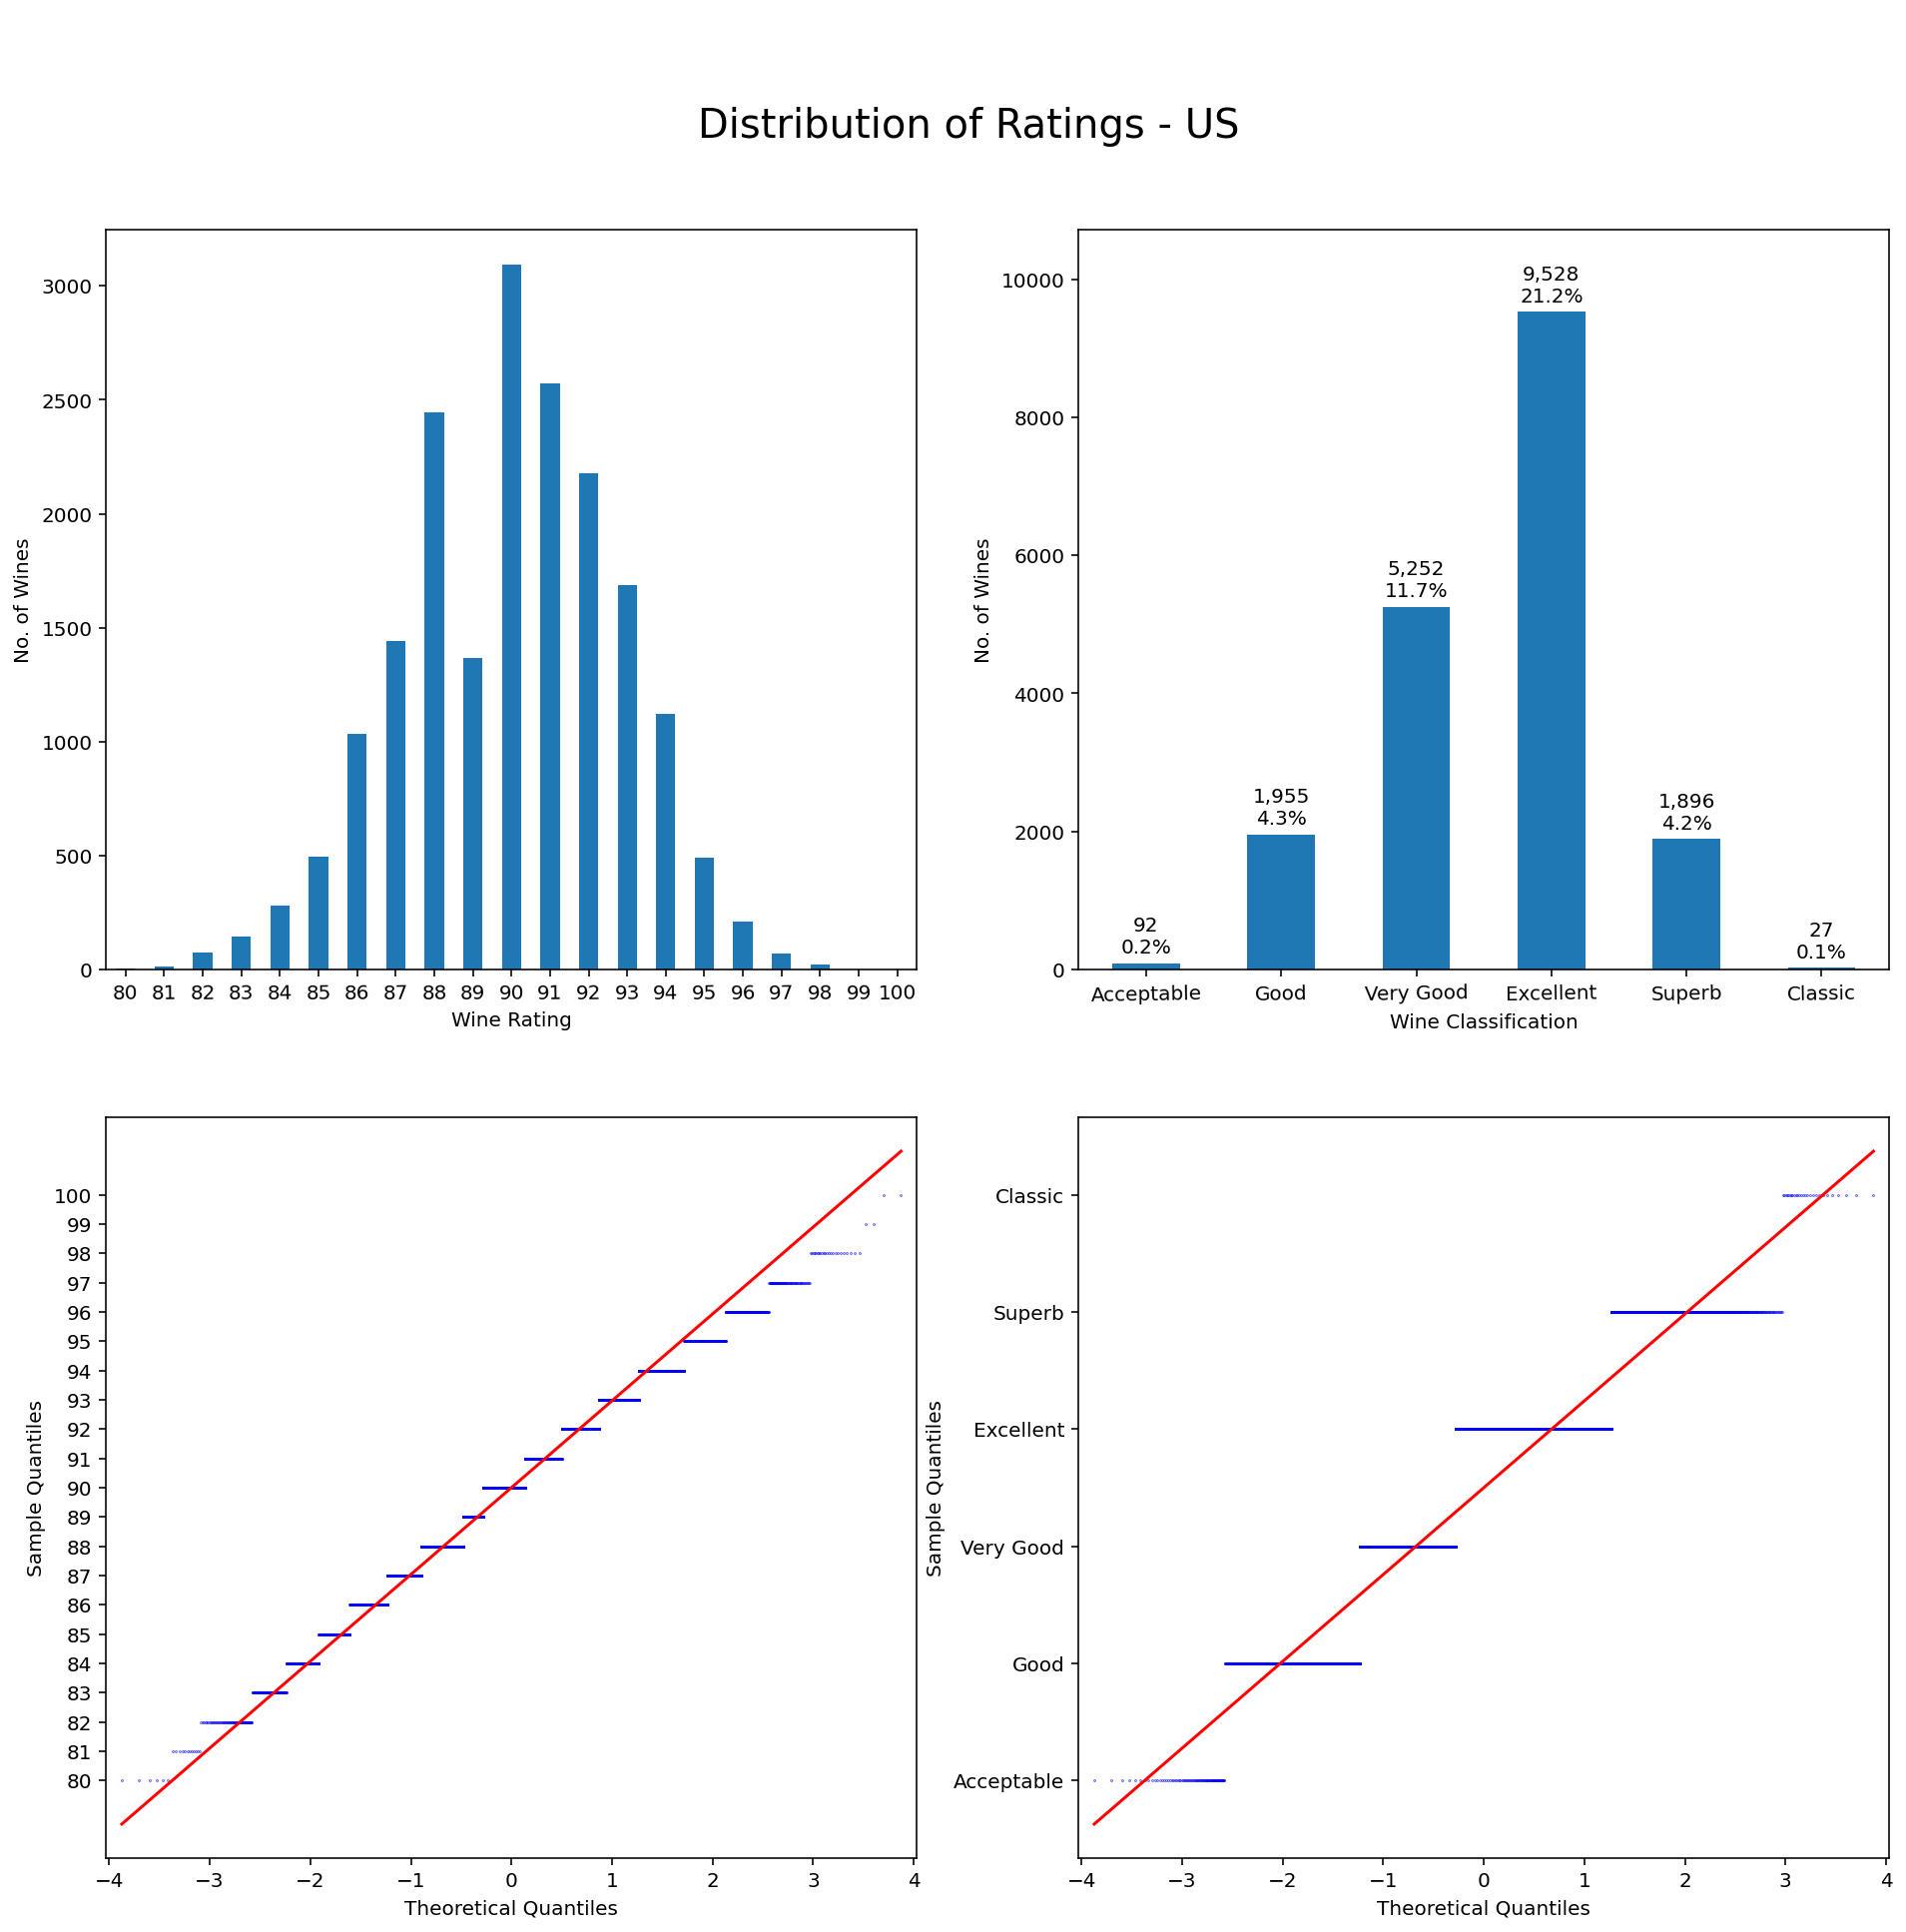

In [29]:
wine_dist_qq("country","US")

##### Heatmaps
We can also visualise the above data in a heatmap format to help understand these distributions more easily.

In [30]:
def wine_heatmap(field):
    """
    Function to plot heatmaps for categorical wine fields using seaborn.
    
    Takes one of the columns specified in the wine DataFrame as input
    Prints a heatmap of the distribution of wines across the 5 different
    classifications from Acceptable to Classic as a % of the population for
    each category within that column as output.
    """
    # Instantiate a DataFrame object
    compare_loc = pd.DataFrame()
    
    # Add a total count of wines within each classification
    compare_loc["Total"] = wine[field].value_counts()
    
    classifications = ['Acceptable',
                       'Good',
                       'Very Good',
                       'Excellent',
                       'Superb',
                       'Classic']
    # Cycle through classifications, adding columns with counts and % of population columns
    for classification in classifications:
        compare_loc[classification] = wine[wine["classification"]==classification][field].value_counts()
        compare_loc[f"{classification} %"] = round(100*compare_loc[classification]/compare_loc["Total"])
    
    # Sort by the Total column so we have the most populated fields; some fields have a very small
    # number of observations within them, meaning we won't be able to make as confident inferences
    # from their distributions.
    compare_loc.sort_values(by="Total",ascending=False,inplace=True)
    
    # Print out the populations of the fields ahead of the heatmaps to give a better idea of how
    # confident we can be that the sample distributions will be representative of the population
    print(field+"\n")
    print(compare_loc["Total"].head(20))

    # Representing this visually for the top-20; fields with zero entries for a given classification
    # will result in NaN values and they will not appear in the heatmap itself. This helps us to 
    # delineate between classes with very small number of observations, which may still round down
    # to 0% on the heatmap, and classes with zero observations.
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,8))
    sns.heatmap(compare_loc[['Acceptable %',
                             'Good %',
                             'Very Good %',
                             'Excellent %',
                             'Superb %',
                             'Classic %']].head(20),
                cmap="Blues",annot=True,ax=ax,annot_kws={"size":12})
    ax.set_title(f"High-Low % Absolute {field}\n")
    plt.show()

An example of the `wine_heatmap()` function being used to examine the distribution of ratings amongst the different professional wine reviewers contributing to the website.

reviewer

Roger Voss            9424
Matt Kettmann         5029
Kerin O’Keefe         4961
Virginie Boone        4652
Jim Gordon            3389
Anne Krebiehl MW      3383
Michael Schachner     2974
Paul Gregutt          2498
Sean P. Sullivan      2289
Anna Lee C. Iijima    2175
Christina Pickard     1643
Alexander Peartree    1249
Fiona Adams            426
Lauren Buzzeo          403
Mike DeSimone          211
Susan Kostrzewa        152
Jeff Jenssen           151
Carrie Dykes            18
Name: Total, dtype: int64


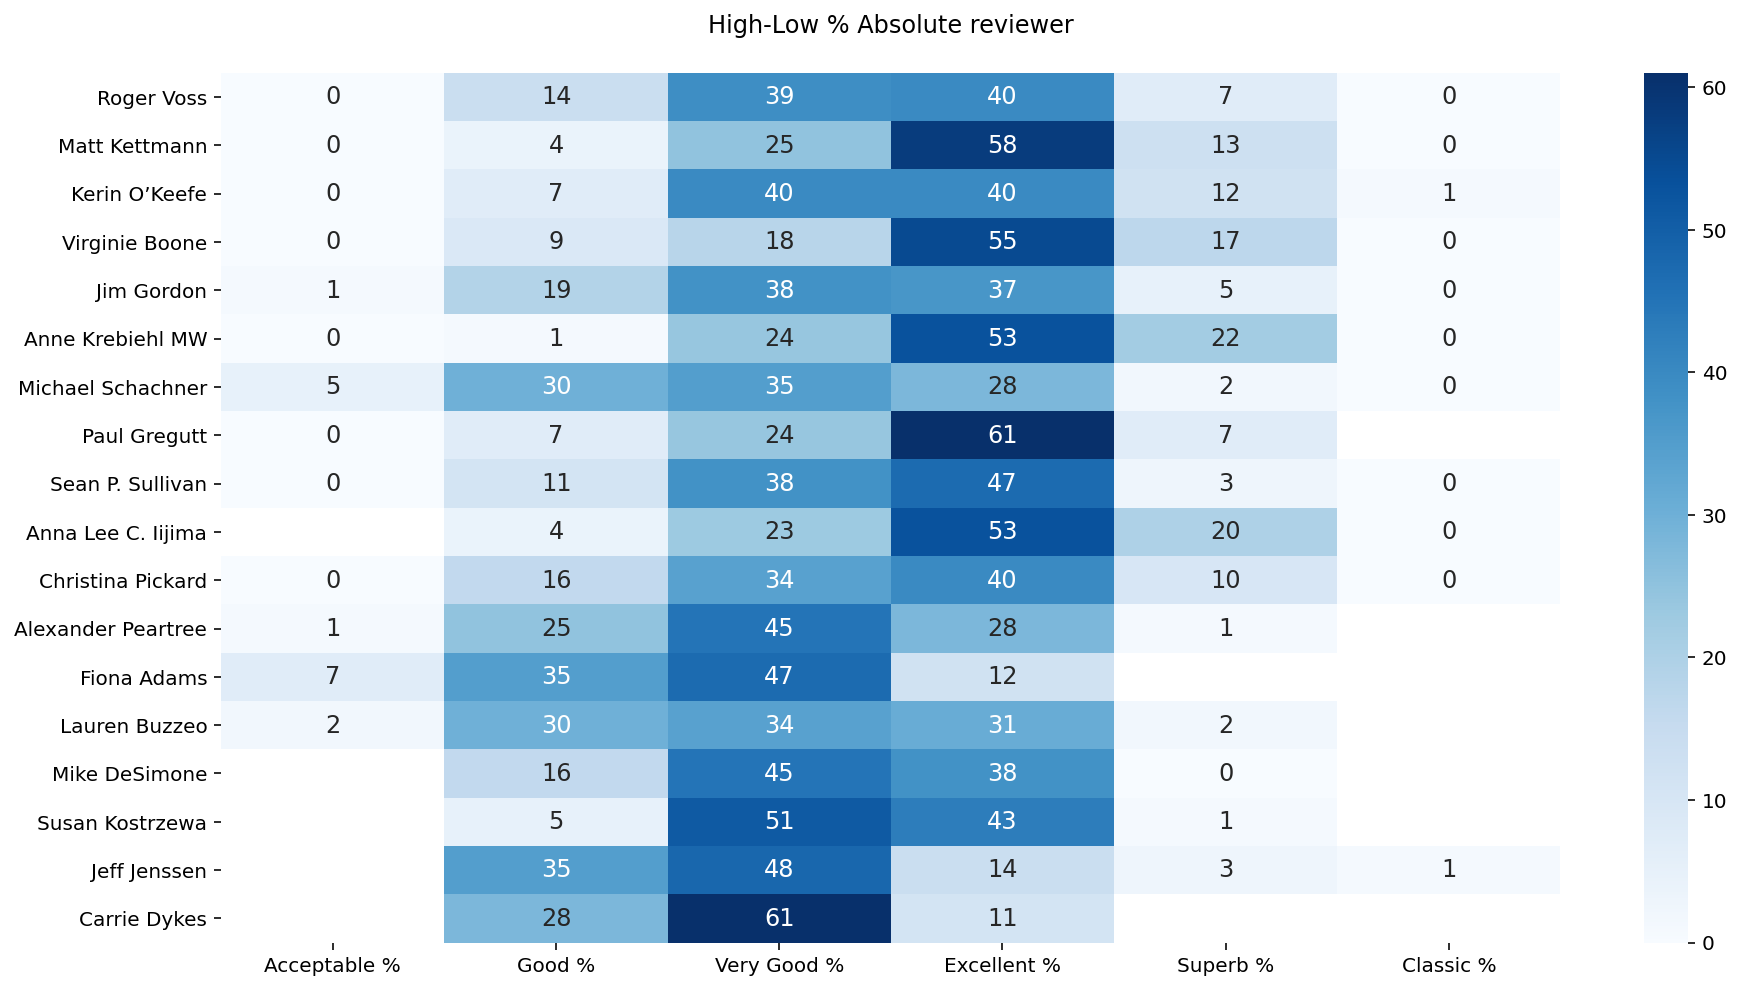

In [31]:
wine_heatmap('reviewer')

### 2.4 Wine Price Investigation
We can now take a look at how our wine prices are distributed, along with any other numerical fields.

As we mentioned earlier, there are potentially going to be some outliers of our price data when 75% of the data is \\$50 and below, but our max value is as high as \\$8,500.

Let's drill into the price quantiles a bit more to see just how much data is distributed towards the higher end of price spectrum using the matplotlib `.hist()` and seaborn `.boxenplot()`, also known as a [letter-value](https://vita.had.co.nz/papers/letter-value-plot.html) plot, plotting functions.

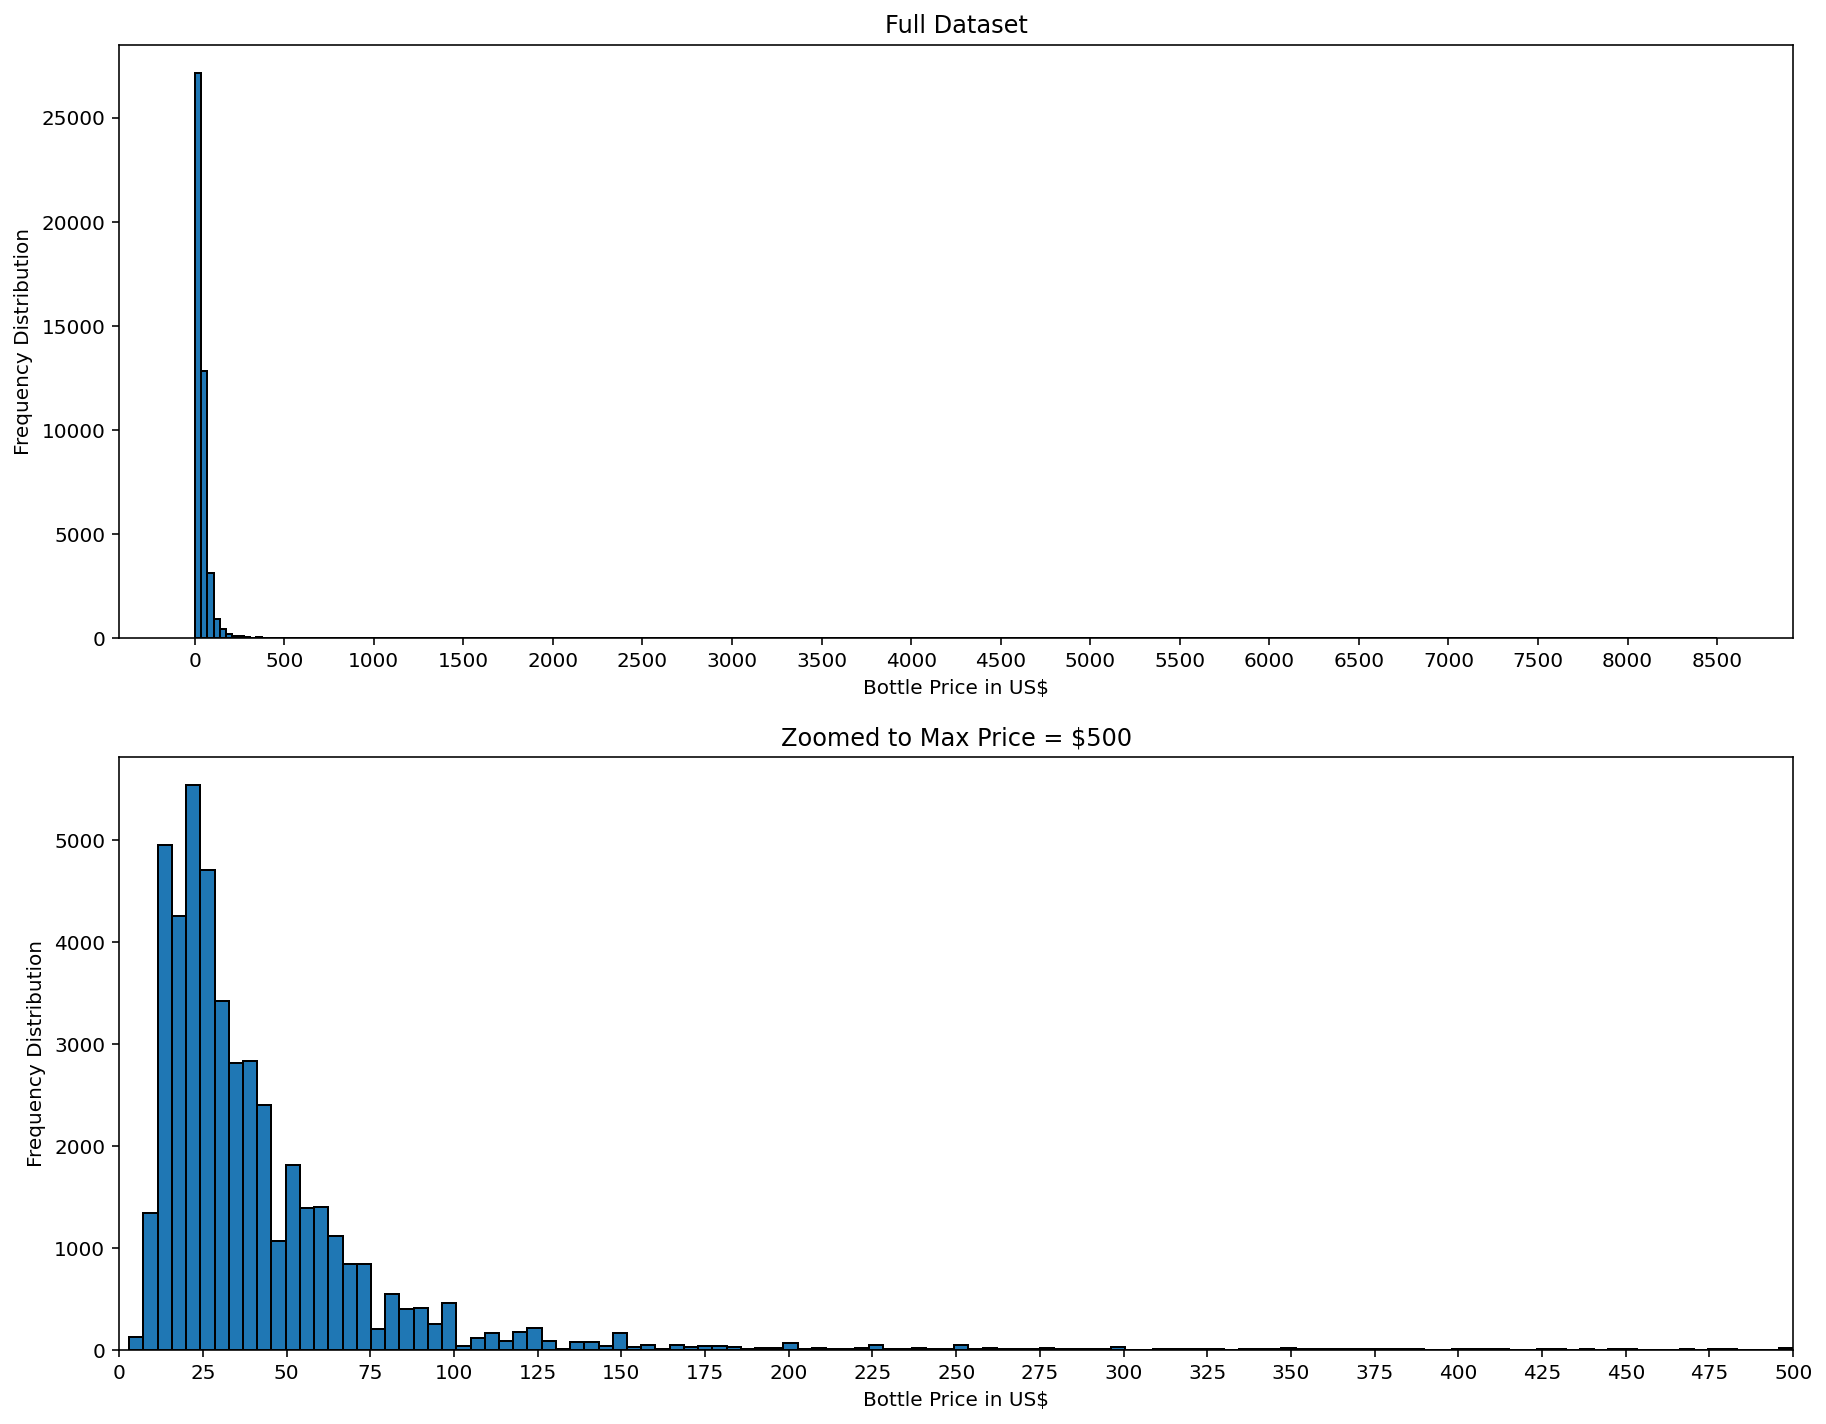

In [32]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(15,12))

ax1.hist(wine['price'],bins=250,edgecolor='black')
ax1.set_xlabel("Bottle Price in US$")
ax1.set_ylabel("Frequency Distribution")
ax1.set_xticks(range(0,9000,500))
ax1.set_title("Full Dataset")

ax2.hist(wine['price'],bins=2000,edgecolor='black')
ax2.set_xlabel("Bottle Price in US$")
ax2.set_ylabel("Frequency Distribution")
ax2.set_xlim(0,500)
ax2.set_xticks(range(0,525,25))
ax2.set_title("Zoomed to Max Price = $500")

plt.show()

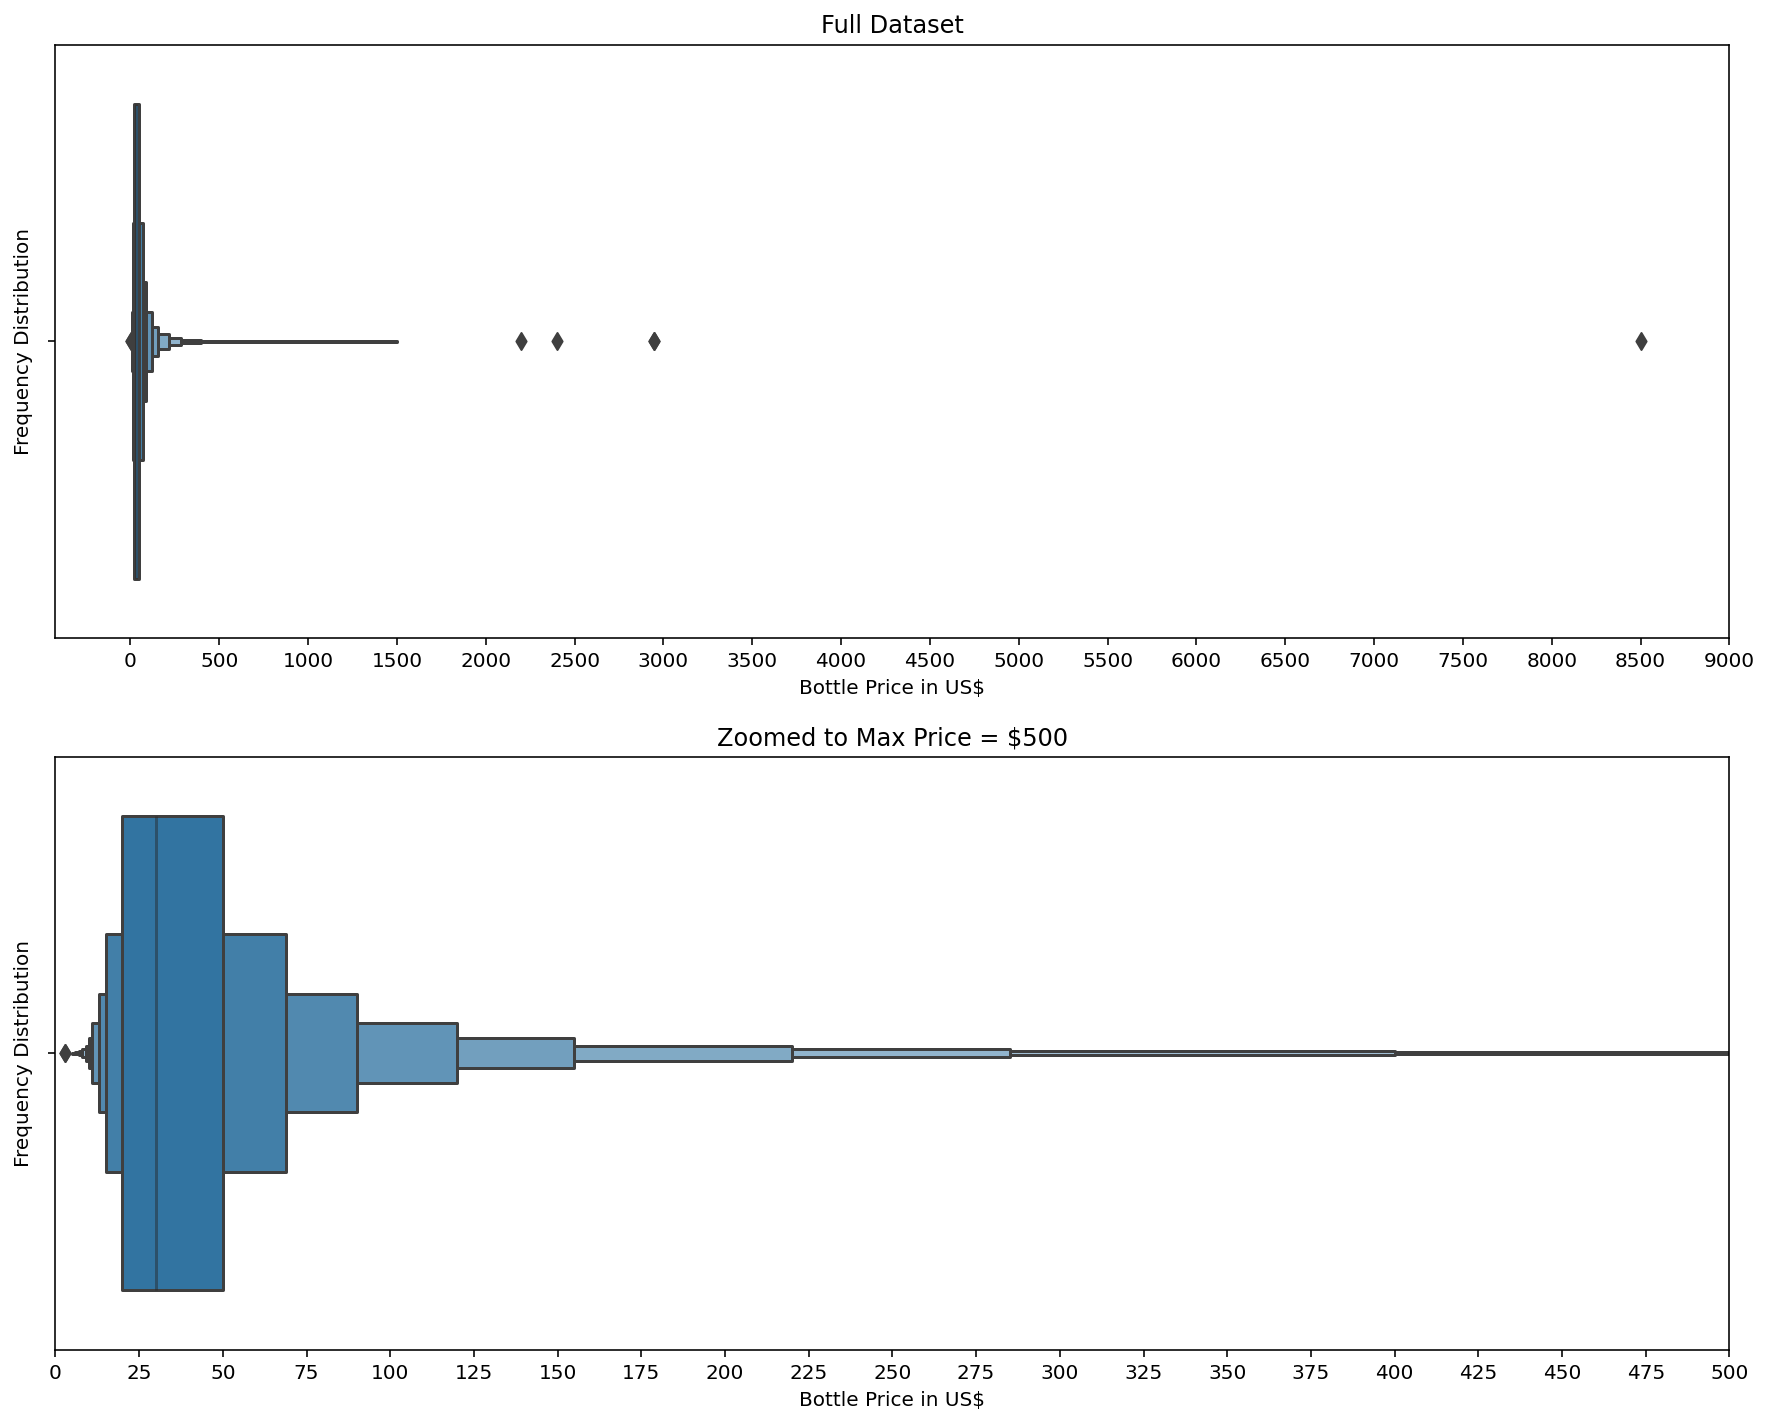

In [33]:
fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,12))
sns.boxenplot(x=wine['price'],ax=ax1)
ax1.set_xlabel("Bottle Price in US$")
ax1.set_ylabel("Frequency Distribution")
ax1.set_xticks(range(0,9500,500))
ax1.set_title("Full Dataset")

sns.boxenplot(x=wine['price'],ax=ax2)
ax2.set_xlabel("Bottle Price in US$")
ax2.set_ylabel("Frequency Distribution")
ax2.set_xlim(0,500)
ax2.set_xticks(range(0,525,25))
ax2.set_title("Zoomed to Max Price = $500")

plt.show()

We can see from the above plots that there are data points well above the bulk of our data, and could easily be considered outliers to the rest of the distribution. However, given that these wines are very real, and do indeed cost as much as \\$8,500, we will leave them in the dataset for now.

We can also look at some more QQ plots for the price target variable, to visually test how the data are distributed versus different distributions. In order to aid visualisation we have filtered out any wines over $2,000 as outliers on the extremes of our dataset.

In the first QQ plot below, we are plotting our data versus a normal distribution, as we were before for the wine's rating, and in the second versus an exponential distribution. From our initial histogram and letter value plots, we already had an assumption that an exponential distribution would likely be the better match and indeed we can confirm that visually from the plots below.

/Users/jacklodge/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jacklodge/miniforge3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


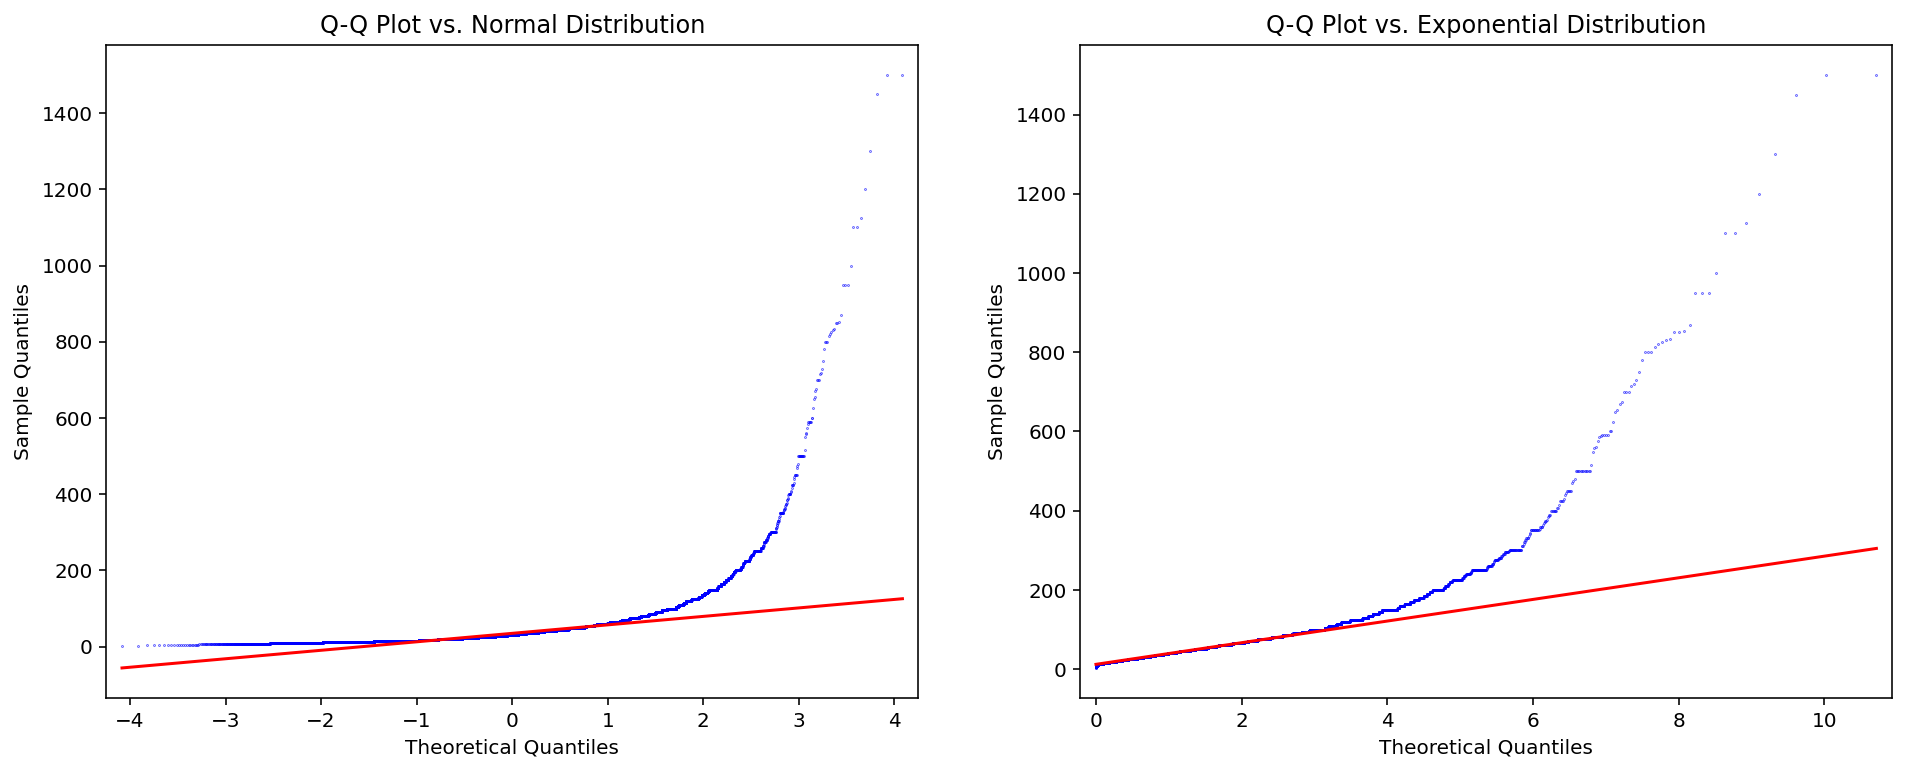

In [34]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
qqplot(wine[wine['price']<2000]['price'],line='q',marker='.',markersize=0.5,ax=ax1)
qqplot(wine[wine['price']<2000]['price'],dist=scipy.stats.expon,line='q',marker='.',markersize=0.5,ax=ax2)

ax1.set_title("Q-Q Plot vs. Normal Distribution")
ax2.set_title("Q-Q Plot vs. Exponential Distribution")

plt.show()

The data still trail away from the linear relationship when using the exponential distribution, suggesting that the data follow an even steeper decay than the simple $e^{-x}$ we have modelled here, although it appears to be an improvement compared to an assumption of normally distributed data.

#### 2.4.1 Investigation Into Trends in Quantitative Features vs. Wine Prices
We can run a very quick and simple correlation calculation to determine just how linearly correlated price is with other quantitative fields. We started by using the simple pandas `.corr()` function.

Here we should flag that we are using the rating value as a continuous variable despite being categorical given the ordinal nature to the field.

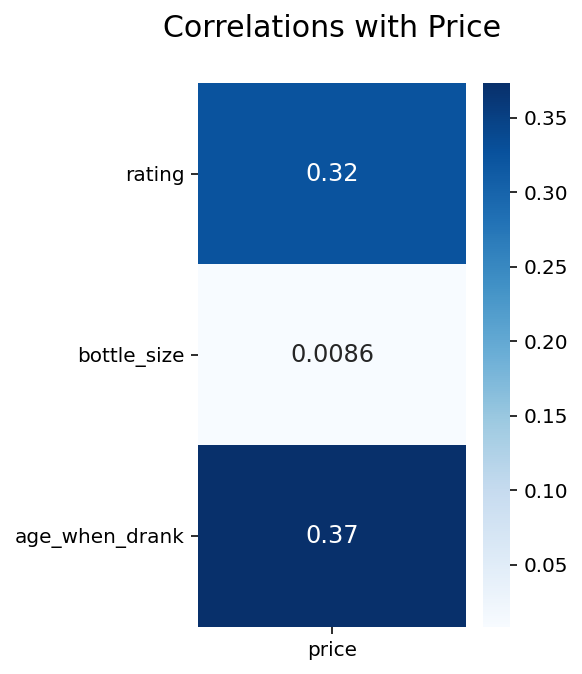

In [35]:
fig,ax = plt.subplots(figsize=(3,5))
number_fields = ['rating','bottle_size','age_when_drank']
corr_matrix = wine[['price']+number_fields].corr()
sns.heatmap(corr_matrix[['price']].loc[number_fields],
            annot=True,ax=ax,cmap="Blues",annot_kws={"size":12})
ax.set_title("Correlations with Price\n",fontsize=15)
plt.yticks(rotation=0)
plt.show()

We can see from the correlation matrix above that there is a positive relationship between price and rating, as we might intuitively expect, of 0.32.

The age when the wine was drank also has a positive linear correlations with a given wine's price as well, whereas the only other remaining numerical field, bottle size, has close to no correlation at all.

By plotting the data we can examine how the relationship between price, rating and age appear, and whether there are any trends immediately evident.

##### Wine Rating vs. Price

We have set the y-axis on a logarithmic scale in order to aid the visualisation, acknowledging the very high priced wines in the higher rated portion of the dataset. We have also included a table including the population, min, mean and max prices of each wine, delineated by its rating classification, as a reminder of the class imbalances present within the data.

In [36]:
classifications = ['Acceptable','Good','Very Good','Excellent','Superb','Classic']

# Instantiate a DataFrame object
class_populations = pd.DataFrame()

class_populations['Count'] = wine['classification'].value_counts().loc[classifications]
class_populations['% of Total'] = round(100*class_populations['Count']/class_populations['Count'].sum(),1)
class_populations['Cumulative %'] = class_populations['% of Total'].cumsum()
class_populations['Min USD'] = wine.groupby('classification')['price'].min().astype(int)
class_populations['Mean USD'] = wine.groupby('classification')['price'].mean().astype(int)
class_populations['Max USD'] = wine.groupby('classification')['price'].max().astype(int)

class_populations.head(6)

,Count,% of Total,Cumulative %,Min USD,Mean USD,Max USD
Acceptable,279,0.6,0.6,6,20,85
Good,5255,11.7,12.3,3,21,400
Very Good,14541,32.3,44.6,5,27,335
Excellent,20193,44.8,89.4,6,44,1300
Superb,4601,10.2,99.6,17,89,2950
Classic,158,0.4,100.0,39,318,8500


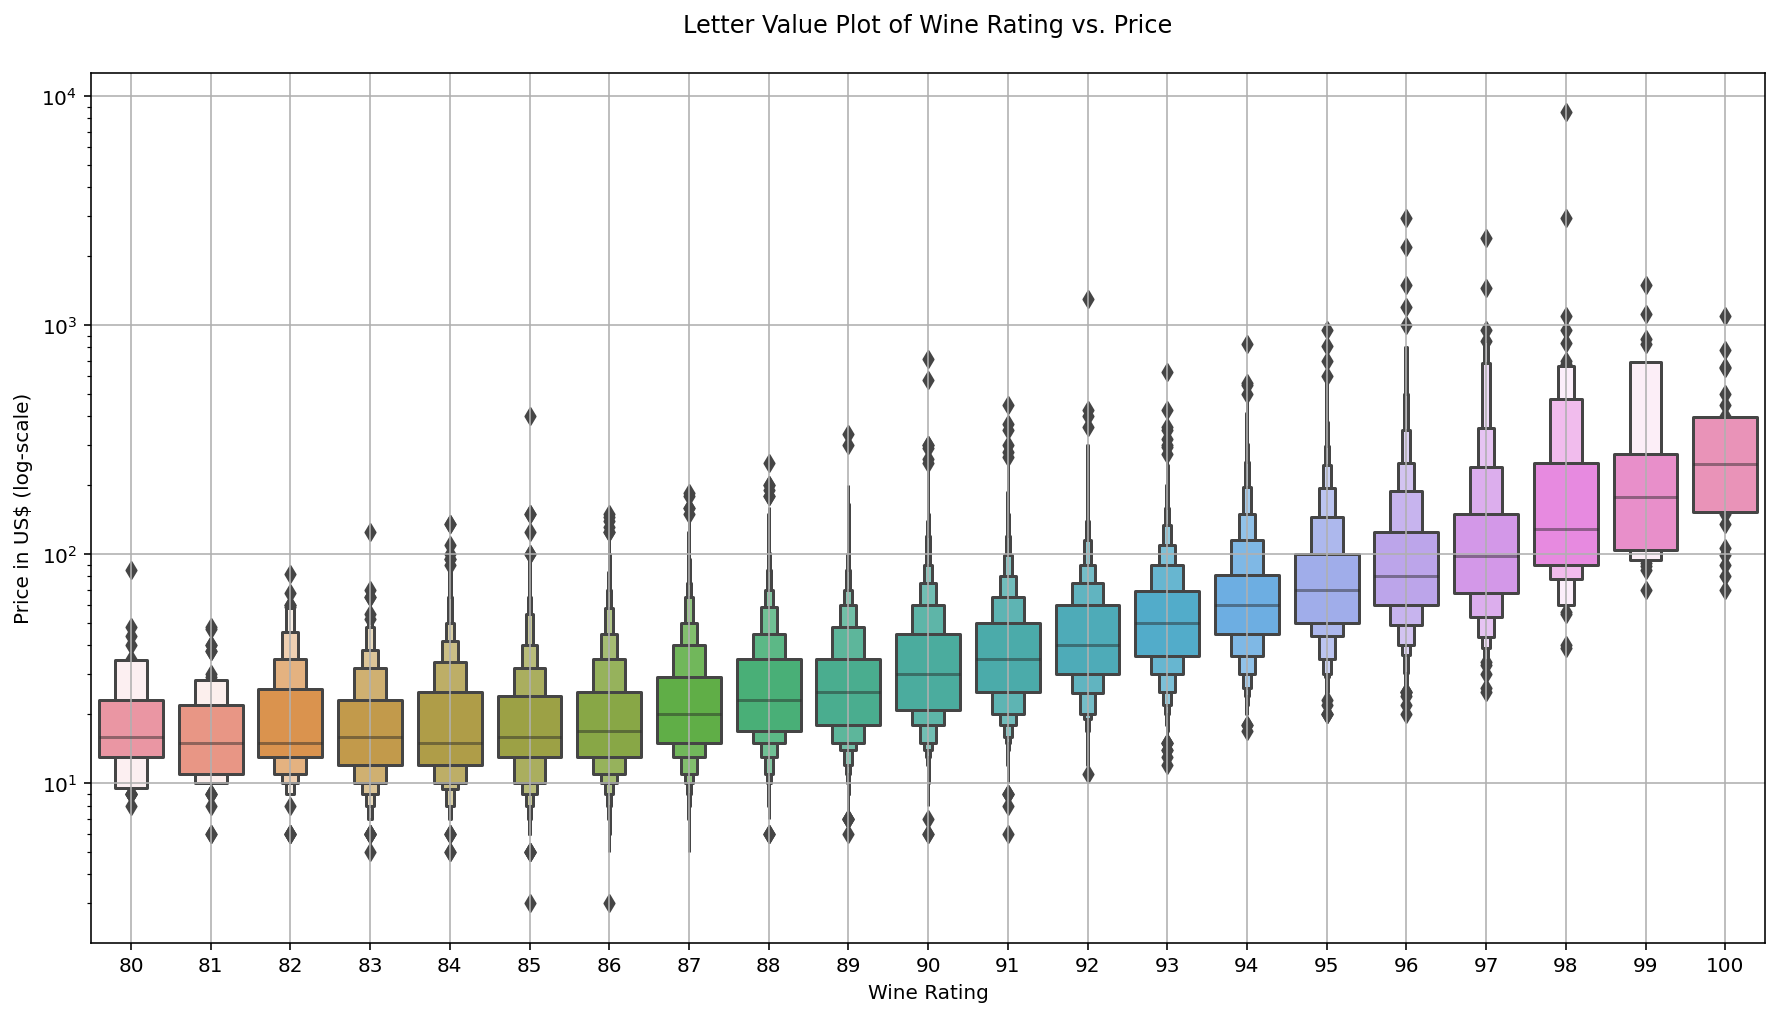

In [37]:
fig,ax = plt.subplots(figsize=(15,8))
sns.boxenplot(x=wine['rating'],y=wine['price'],ax=ax)
ax.set_yscale('log')
ax.set_xlabel("Wine Rating")
ax.set_ylabel("Price in US$ (log-scale)")
ax.set_title("Letter Value Plot of Wine Rating vs. Price\n")
ax.grid(True)
plt.show()

We can see from the above letter value plot that there is a visually evident relationship between price and rating, as initially suggested from the quick correlation analysis. While a higher priced bottle of wine generally appears to have a high rating, there is less confidence in saying that a high rated wine must be of a high price, as can be seen from the overlapping prices across ratings; the lowest priced "Excellent" wine was only \\$6 for a 375ml can!

We can also infer that the lower rated wines all tend to be towards the lower end of the price spectrum - although there are still some rather expensive wines on an objective basis; the most expensive wine to only score 80 points was $85, for example (higher than the lowest priced "Classic" wine).

What is also interesting to note is the non-linear relationship between price and rating, particularly towards the higher end of the ratings spectrum. This is likely due to the cost of the wine beginning to be dominated more by economic supply and demand effects, rather than a reflection of the investment in the viticulture and winemaking procedure itself; a fairly common trait of smaller appellations or wineries with limited output but high demand given branding and reputational strength.

##### Generalising the Letter Value Plotting Capability
Once again we can generalise this process within a function to save time - this function will only work after the `wine` DataFrame has been defined.

In [38]:
def letter_value_plotter(feature,sort_by='vals',show_chart=True):
    """
    Function to generate letter-value plots for a 
    given wine feature in the dataset using a DataFrame
    describing the population of that given feature.
    
    Takes one of the column headings as input.
    Returns the population's descriptive DataFrame and
    includes the option to plot the letter-value plot
    
    The option to sort by index (ascending/descending)
    or by population of each category is included and
    called as sort_by='vals' / 'idx_down' / 'idx_up'
    """
    df = pd.DataFrame()
    df['Count'] = wine[feature].value_counts()
    df['% of Total'] = round(100*df['Count']/df['Count'].sum(),1)
    if sort_by == 'vals':
        df.sort_values('% of Total',ascending=False,inplace=True)
    elif sort_by == 'idx_down':
        df.sort_index(inplace=True,ascending=False)
    elif sort_by == 'idx_up':
        df.sort_index(inplace=True,ascending=True)
    else:
        print("ERROR: sort_by can only take vals, idx_up or idx_down as argument")
        return None
    df['Cumulative %'] = df['% of Total'].cumsum()
    df['Min USD'] = wine.groupby(feature)['price'].min().astype(int)
    df['Mean USD'] = wine.groupby(feature)['price'].mean().astype(int)
    df['Max USD'] = wine.groupby(feature)['price'].max().astype(int)
    
    # Chart toggle added for ease of reprinting the table later in §3.3.2
    if show_chart:
        fig,ax = plt.subplots(figsize=(15,8))
        sns.boxenplot(x=wine[feature],y=wine['price'],ax=ax,order=df.index)
        ax.set_yscale('log')
        ax.set_xlabel(f"Feature = {feature}")
        ax.set_ylabel("Price in US$ (log-scale)")
        ax.set_title(f"Letter Value Plot of {feature} vs. Price\n")
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
        ax.grid(True)
        plt.show()
    
    return df

##### Wine Age vs. Price
We can now examine the relationship with the different wine ages when the reviews were written.

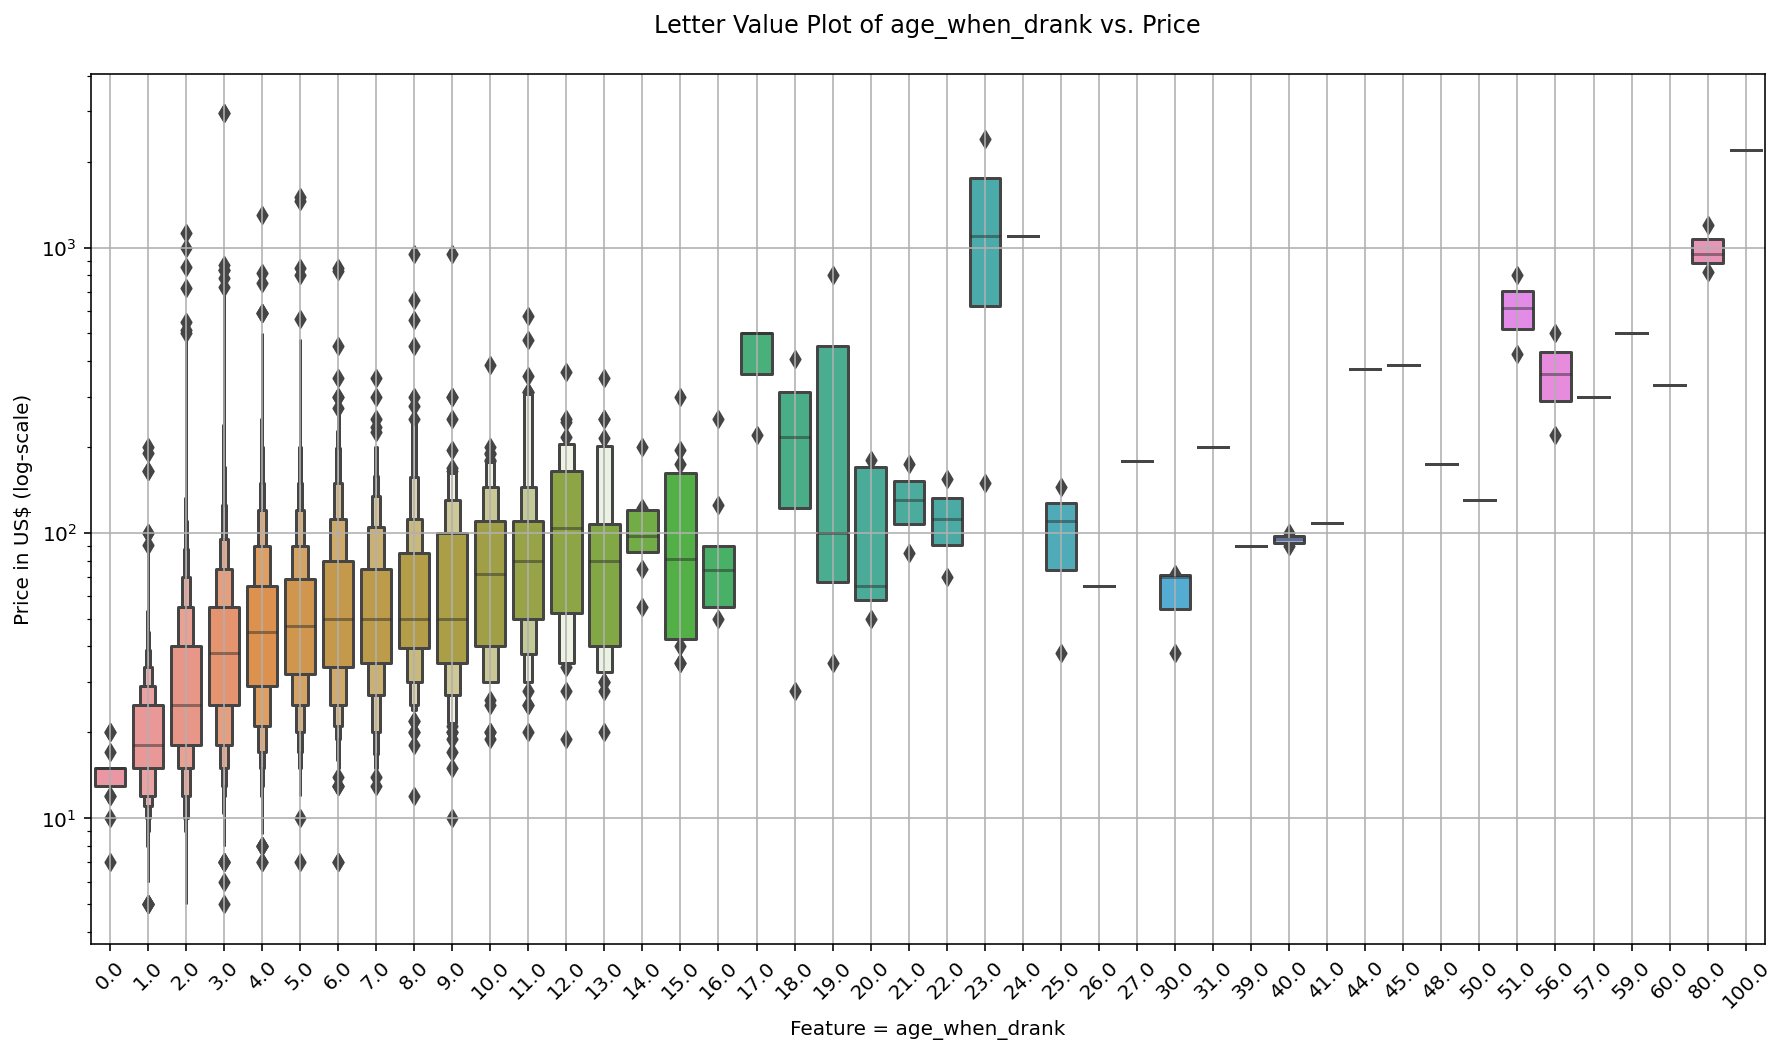

,Count,% of Total,Cumulative %,Min USD,Mean USD,Max USD
0.0,18,0.0,0.0,7,14,20
1.0,6990,16.1,16.1,5,20,200
2.0,13329,30.7,46.8,5,33,1125
3.0,12861,29.6,76.4,5,46,2950
4.0,5943,13.7,90.1,7,54,1300
5.0,2428,5.6,95.7,7,58,1500
6.0,873,2.0,97.7,7,66,850
7.0,347,0.8,98.5,13,62,350
8.0,199,0.5,99.0,12,78,950
9.0,105,0.2,99.2,10,80,950


In [39]:
letter_value_plotter('age_when_drank',sort_by='idx_up').head(11)

The plot of wine price versus age also confirms the positive relationship present, although the data get increasingly noisy with age, owing to the small number of older wines drank in the dataset.

#### 2.4.2 Investigation Into Trends in Categorical Features vs. Wine Prices
We can also look into how the wine price distributions vary between different categorical features to see if there are notable differences or trends present.

##### Country of Origin vs. Price

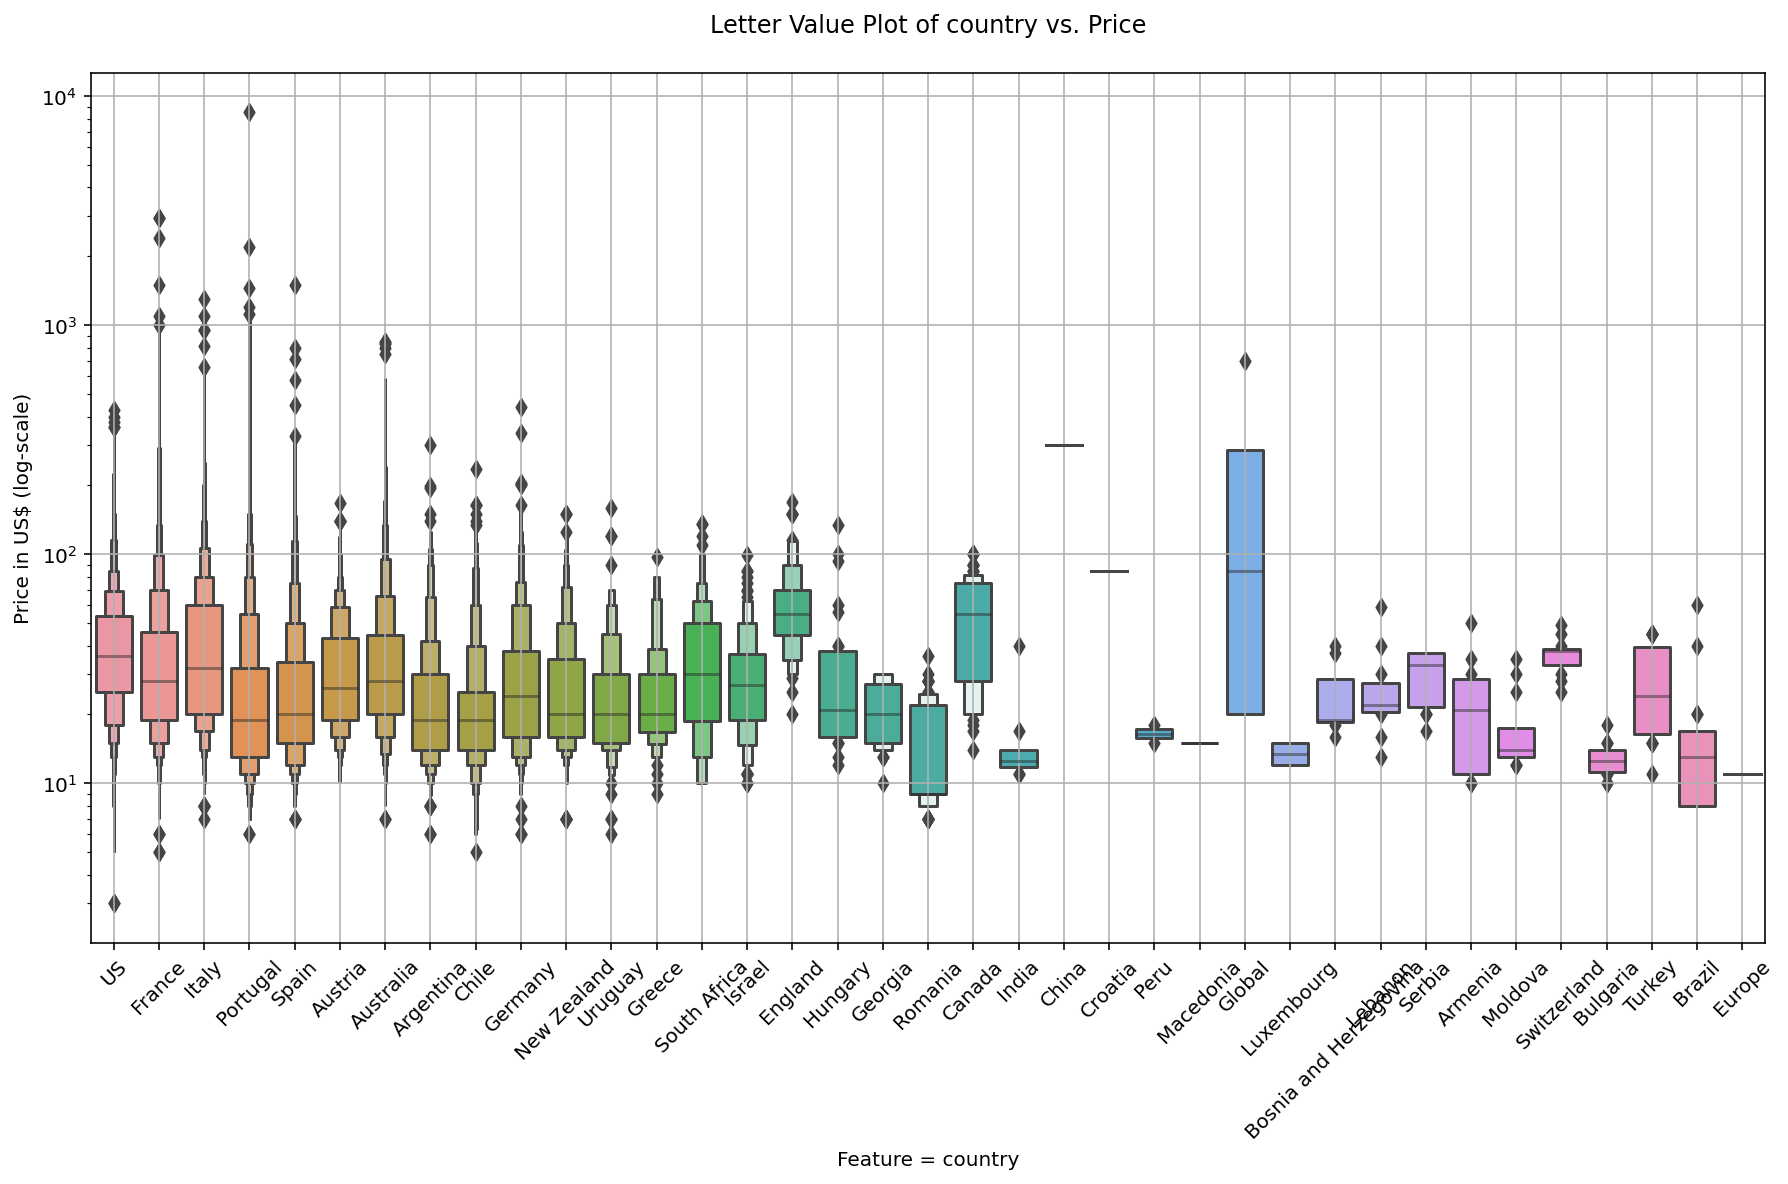

,Count,% of Total,Cumulative %,Min USD,Mean USD,Max USD
US,18750,41.6,41.6,3,43,425
France,11148,24.8,66.4,5,42,2950
Italy,5595,12.4,78.8,7,46,1300
Portugal,2271,5.0,83.8,6,37,8500
Spain,1381,3.1,86.9,7,32,1500
Austria,1179,2.6,89.5,10,33,168
Australia,1128,2.5,92.0,7,42,850
Argentina,758,1.7,93.7,6,26,300
Chile,660,1.5,95.2,5,25,235
Germany,666,1.5,96.7,6,33,440


In [40]:
letter_value_plotter('country').head(10)

We can see there is some variation of distributions between different countries, again with the data becoming more noisy towards the countries with a lower-count of observations, as might be expected.

##### Wine Category vs. Price

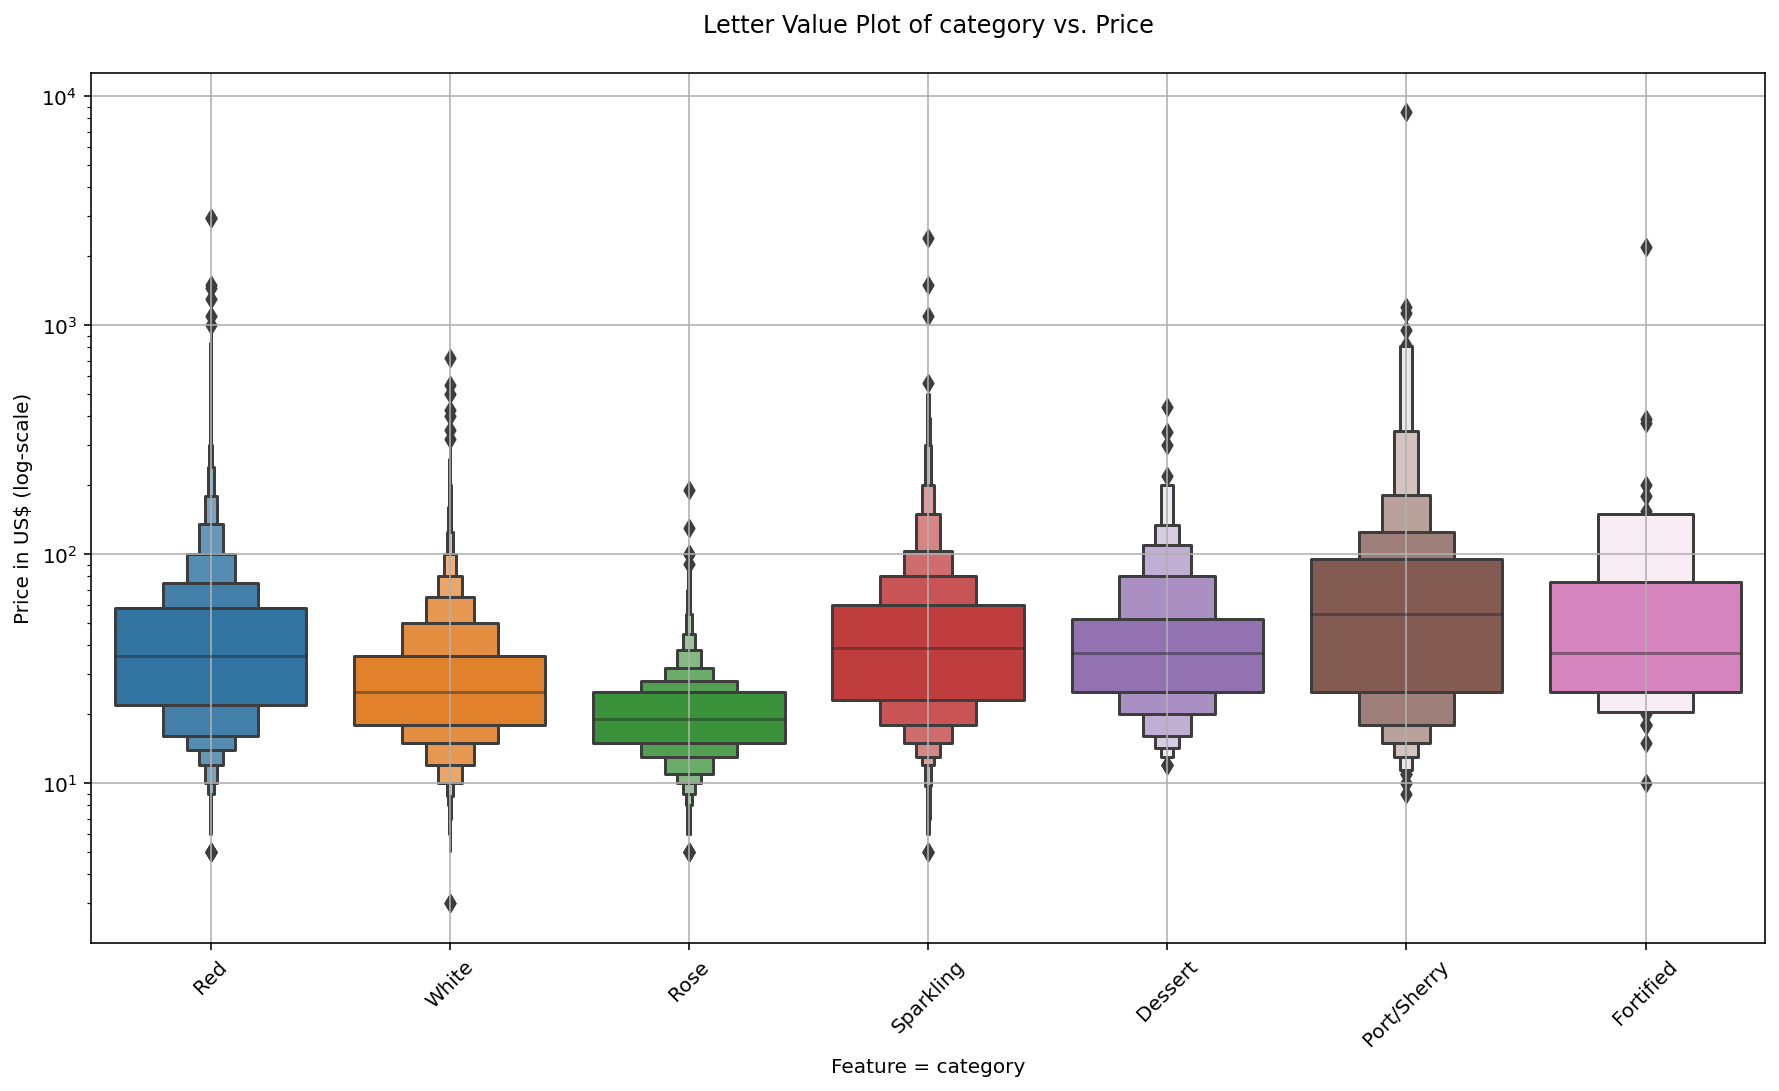

,Count,% of Total,Cumulative %,Min USD,Mean USD,Max USD
Red,26102,58.0,58.0,5,47,2950
White,13290,29.5,87.5,3,31,719
Rose,2617,5.8,93.3,5,20,190
Sparkling,2396,5.3,98.6,5,50,2400
Dessert,295,0.7,99.3,12,48,440
Port/Sherry,284,0.6,99.9,9,114,8500
Fortified,43,0.1,100.0,10,119,2200


In [41]:
letter_value_plotter('category')

There are some notable trends present here as well, such as rose wines being distributed towards the lower end of the price spectrum and vice versa for dessert wines, although other categories look fairly similarly distributed, such as red and sparkling wines.

##### Wine Vintage vs. Price

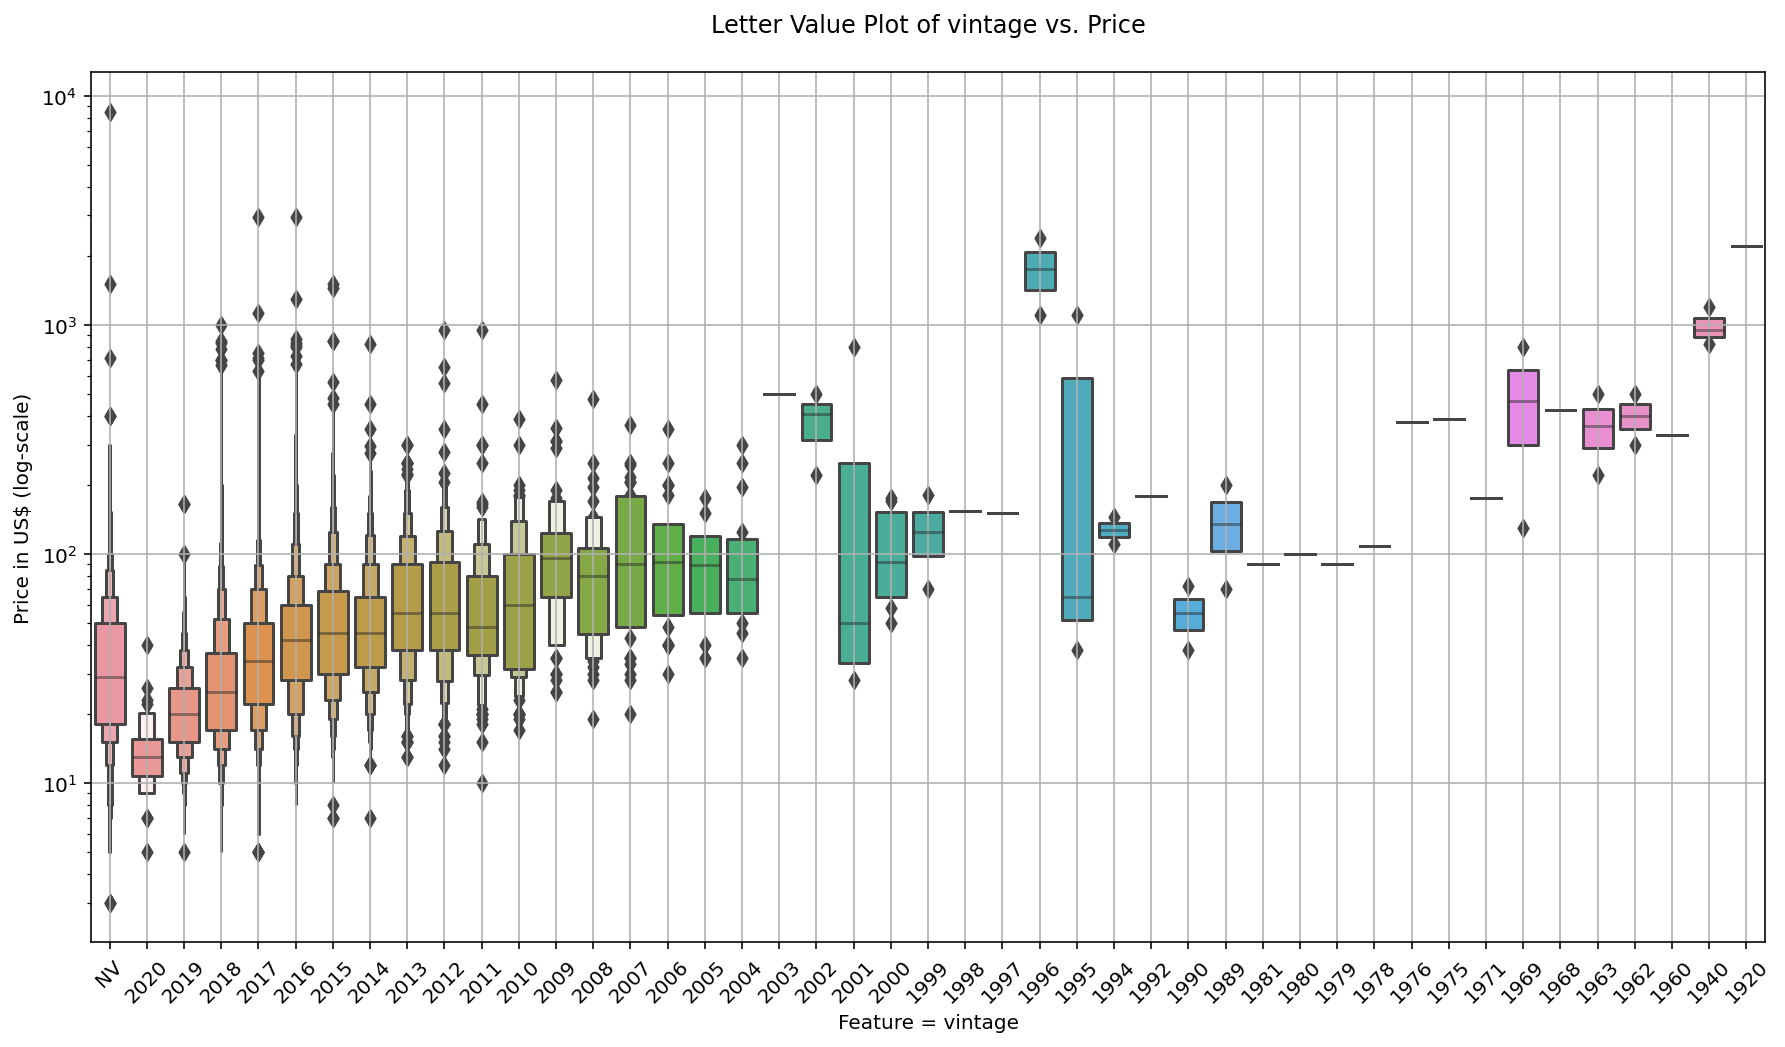

,Count,% of Total,Cumulative %,Min USD,Mean USD,Max USD
NV,1632,3.6,3.6,3,45,8500
2020,32,0.1,3.7,5,14,40
2019,4765,10.6,14.3,5,22,165
2018,13533,30.1,44.4,5,31,999
2017,12017,26.7,71.1,5,42,2950
2016,7687,17.1,88.2,8,52,2950
2015,3135,7.0,95.2,7,58,1500
2014,1054,2.3,97.5,7,56,825
2013,497,1.1,98.6,13,70,300
2012,231,0.5,99.1,12,78,950


In [42]:
letter_value_plotter('vintage',sort_by='idx_down').head(10)

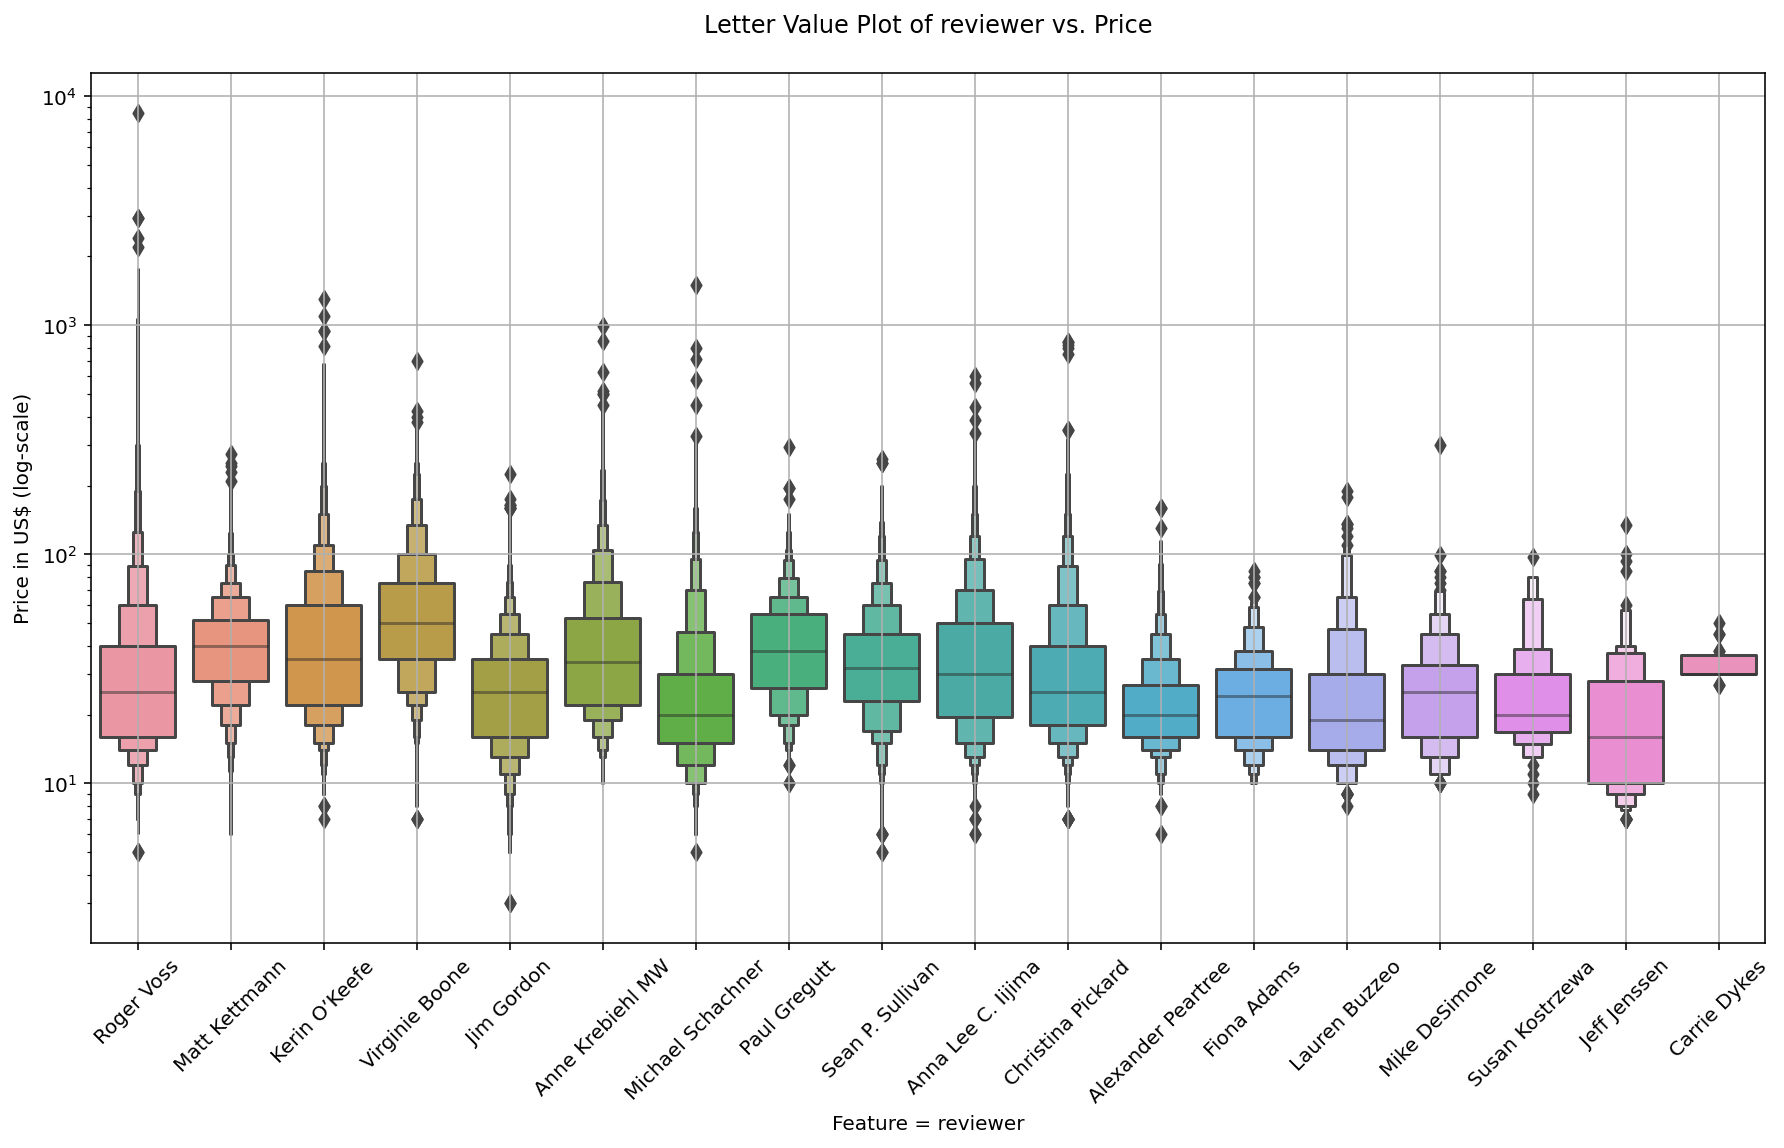

,Count,% of Total,Cumulative %,Min USD,Mean USD,Max USD
Roger Voss,9424,20.9,20.9,5,39,8500
Matt Kettmann,5029,11.2,32.1,6,43,275
Kerin O’Keefe,4961,11.0,43.1,7,49,1300
Virginie Boone,4652,10.3,53.4,7,62,700
Jim Gordon,3389,7.5,60.9,3,28,225
Anne Krebiehl MW,3383,7.5,68.4,10,46,999
Michael Schachner,2974,6.6,75.0,5,29,1500
Paul Gregutt,2498,5.5,80.5,10,43,295
Sean P. Sullivan,2289,5.1,85.6,5,38,260
Anna Lee C. Iijima,2175,4.8,90.4,6,41,600


In [43]:
letter_value_plotter('reviewer')

# 3. Modelling
Now that we have a good feel for our dataset, we can move onto the modelling section to see what relationships we might be able to uncover with the features available to us.

### 3.1 Regression Analysis of Quantitative Fields
Firstly, still using our quasi-continuous assumption about the ratings of the wines, we can quickly fit an ordinary least squares linear regression model targeting a wine's price from the numerical fields of rating, age and bottle size.

In [44]:
# First generate a list of indices where there is no age data and
# remove those observations from both the feature and target datasets.
idx_no_data = wine[wine['age_when_drank'].isna()].index

X_no_std = wine[['rating','bottle_size','age_when_drank']].drop(idx_no_data)
y = wine['price'].drop(idx_no_data)

# Centre and scale the price column using the StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_no_std),columns=X_no_std.columns)

# Make an 80/20 train/test split
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

# Instantiate and fit a LinearRegression model
linreg = LinearRegression()
linreg.fit(Xtr,ytr)

# Cross-validate the model using k=5 folds
linreg_cv = cross_val_score(linreg,Xtr,ytr,cv=5)

print(f"Train R2 Score:\t\t{round(linreg.score(Xtr,ytr),5)}")
print(f"Test  R2 Score:\t\t{round(linreg.score(Xte,yte),5)}")
print(f"Average CV Score:\t{round(linreg_cv.mean(),5)}")
print("\nCoefficients\n"+12*"=")
print(f"Rating:\t\t{round(linreg.coef_[0],5)}")
print(f"Bottle Size:\t{round(linreg.coef_[1],5)}")
print(f"Age:\t\t{round(linreg.coef_[2],5)}")
print(f"\nIntercept:\t{linreg.intercept_}")

Train R2 Score:		0.2534
Test  R2 Score:		0.25742
Average CV Score:	0.25223

Coefficients
Rating:		17.60027
Bottle Size:	1.529
Age:		16.71596

Intercept:	41.71716917232735


As we can see from the train, test and average cross-validated $R^2$ scores in this simple linear regression model, we cannot simply use the quantitative features as predictors of a wine's rating with a high degree of confidence, although the sign of the coefficients do provide support for our visual inspection and preliminary correlation calculation of positive relationships being present, as well as their relative strengths.

### 3.2 Incorporating Categorical Features
Now we have had a quick investigation into some of the numerical fields into our regression model, we can investigate how well the other features work as predictors of a wine's rating. This will require dummification of several of the columns in order to be able to be incorporated into our regression modelling tools.

Given that some of the fields have so many different unique entries it is questionable whether these will be able to offer significant predictive power which can in turn be generalised; dummifying wine reviews, as an extreme example, would be a fruitless exercise given that they are all unique.

In [45]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45027 entries, 0 to 49928
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           45027 non-null  object 
 1   review          45027 non-null  object 
 2   reviewer        45027 non-null  object 
 3   rating          45027 non-null  int64  
 4   price           45027 non-null  float64
 5   designation     33479 non-null  object 
 6   variety         45027 non-null  object 
 7   country         45027 non-null  object 
 8   appellation     45023 non-null  object 
 9   sub_region1     38700 non-null  object 
 10  sub_region2     18308 non-null  object 
 11  winery          45027 non-null  object 
 12  bottle_size     45027 non-null  int64  
 13  category        45027 non-null  object 
 14  importer        26277 non-null  object 
 15  date_published  45027 non-null  object 
 16  vintage         45027 non-null  object 
 17  age_when_drank  43395 non-null 

#### 3.2.1 Additional Data Preparation
Given the large number of `NaN` values in the sub-region fields, we can chain these together with appellation to capture the degree of specificity provided by our dataset.

There are a number of entries in `sub_region1` that are just repeated in the `sub_region2` field, which we will force to `NaN` values ahead of chaining the fields together. We will also drop the 4 observations which are missing appellation information altogether.

We can also form a single corpus of words for use in NLP further down the line by adding together the wine's title and review; the designation field here is redundant as the words are all contained within the title field.

In [44]:
# Here we subset onto the observations that do have designations with the boolean filter, then
# using .apply() we check to see if the text in designation is in the title, returning a series
# of True/False. By summing across this series we can see the number of times the designation
# does NOT appear in the title, and can see this occurs zero times.

wine[wine['designation'].notna()].apply(lambda x: x['designation'] not in x['title'],axis=1).sum()

0

In [45]:
# Drop the 4 entries with no appellation data whatsoever
no_appellation_idx = wine[wine['appellation'].isna()].index

wine = wine.drop(no_appellation_idx)

In [46]:
# Check the number of times that sub_region2 is simply just repeating what has been given by
# sub_region1; we can see this occurs 2,200 times in our dataset.
wine[wine['sub_region1']==wine['sub_region2']].shape

(2200, 20)

In [47]:
# Extract the indices of where this occurs, set those values = NaN and then proceed with 
# chaining appellation and the two sub-region fields together prior to dummification. We
# also repeat the check we carried out above to ensure we have resolved this issue.
repeated_region_idx = wine[wine['sub_region1']==wine['sub_region2']].index
wine['sub_region2'].loc[repeated_region_idx] = np.nan
wine[wine['sub_region1']==wine['sub_region2']].shape

/Users/jacklodge/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(0, 20)

In [48]:
# Chain together the appellation data, filling NaN values with zero-length strings.
wine['region_all'] = wine[['appellation','sub_region1','sub_region2']].fillna("").sum(axis=1)
len(wine['region_all'].unique())

1153

In [49]:
wine['wine_text'] = wine['title']+" "+wine['review']

In [50]:
# Repeat out unique-value check from earlier to ensure there are no NaN values in the input
# DataFrame we are about to pass to our column transformer.
unique_values = pd.DataFrame(wine.columns,columns=["Feature"])

unique_values['Unique Values'] = [len(wine[col].unique()) for col in wine.columns]
unique_values['Non-Null Entries'] = [wine[col].notna().sum() for col in wine.columns]

unique_values.sort_values('Non-Null Entries',ascending=False)

,Feature,Unique Values,Non-Null Entries
0,title,44755,45023
1,review,45023,45023
20,region_all,1153,45023
19,class_count,6,45023
18,classification,6,45023
16,vintage,45,45023
15,date_published,26,45023
13,category,7,45023
12,bottle_size,9,45023
11,winery,9362,45023


We can also see that there are values missing from the `age_when_drank` field due to the NV wines in our dataset.

For the purpose of maintaining these fields while attempting to not imbalance our data, we can set these `NaN` values equal to the mean values of those columns.

The importer field is missing data for around half of our observations, so has been excluded from the time being.

In [51]:
avg_age = wine['age_when_drank'].mean()

wine['age_when_drank'].fillna(avg_age,inplace=True)

In [52]:
# Instantiate stop-words for NLP use later
stopwords = nltk.corpus.stopwords.words('english')

# Remove any mentions of vintage as these should be captured by dummy variables
# in the vintage field already
vint_year = [str(i) for i in range(1900,2050,1)]

# Other commonly occurring generic wine terms
alt_words = ['wine','flavors','palate','aromas','drink','notes']

stopwords = stopwords + vint_year + alt_words

In [53]:
cvec = CountVectorizer(ngram_range=(1,2),stop_words=stopwords,max_features=25000)
one_hot = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
scaler = StandardScaler(with_mean=True)

# Transform the text, categorical and numerical fields using the column transformer
col_trans = ColumnTransformer([
        ('wine_text',cvec,'wine_text'), # For NLP use later
        ('wine_categorical',one_hot,    # Generate a sparse matrix for categorical features
             ['rating', # Return to using rating as a categorical feature
              'reviewer',
              'variety',
              'country',
              'region_all',
              'winery',
              'category',
              'vintage']),
        ('wine_numerical',scaler, # Centre and standardise the numerical features
             ['bottle_size',
              'age_when_drank'])
        ],
    remainder='drop',
    sparse_threshold=0.3)

wine_enc = col_trans.fit_transform(wine)

In [54]:
# The number of categorical dummified variables, as well as the 2 numerical variables
numerical_categorical = len(col_trans.named_transformers_['wine_categorical'].get_feature_names())+2

# Create subsets of the sparse matrix, separating numerical/categorical data and NLP data
num_cat_data = wine_enc[:,-numerical_categorical:]
nlp_cvec = wine_enc[:,:-numerical_categorical]

In [55]:
print(f"Number of Wines\t\t= {wine_enc.shape[0]}")
print(31*"-")
print(f"All Columns\t\t= {wine_enc.shape[1]}")
print(f"CVEC Columns\t\t= {nlp_cvec.shape[1]}\t{round(100*nlp_cvec.shape[1]/wine_enc.shape[1])}%")
print(f"Wine Feature Columns\t= {num_cat_data.shape[1]}\t{round(100*num_cat_data.shape[1]/wine_enc.shape[1])}%")

Number of Wines		= 45023
-------------------------------
All Columns		= 36224
CVEC Columns		= 25000	69%
Wine Feature Columns	= 11224	31%


In [56]:
# Check for any NaN values; there should be zero and we confirm this is true
np.isnan(wine_enc).sum()

0

#### 3.2.2 Linear Regression

In [120]:
# We can first train a simple linear regression model using the standardised
# numerical fields and the one-hot encoded categorical fields

X = num_cat_data
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

linreg_cat = LinearRegression(n_jobs=-1)
linreg_cat.fit(Xtr,ytr)

# Save the model using joblib
joblib.dump(linreg_cat,"linreg_cat")

linreg_cat_cv = cross_val_score(linreg_cat,Xtr,ytr,cv=5)

In [59]:
# Reload the linear model, if necessary
linreg_cat = joblib.load('assets/linreg_cat')

In [121]:
print(f"Train  R2: {linreg_cat.score(Xtr,ytr)}")
print(f"Test   R2: {linreg_cat.score(Xte,yte)}")
print(f"Avg CV R2: {linreg_cat_cv.mean()}")

Train  R2: 0.530143985177786
Test   R2: -6.284411814261122e+21
Avg CV R2: -1.4906328636007792e+22


Incorporating dummified categorical features into our model has resulted in strong training $R^2$ score, but as can be seen from the exceptionally poor test score our model does not generalise well.

#### 3.2.3 Stochastic Gradient Descent Regression
We can attempt to combat this over-fitting by incorporating a loss function. Given that our dataset is a sparse matrix, we can employ the stochastic gradient descent regressor over a set of hyperparameters in a grid-search as a way to optimise a solution which can generalise more robustly, while not taking excessively long to execute.

In [122]:
X = num_cat_data
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

sgdreg = SGDRegressor(penalty='l1',
                      max_iter=1000,
                      early_stopping=True,
                      n_iter_no_change=10)

sgdreg_params = {"loss":['huber','squared_loss'],
                 "alpha":np.logspace(-6,-3,4),
                 "power_t":[0.1,0.25,0.4,0.5],
                 "eta0":[0.01,0.1]}

gsch_sgd = GridSearchCV(estimator=sgdreg,
                        param_grid=sgdreg_params,
                        n_jobs=-1,
                        cv=3,
                        verbose=4)

gsch_sgd.fit(Xtr,ytr)

# Save the grid-search model using joblib
joblib.dump(gsch_sgd,"grid_search_sgd")

Fitting 3 folds for each of 64 candidates, totalling 192 fits


['grid_search_sgd']

In [58]:
# Reload the grid-search model using joblib if necessary
# If reloading, y and X also will need to be redefined as above

X = num_cat_data
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

gsch_sgd = joblib.load("assets/grid_search_sgd")

In [260]:
best_sgd_cv = cross_val_score(gsch_sgd.best_estimator_,Xtr,ytr,cv=5,n_jobs=-1)
print(f"All CV Scores: {best_sgd_cv}")
print(f"Avg CV Score:  {best_sgd_cv.mean()}")

All CV Scores: [0.37841029 0.12144464 0.43339152 0.39116715 0.40441346]
Avg CV Score:  0.3457654129873021


In [67]:
# Calculate the R2 score for the training data
gsch_sgd.best_estimator_.fit(Xtr,ytr)
gsch_sgd.best_estimator_.score(Xtr,ytr)

0.33979310287346465

In [68]:
# Calculate the R2 score for test data, unseen by the model
gsch_sgd.best_estimator_.score(Xte,yte)

0.3612985200921527

As we can see from the above $R^2$ score on test data, which was not seen by the model during the fitting process, incorporating a cost function has allowed for much better generalisation at the cost of a lower training score owing to the reduction in over-fitting.

### 3.3 Model Evaluation
We can now extract the coefficients of the model to assess the relative feature importances.

In [59]:
# Using the feature names from the column transformers, and appending the numerical features
# given StandardScaler does not store feature names, we can create a DataFrame of the features
# and their relative importances.
coef_labels = np.append(col_trans.named_transformers_['wine_categorical'].get_feature_names(),
                        ['bottle_size','age_when_drank'])

coef_df = pd.DataFrame(gsch_sgd.best_estimator_.coef_.reshape(1,-1),
                       columns=coef_labels,index=['Coefficient']).T

#### 3.3.1 Calculating Confidence Intervals of Parameter Estimates
We can calculate the confidence interval of our parameter estimates using the standard error (S.E.)<br><br>
<center>$\text{S.E.} = \cfrac{\sigma}{\sqrt{n}}$</center><br>
where $\sigma$ is the sample standard deviation and $n$ is the number of samples.

The 95% confidence interval will be at $\pm1.96\times\text{S.E.}$ using t-distribution values.

In [60]:
X = num_cat_data
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

In [61]:
alpha = 0.05
n = Xtr.shape[0]
t_factor = scipy.stats.t(n-1).ppf([alpha/2, 1-alpha/2])
t_factor

array([-1.96002985,  1.96002985])

In [62]:
coef_df['SEM'] = scipy.stats.sem(Xtr,axis=0)
coef_df['Lower'] = coef_df['Coefficient']+t_factor[0]*coef_df['SEM']
coef_df['Upper'] = coef_df['Coefficient']+t_factor[1]*coef_df['SEM']
coef_df.head(5)

,Coefficient,SEM,Lower,Upper
x0_80,-29.362031,0.000142,-29.362308,-29.361753
x0_81,-39.660711,0.000194,-39.661092,-39.660331
x0_82,-43.370674,0.000338,-43.371337,-43.370011
x0_83,-45.069583,0.000496,-45.070555,-45.068610
x0_84,-45.318151,0.000691,-45.319506,-45.316796


#### 3.3.2 Coefficient Analysis
First, let's extract the intercept of our model; the base from which all the modelled wine prices are built upon.

In [63]:
gsch_sgd.best_estimator_.intercept_

array([41.93572668])

At around 40.40 it is closely comparable to that found during the much simpler linear regression using only continous (and quasi-continuous, in the case of `rating`) variables, which yielded a value of around 41.71.

Next we can look at the coefficients for the two continous variables within the dataset, `age_when_drank` and `bottle_size`.

In [64]:
coef_df.T[['bottle_size','age_when_drank']].T

,Coefficient,SEM,Lower,Upper
bottle_size,-4.273062,0.005361,-4.283568,-4.262555
age_when_drank,13.581596,0.005402,13.571008,13.592184


Interestingly the SGDR model has given the `bottle_size` variable a slightly larger relative importance than the simple linear regression we initially carried out on the continuous variables, which yielded 1.53, and the `age_when_drank` variable was roughly halved from 16.72 previously.

Next, let's look at the largest positive and negative coefficients.

In [65]:
coef_df.sort_values('Coefficient',ascending=False).head(10)

,Coefficient,SEM,Lower,Upper
x5_Quinta do Crasto,374.888881,0.000088,374.888709,374.889053
x5_Château Pétrus,280.937748,0.000039,280.937671,280.937825
x0_98,232.942091,0.000254,232.941593,232.942590
x4_BordeauxPomerol,150.101012,0.000182,150.100655,150.101368
x0_99,144.981852,0.000144,144.981569,144.982134
x0_100,126.552100,0.000124,126.551857,126.552343
x5_Château Lafite Rothschild,84.159202,0.000048,84.159108,84.159297
x4_BurgundyRomanée-St.-Vivant,80.487274,0.000039,80.487197,80.487351
x5_Penfolds,76.059667,0.000127,76.059418,76.059916
x4_BurgundyClos de Vougeot,75.875681,0.000079,75.875527,75.875835


In [66]:
coef_df.sort_values('Coefficient',ascending=True).head(10)

,Coefficient,SEM,Lower,Upper
x5_C. da Silva,-71.610192,0.000096,-71.610380,-71.610003
x7_1963,-56.257523,0.000039,-56.257600,-56.257446
x0_85,-46.815046,0.000947,-46.816902,-46.813189
x0_86,-46.051561,0.001227,-46.053966,-46.049155
x5_Kopke,-46.037757,0.000100,-46.037953,-46.037560
x0_84,-45.318151,0.000691,-45.319506,-45.316796
x0_83,-45.069583,0.000496,-45.070555,-45.068610
x0_87,-44.337414,0.001519,-44.340390,-44.334437
x0_82,-43.370674,0.000338,-43.371337,-43.370011
x0_88,-43.273270,0.001802,-43.276801,-43.269738


Here we can see that the rating feature holds a lot of sway in terms of magnitude of coefficient - given that the wines are rated and reviewed blind there is no leakage or bias from the reviewers themselves solely based on price (hence why there is such overlap of price distributions between different rating brackets).

Other significant **positive** factors relate to some of the premier regions, such as Pomerol in Bordeaux and Romanée St. Vivant or Clos de Vougeot in Burgundy, or premier producers, such as Quinta do Crasto, Château Pétrus, Château Lafite Rothschild and Gaja. The three highest ratings (98, 99 & 100) join these more specific features in the top 10.

Significant **negative** factors interestingly also relate to winemakers, two Port producers (C. da Silva and Kopke), as well as a selection of the lowest ratings; perhaps unsurprising given the relationship we saw back in the EDA stage.

One reason for these Port producers to have such negative coefficients is possibly due to the tail of higher-priced Port wines in the dataset (including the $8,500-a-bottle Quinta do Crasto) which mean other, less prestigious Port wines have to include a counter-balancing negative coefficient to offset the very positive influence that these higher-priced wines have on other similar wines (i.e. Ports) within the data. This fairly pronounced effect of the upper-end outliers does demonstrate one potential limitation of broadly generalising of our model in its current form.

We can now delve into some of the categories to see smaller subsets of the coefficients modelled.

In [67]:
# First generate a dictionary to translate between prefixes from the column
# transformer and the categorical variables they are representing.

coef_dict = {"rating":"x0_",
             "reviewer":"x1_",
             "variety":"x2_",
             "country":"x3_",
             "region_all":"x4_",
             "winery":"x5_",
             "category":"x6_",
             "vintage":"x7_"}

def coef_filter(categorical_feature,sort_asc=False):
    """
    Function to subset into the different
    categorical features in the model, display
    the coefficients and no. entries in the
    wine dataset.
    
    Takes a categorical feature as a string as input
    Returns a DataFrame with coefficient values
    
    The option to sort by coefficient value is included
    by use of sort_asc=True / False
    """
    
    categorical_feature = categorical_feature.lower()
    
    # Catch errors if invalid category is entered
    if categorical_feature not in coef_dict.keys():
        print("Invalid option.")
        print("Please choose from\n -Rating\n -Reviewer\n -Variety")
        print(" -Country\n -Region_All\n -Winery\n -Category or\n -Vintage")
        return None
    
    prefix = coef_dict[categorical_feature]
    subset = [column for column in coef_df.T if column.startswith(prefix)]
    
    subset_df = coef_df.T[subset].T.sort_values('Coefficient',ascending=sort_asc)
    # Remove the prefixes from the index
    subset_df.index = [idx.replace(prefix,"") for idx in subset_df.index]

    # Handle special circumstance of rating - requires casting as int
    if categorical_feature == 'rating':
        subset_df.index = [int(idx) for idx in subset_df.index]
    
    subset_df['Count'] = wine[categorical_feature].value_counts()
    
    return subset_df

In [68]:
coef_filter("Category",sort_asc=False)

,Coefficient,SEM,Lower,Upper,Count
Port/Sherry,21.375886,0.000415,21.375073,21.376700,284
Fortified,10.162303,0.000162,10.161986,10.162620,43
Red,8.540818,0.002600,8.535722,8.545914,26099
White,4.298302,0.002403,4.293592,4.303011,13289
Rose,3.011502,0.001228,3.009095,3.013910,2617
Dessert,-1.822929,0.000428,-1.823768,-1.822091,295
Sparkling,-3.635569,0.001180,-3.637882,-3.633255,2396


In [69]:
coef_filter("region_all",sort_asc=False).T['Port']

Coefficient     26.413534
SEM              0.000398
Lower           26.412753
Upper           26.414315
Count          259.000000
Name: Port, dtype: float64

In [70]:
coef_filter("country",sort_asc=False).T['Portugal']

Coefficient       7.833811
SEM               0.001156
Lower             7.831545
Upper             7.836077
Count          2271.000000
Name: Portugal, dtype: float64

In [71]:
coef_filter("variety").T['Port, Port Blend']

Coefficient     25.581857
SEM              0.000400
Lower           25.581073
Upper           25.582642
Count          264.000000
Name: Port, Port Blend, dtype: float64

Here we can see that the Port category, region, country and variety all have postive coefficients, which offers support to our hypothesis above regarding the negative coefficients of what are ostensibly considered producers of wines towards the higher end of the pricing spectrum.

Next we can take a look at the rating coefficients, given that they were prominent in both the most positive and most negative by magnitude.

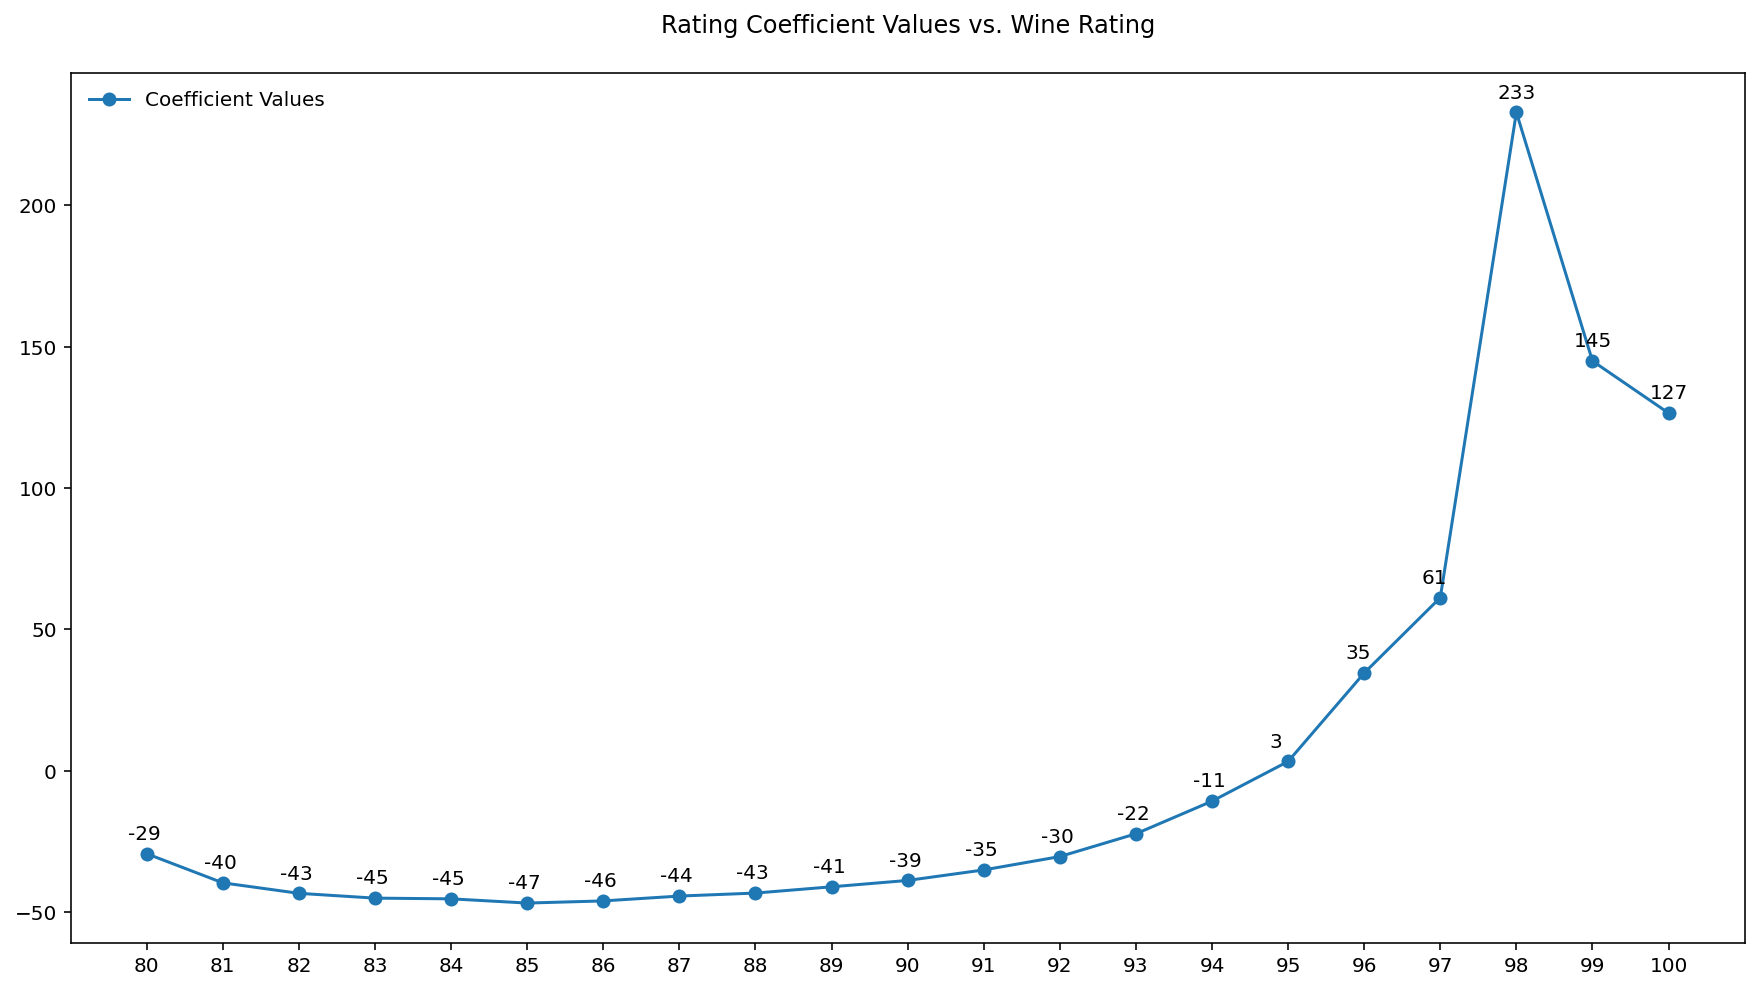

In [72]:
x_rtg = coef_filter("rating",sort_asc=True)['Coefficient'].sort_index().index
y_rtg = coef_filter("rating",sort_asc=True)['Coefficient'].sort_index().values

fig,ax = plt.subplots(figsize=(15,8))
ax.plot(x_rtg,y_rtg,marker="o",label="Coefficient Values")
for x_pos,y_pos in zip(x_rtg,y_rtg):
    plt.annotate(round(y_pos),(x_pos-0.25,y_pos+5))
ax.set_xticks(range(80,101))
ax.set_title("Rating Coefficient Values vs. Wine Rating\n")
plt.legend(frameon=False)
plt.show()

From the above chart we can see a nice relationship formed across the different rating values showing that the majority of ratings are actually detractive from the wine price until we reach 95; quite a high bar before the rating itself is outright additive to a wine's price, according to our model.

It also demonstrates how the model could potentially be overly sensitive to extreme values; the \\$8,500-a-bottle wine was rated 98, and likely could be a contributing factor for that coefficient bucking the otherwise fairly smooth curve.

One hyperparameter of the SGDR model grid-search was to use the Huber loss, rather than just least-squares, to overcome the least-squares methodology's sensitivity to outliers, although this did not result in competitive $R^2$ scores. A different approach could be to set a tolerance level for outliers and pre-filtering the data, although this would introduce explicit domains for where the model could be extrapolated to; perhaps an acceptable limitation to accept given the proportion of wines this would affect.

Next we can look at the coefficients for the different vintages, to see if there were any particularly stand-out years within our dataset.

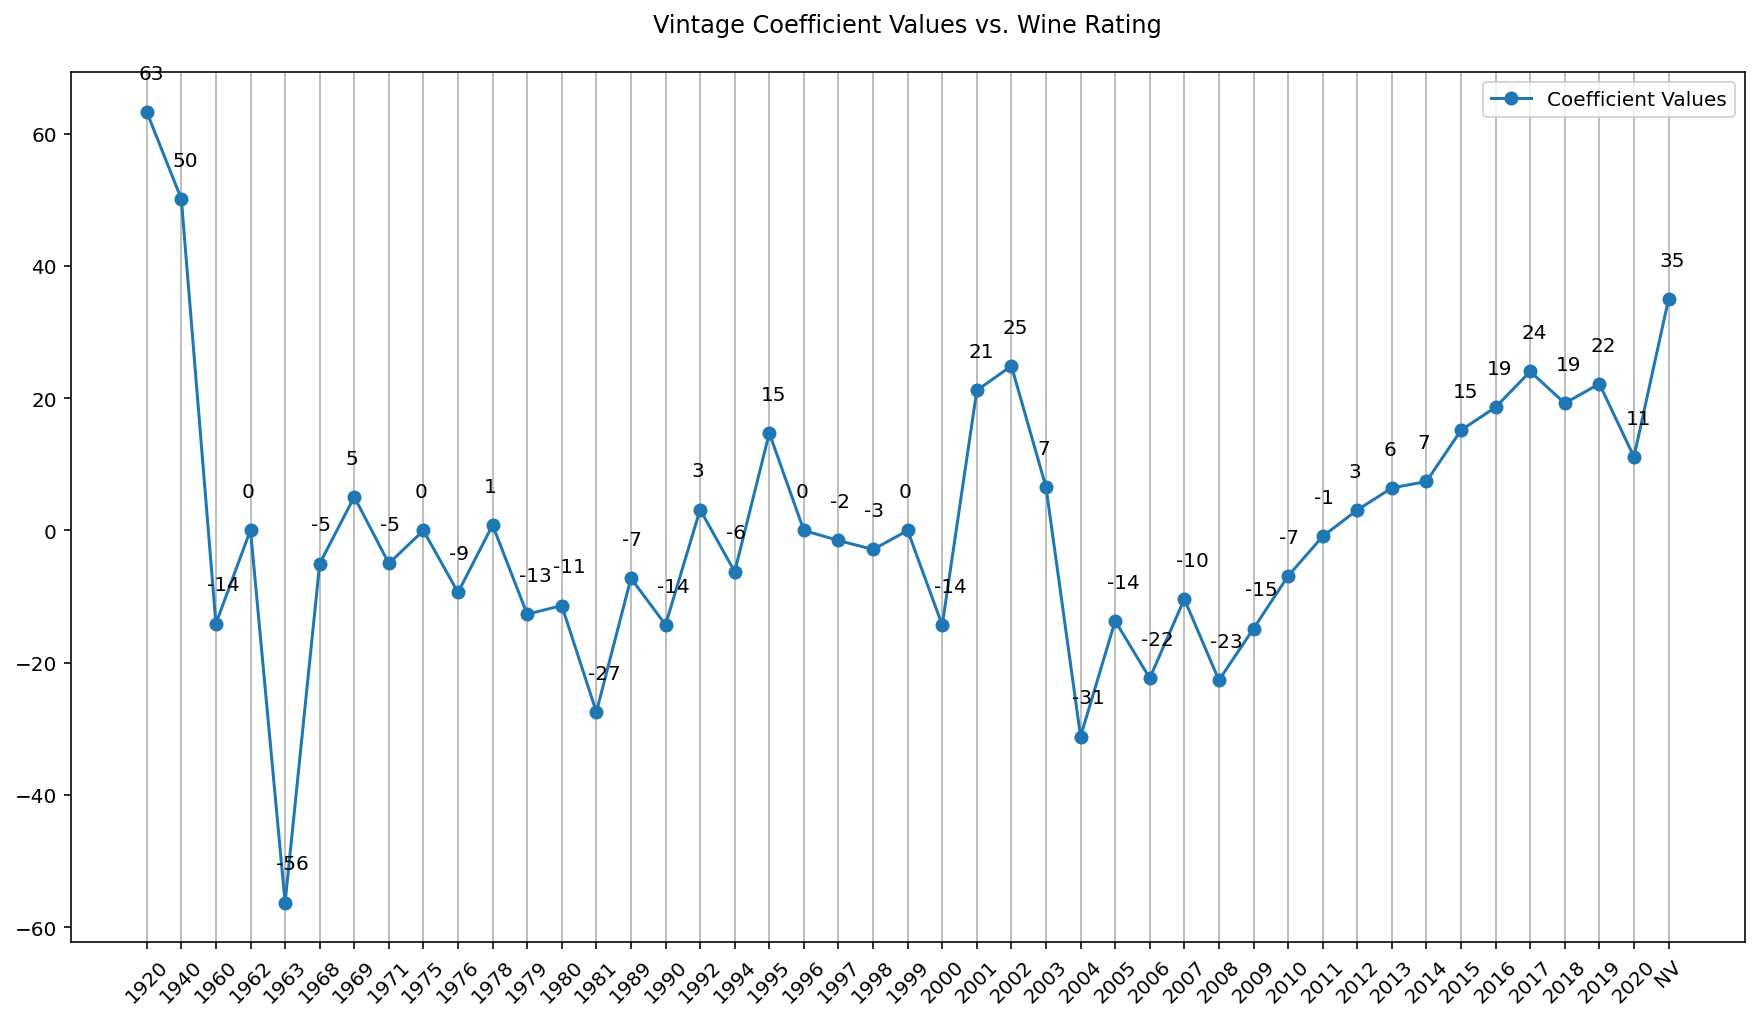

In [73]:
x_rtg = coef_filter("vintage",sort_asc=True)['Coefficient'].sort_index().index
y_rtg = coef_filter("vintage",sort_asc=True)['Coefficient'].sort_index().values

fig,ax = plt.subplots(figsize=(15,8))
ax.plot(x_rtg,y_rtg,marker="o",label="Coefficient Values")
for x_pos,y_pos in enumerate(y_rtg):
    plt.annotate(round(y_pos),(x_pos-0.25,y_pos+5))
ax.set_title("Vintage Coefficient Values vs. Wine Rating\n")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.show()

Here we can see there is a much more mixed bag of coefficients, but it also worth noting that the vast majority of wines within the dataset fall within recent years (see below for a reprint of the table in §2.4.1), and in several cases the much older wines are the only wines of that particular vintage, so the ability of these coefficients to generalise will certainly be challenging.

However, within the more densely populated vintages there is a slight declining trend in coefficient magnitude with increasing age/decreasing vintage.

In [180]:
letter_value_plotter('vintage',sort_by='idx_down',show_chart=False).head(10)

,Count,% of Total,Cumulative %,Min USD,Mean USD,Max USD
NV,1631,3.6,3.6,3,45,8500
2020,32,0.1,3.7,5,14,40
2019,4765,10.6,14.3,5,22,165
2018,13530,30.1,44.4,5,31,999
2017,12017,26.7,71.1,5,42,2950
2016,7687,17.1,88.2,8,52,2950
2015,3135,7.0,95.2,7,58,1500
2014,1054,2.3,97.5,7,56,825
2013,497,1.1,98.6,13,70,300
2012,231,0.5,99.1,12,78,950


#### 3.3.3 Residual Plot
Finally, we can look at a chart of the residuals from our model predictions versus the real values to get a feel for how the residuals are distributed and in which domains our model performs best and worst.

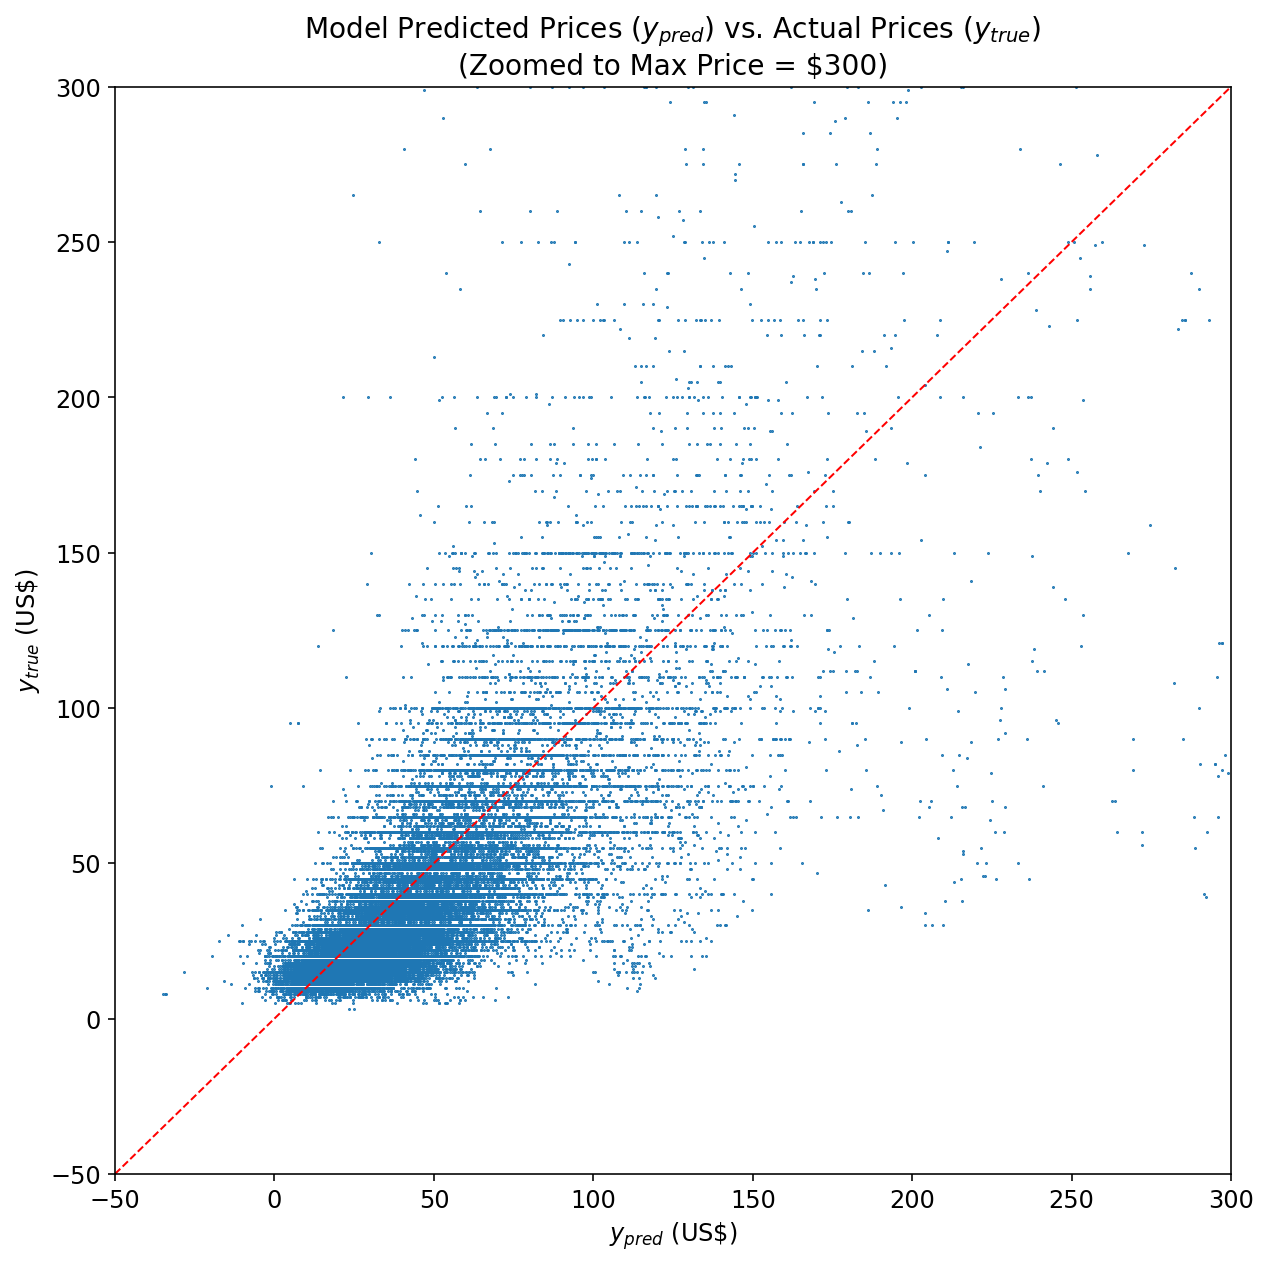

In [75]:
sgd_predict = gsch_sgd.best_estimator_.predict(X)

# To aid visualisation we are zooming into the more densely populated
# domain of <$300 a bottle
lim = 300

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(sgd_predict,y,marker=".",s=1)
ax.plot([-50,lim],[-50,lim],color='r',lw=1,linestyle="--")
ax.set_ylabel("$y_{true}$ (US\\$)",fontsize=12)
ax.set_xlabel("$y_{pred}$ (US\\$)",fontsize=12)
ax.set_xlim(-50,lim)
ax.set_ylim(-50,lim)
ax.set_title("Model Predicted Prices ($y_{pred}$) vs. Actual Prices ($y_{true}$)\n(Zoomed to Max Price = $300)",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Here we can see that while our data are very broadly distributed on the 45&deg; line, there is clear heteroscedasticity present with the range of possible predicted values versus true values widening out considerably in the more sparsely populated, higher-priced wines.

Our model also occasionally predicts negative prices for wine, which is clearly impossible, and also significantly over-estimates wine prices on occasion, perhaps due to some cheaper wines which share common characteristics of wines which are mostly towards the higher-end of prices.

For improvement to our model we would ideally need more information to be able to delineate higher-end, premium wines, as well as limit the predictions made by our model to positive values only.

# 4. Further Areas of Study
### 4.1 Feature Engineering
#### 4.1.1 Polynomial Feature Investigation
Given the non-linear price/rating relationship we noticed in the scatter chart during the EDA process, we can also use the `PolynomialFeatures` preprocessing funcionality to gauge whether applying some transformation to this feature might offer improvements on our modelling.

In [77]:
results = {'Polynomial Degree':[],
           'Train R2 Score'   :[],
           'Test R2 Score'    :[],
           'Average CV Score' :[]}

coefs = []
feat_names = []

# First generate a list of indices where there is no age data and
# remove those observations from both the feature and target datasets.
idx_no_data = wine[wine['age_when_drank'].isna()].index

X_no_std = wine[['rating','bottle_size','age_when_drank']].drop(idx_no_data)
y = wine['price'].drop(idx_no_data)

for degree in tqdm(range(1,51)):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    # Here we subset onto rating, where the non-linear price relationship
    # was visually observed
    X_pf_no_std = pd.DataFrame(pf.fit_transform(X_no_std[['rating']]))
    
    scaler = StandardScaler()
    X_pf = pd.DataFrame(scaler.fit_transform(X_pf_no_std),columns=X_pf_no_std.columns)

    Xtr_pf,Xte_pf,ytr,yte = train_test_split(X_pf,y,test_size=0.2,random_state=29)

    # Instantiate and fit a LinearRegression model including the new polynomials
    linreg_pf = LinearRegression()
    linreg_pf.fit(Xtr_pf,ytr)

    # Cross-validate the model using k=5 folds
    linreg_pf_cv = cross_val_score(linreg,Xtr_pf,ytr,cv=5)
    
    results['Polynomial Degree'].append(degree)
    results['Train R2 Score'].append(round(linreg_pf.score(Xtr_pf,ytr),5))
    results['Test R2 Score'].append(round(linreg_pf.score(Xte_pf,yte),5))
    results['Average CV Score'].append(round(linreg_pf_cv.mean(),5))
    coefs.append(linreg_pf.coef_)
    feat_names.append(pf.get_feature_names(input_features=["Rating"]))

100%|██████████| 50/50 [00:05<00:00,  9.57it/s]


In [78]:
results_df = pd.DataFrame(results)
results_df.set_index("Polynomial Degree",drop=True,inplace=True)

results_df.head(5)

,Train R2 Score,Test R2 Score,Average CV Score
Polynomial Degree,,,
1,0.09796,0.14697,0.15007
2,0.13585,0.20363,0.19997
3,0.14806,0.22805,0.21031
4,0.15121,0.23664,0.21074
5,0.15124,0.23705,0.21011


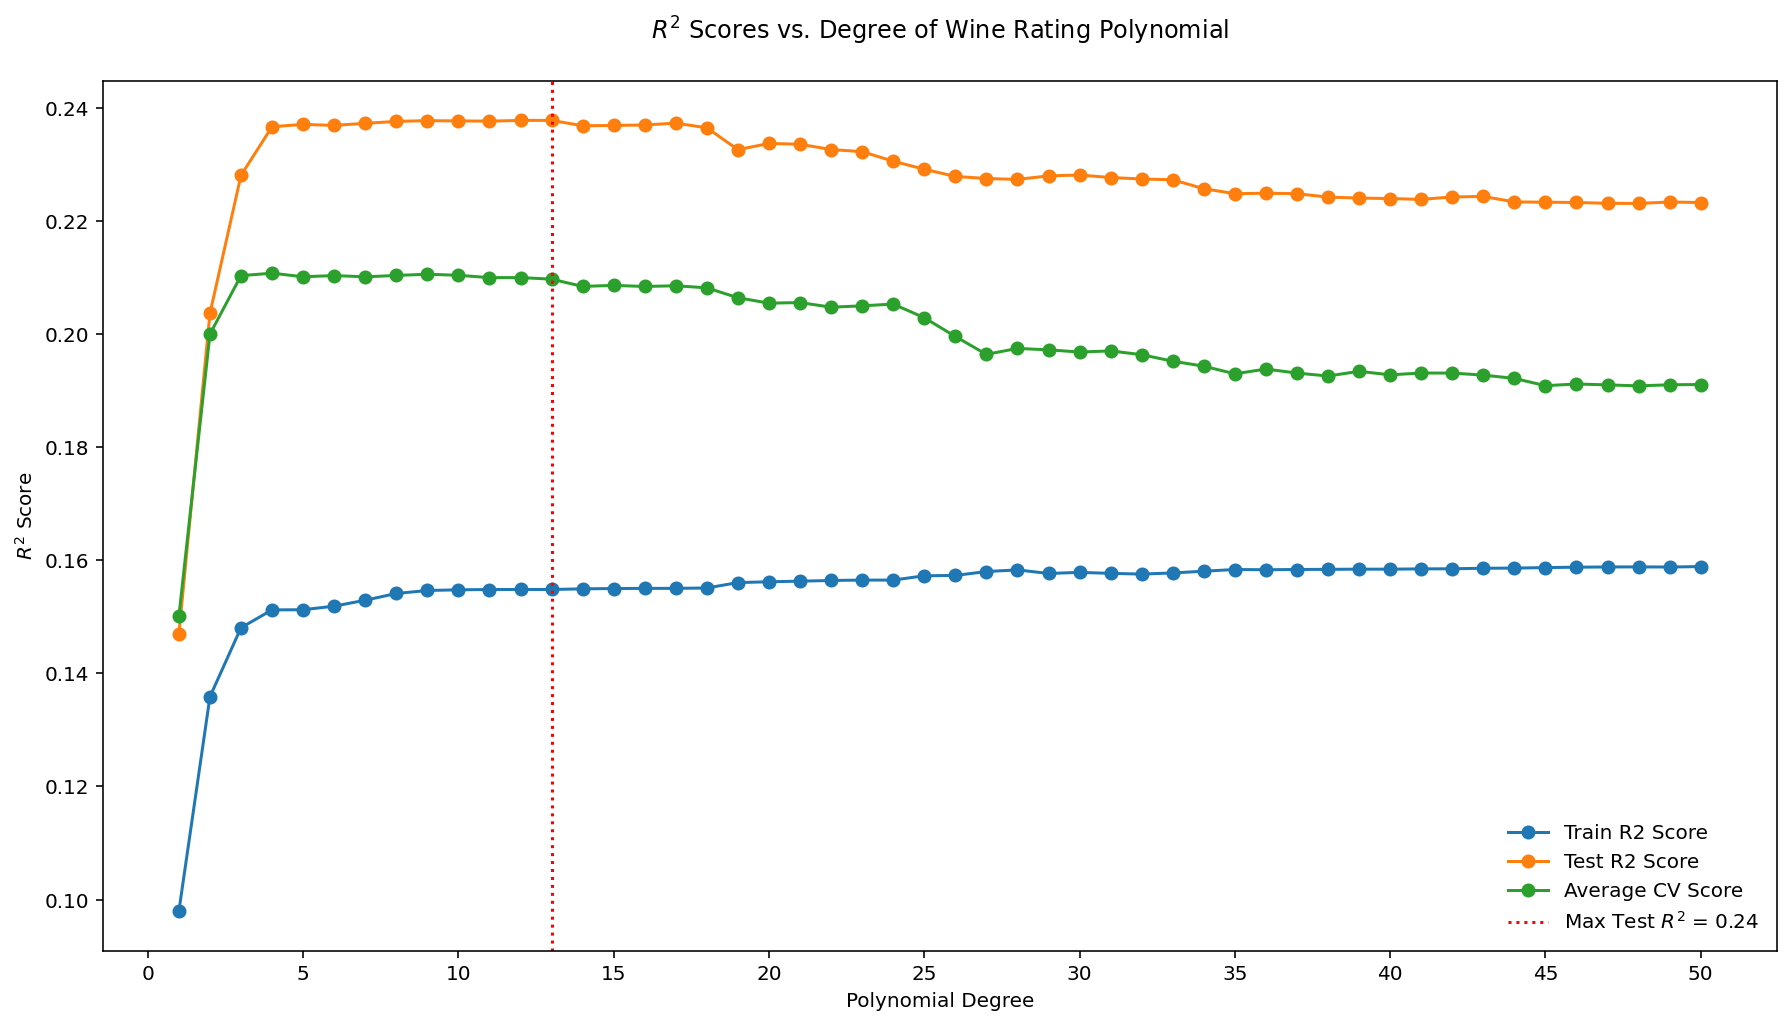

In [79]:
fig,ax = plt.subplots(figsize=(15,8))
results_df.plot(kind="line",ax=ax,marker="o")
max_test = results_df['Test R2 Score'].max() 
idx_max = results_df['Test R2 Score'].idxmax()
ax.axvline(idx_max,color='r',linestyle=":",label=f"Max Test $R^2$ = {round(max_test,2)}")
ax.set_xticks(range(0,55,5))
ax.set_ylabel("$R^2$ Score")
ax.set_title("$R^2$ Scores vs. Degree of Wine Rating Polynomial\n")
plt.legend(frameon=False)
plt.show()

Here we can see the results of testing the rating feature in higher orders versus a simple linear relationship. We can see here that using higher order polynomials has resulted in an improvement of the feature's ability to predict wine price, but with a decrease in cross-validated scores beyond 4th order polynomials, potentially due to the model starting to over-fit.

We can extract the coefficients from the 4th order model from the list we created within the for loop.

In [80]:
linreg_coef_df = pd.DataFrame({'Coefficient':feat_names[3],
                               'Coefficient Strength':coefs[3]})

linreg_coef_df.set_index('Coefficient',drop=True,inplace=True)

linreg_coef_df['AbsCoef'] = abs(linreg_coef_df['Coefficient Strength'])

linreg_coef_df.sort_values('AbsCoef',ascending=False)['Coefficient Strength']. \
                            head().to_frame()

,Coefficient Strength
Coefficient,
Rating^3,-295884.060229
Rating^2,286766.661957
Rating^4,101923.701056
Rating,-92780.834364


Here we do note the positive sign to the quadratic and quartic elements (i.e. the even powers) to our polynomial factorisation of the rating feature, but a negative one on the linear, cubic and quintic elements (i.e. the odd powers).

We can also see that the coefficient sizes themselves are very large, and are likely counterbalancing one another, suggesting that we might be able to improve our model by introducing some regularisation.

##### Polynomial Features With Regularisation
By including a cost function to our coefficients within the model, i.e. via regularisation, we can quickly see if this might improve how well our model can generalise or limit the fairly large absolute values of our coefficients.

Here we have opted for the `ElasticNetCV` function from the sklearn package to regularise our model, allowing it to draw on both the `Lasso` and `Ridge` regularisation functions via the L1 ratio (with 0 = Ridge and 1 = Lasso).

In [ ]:
enet_results = {'Polynomial Degree':[],
                'Train R2 Score':[],
                'Test R2 Score':[],
                'Average CV Score':[],
                'Best Alpha':[],
                'Best L1 Ratio':[]}

enet_coefs = []
enet_feat_names = []

for degree in range(1,21):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    X_pf_no_std = pd.DataFrame(pf.fit_transform(X_no_std[['rating']]))
    
    scaler = StandardScaler()
    X_pf = pd.DataFrame(scaler.fit_transform(X_pf_no_std),columns=X_pf_no_std.columns)

    Xtr_pf,Xte_pf,ytr,yte = train_test_split(X_pf,y,test_size=0.2,random_state=29)

    # Instantiate and fit a ElasticNetCV model including the polynomials
    enet = ElasticNetCV(alphas=np.logspace(-5, 5, 100),
                        l1_ratio=[.1,.3,.5,.7,.9,.95,.99,1],
                        max_iter=10000,
                        n_jobs=-2)
    enet.fit(Xtr_pf,ytr)
    
    # Cross-validate the best model using k=5 folds
    best_enet = ElasticNet(alpha=enet.alpha_,l1_ratio=enet.l1_ratio_,max_iter=10000,warm_start=True)
    best_enet.fit(Xtr_pf,ytr)
    enet_cv = cross_val_score(best_enet,X_pf,y,cv=5)
    
    enet_results['Polynomial Degree'].append(degree)
    enet_results['Train R2 Score'].append(round(enet.score(Xtr_pf,ytr),5))
    enet_results['Test R2 Score'].append(round(enet.score(Xte_pf,yte),5))
    enet_results['Average CV Score'].append(round(enet_cv.mean(),5))
    enet_results['Best Alpha'].append(enet.alpha_)
    enet_results['Best L1 Ratio'].append(enet.l1_ratio_)
    enet_coefs.append(best_enet.coef_)
    enet_feat_names.append(pf.get_feature_names(input_features=['Rating']))

# Save the output of the ElasticNet model using joblib
joblib.dump(enet_results,"enet_results")
joblib.dump(enet_coefs,"enet_coefs")
joblib.dump(enet_feat_names,"enet_feat_names")

In [81]:
# Recover the output of the ElasticNet model using joblib
enet_results = joblib.load("assets/enet_results")
enet_coefs = joblib.load("assets/enet_coefs")
enet_feat_names = joblib.load("assets/enet_feat_names")

In [82]:
enet_results_df = pd.DataFrame(enet_results)
enet_results_df.set_index("Polynomial Degree",drop=True,inplace=True)
enet_results_df['CV Improvement'] = enet_results_df['Average CV Score']-results_df['Average CV Score']
enet_results_df.head(5)

,Train R2 Score,Test R2 Score,Average CV Score,Best Alpha,Best L1 Ratio,CV Improvement
Polynomial Degree,,,,,,
1,0.09796,0.14698,0.12813,0.003352,0.1,-0.02194
2,0.13582,0.20358,0.17216,0.000013,0.5,-0.02781
3,0.13643,0.20467,0.17212,0.000010,1.0,-0.03819
4,0.13715,0.20597,0.17285,0.000010,1.0,-0.03789
5,0.13814,0.20778,0.17398,0.000010,1.0,-0.03613


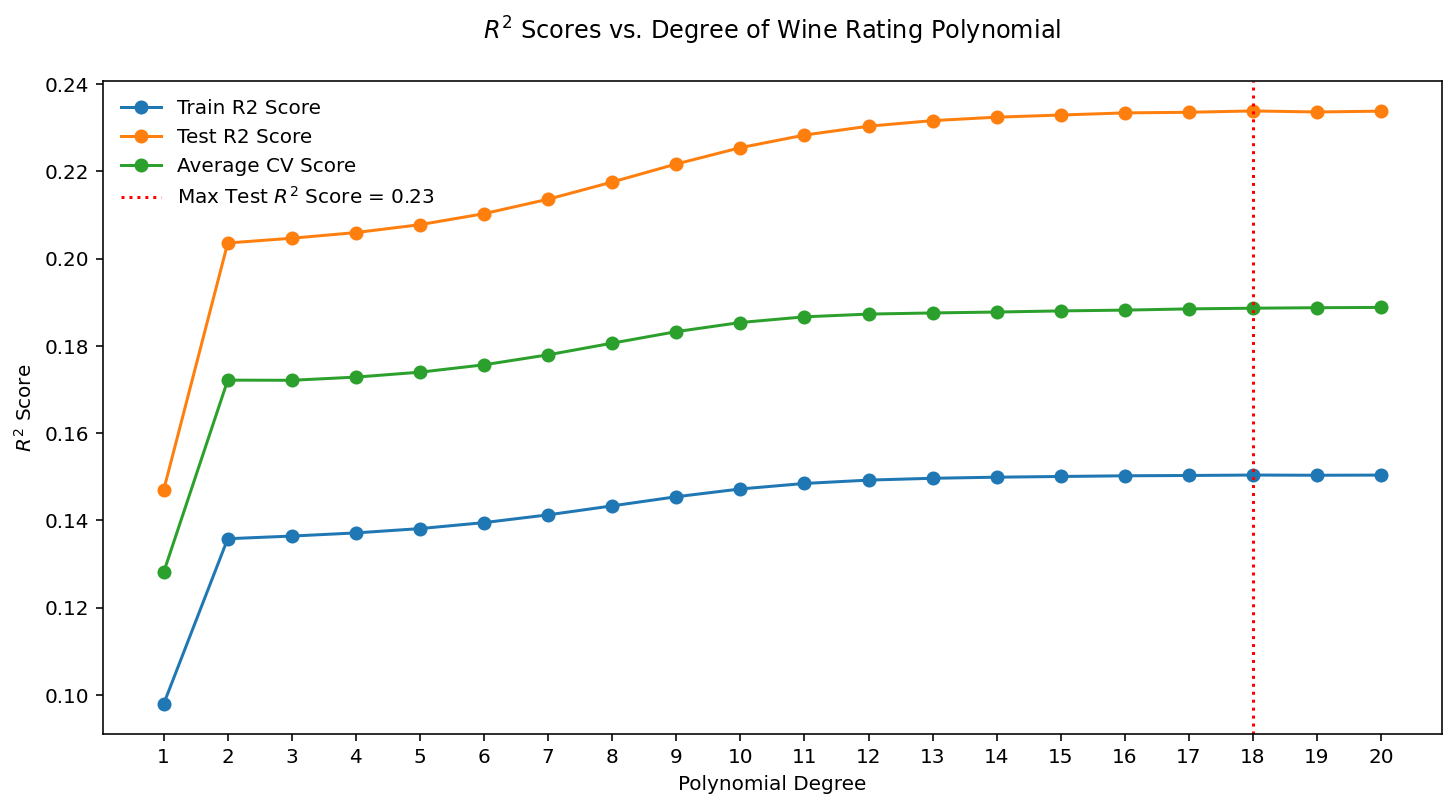

In [83]:
fig,ax = plt.subplots(figsize=(12,6))
enet_results_df[["Train R2 Score","Test R2 Score","Average CV Score"]].plot(kind="line",ax=ax,marker="o")
ax.set_ylabel("$R^2$ Score")
ax.set_title("$R^2$ Scores vs. Degree of Wine Rating Polynomial\n")
max_test = enet_results_df['Test R2 Score'].max() 
idx_max = enet_results_df['Test R2 Score'].idxmax()
ax.axvline(idx_max,color='r',linestyle=":",label=f"Max Test $R^2$ Score = {round(max_test,2)}")
ax.set_xticks(range(1,21))
plt.legend(frameon=False)
plt.show()

We can extract the top 10 most significant coefficients from this model to see the relative strengths after regularisation.

In [84]:
enet_coef_df = pd.DataFrame({'Coefficient': enet_feat_names[-1],
                             'Coefficient Strength' : enet_coefs[-1]})

enet_coef_df.set_index('Coefficient',drop=True,inplace=True)

enet_coef_df['AbsCoef'] = abs(enet_coef_df['Coefficient Strength'])

enet_coef_df.sort_values('AbsCoef',ascending=False)['Coefficient Strength']. \
                         head(10).to_frame()

,Coefficient Strength
Coefficient,
Rating^20,37.216518
Rating^19,27.286469
Rating,18.083046
Rating^18,17.757337
Rating^12,-14.284261
Rating^13,-13.446855
Rating^11,-13.291336
Rating^10,-11.146005
Rating^14,-10.498676


Here we can see how regularisation has limited the absolute size of the coefficients themselves given the introduction of a cost function, but with a reduced test data $R^2$ score, as well as greatly increased computational time; the standard linear regression took a few seconds to calculate the first 50 order polynomial features, whereas optimising/regularising to 20 orders took around 10 minutes.

Both models, with and without regularisation, were capable of going to high degrees of polynomial factorisation without drastically over-fitting the model. This could potentially be due to the fact that the ratings vs. price relationship could potentially be better described by a different type of equation similar to the one that the high-order polynomial is trying to approximate. It is worth mentioning, as before, that the data here are also ordinal categorical variables, rather than the quasi-continous nature we are using here for the sake of this investigation, and therefore these models are likely fitting to the mean values within each category, rather than a continuous distribution of data.

#### 4.1.2 Fitting an Exponential Model of Rating vs. Price
Given the results from the polynomial factorisation above I also tried to fit a simple exponential model of price versus rating. This was to investigate whether the exponential relationship seemingly apparent in the letter value plots in the EDA section could in fact be a more simple relationship to model, compared to the 20-order polynomial features.

We first define a generic exponential function to define a wine's price of the form
<br><br>
<center>$f(x) = ae^{b(x-c)} + d$</center>
<br>
where $a$, $b$, $c$ and $d$ are the variable parameters to modify the generic $e^x$ distribution, with $x$ being the wine rating, to fit our data.

Utilising the scipy package's `curve_fit()` functionality, we can run a least squares fitting model with our custom, nonlinear function.

In [86]:
# Define our generic exponential function to call during fitting
def exp_price(x, a, b, c, d):
    return a*np.exp(b*(x-c))+d

In [87]:
# Rough starting point for the curve_fit() function; these values
# were achieved through a quick, visual trial and error
init_vals = [50,0.2,90,0]

# Remove any price = NaN values
X_logfn = wine['rating']
y_logfn = wine['price']

# Train-test split the data
X_logfn_tr,X_logfn_te,y_logfn_tr,y_logfn_te = train_test_split(X_logfn,y_logfn,
                                                               test_size=0.20,
                                                               random_state=29,
                                                               stratify=X_logfn)

# Extract the optimum values, popt, minimising the least-squares
popt,pcov = curve_fit(f=exp_price,xdata=X_logfn_tr,ydata=y_logfn_tr,p0=init_vals)

# Set a,b,c,d from the function above equal to the popt values from above
logfn_a = popt[0]
logfn_b = popt[1]
logfn_c = popt[2]
logfn_d = popt[3]

logfn_vals = exp_price(X_logfn,a=logfn_a,b=logfn_b,c=logfn_c,d=logfn_d)

/Users/jacklodge/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [88]:
print("Fitted Coefficient Values")
print(25*"-")
print(f"a = {logfn_a}\nb = {logfn_b}\nc = {logfn_c}\nd = {logfn_d}")

Fitted Coefficient Values
-------------------------
a = 45.032496137828396
b = 0.3330125641080183
c = 93.42600156091193
d = 20.07860280698374


Which approximately corresponds to a fitted model of the form
<br><br>
<center>$f(x) = 45.03$ $e$ $^{0.33}$ $^{(x-93.43)} + 20.08$</center>
<br>

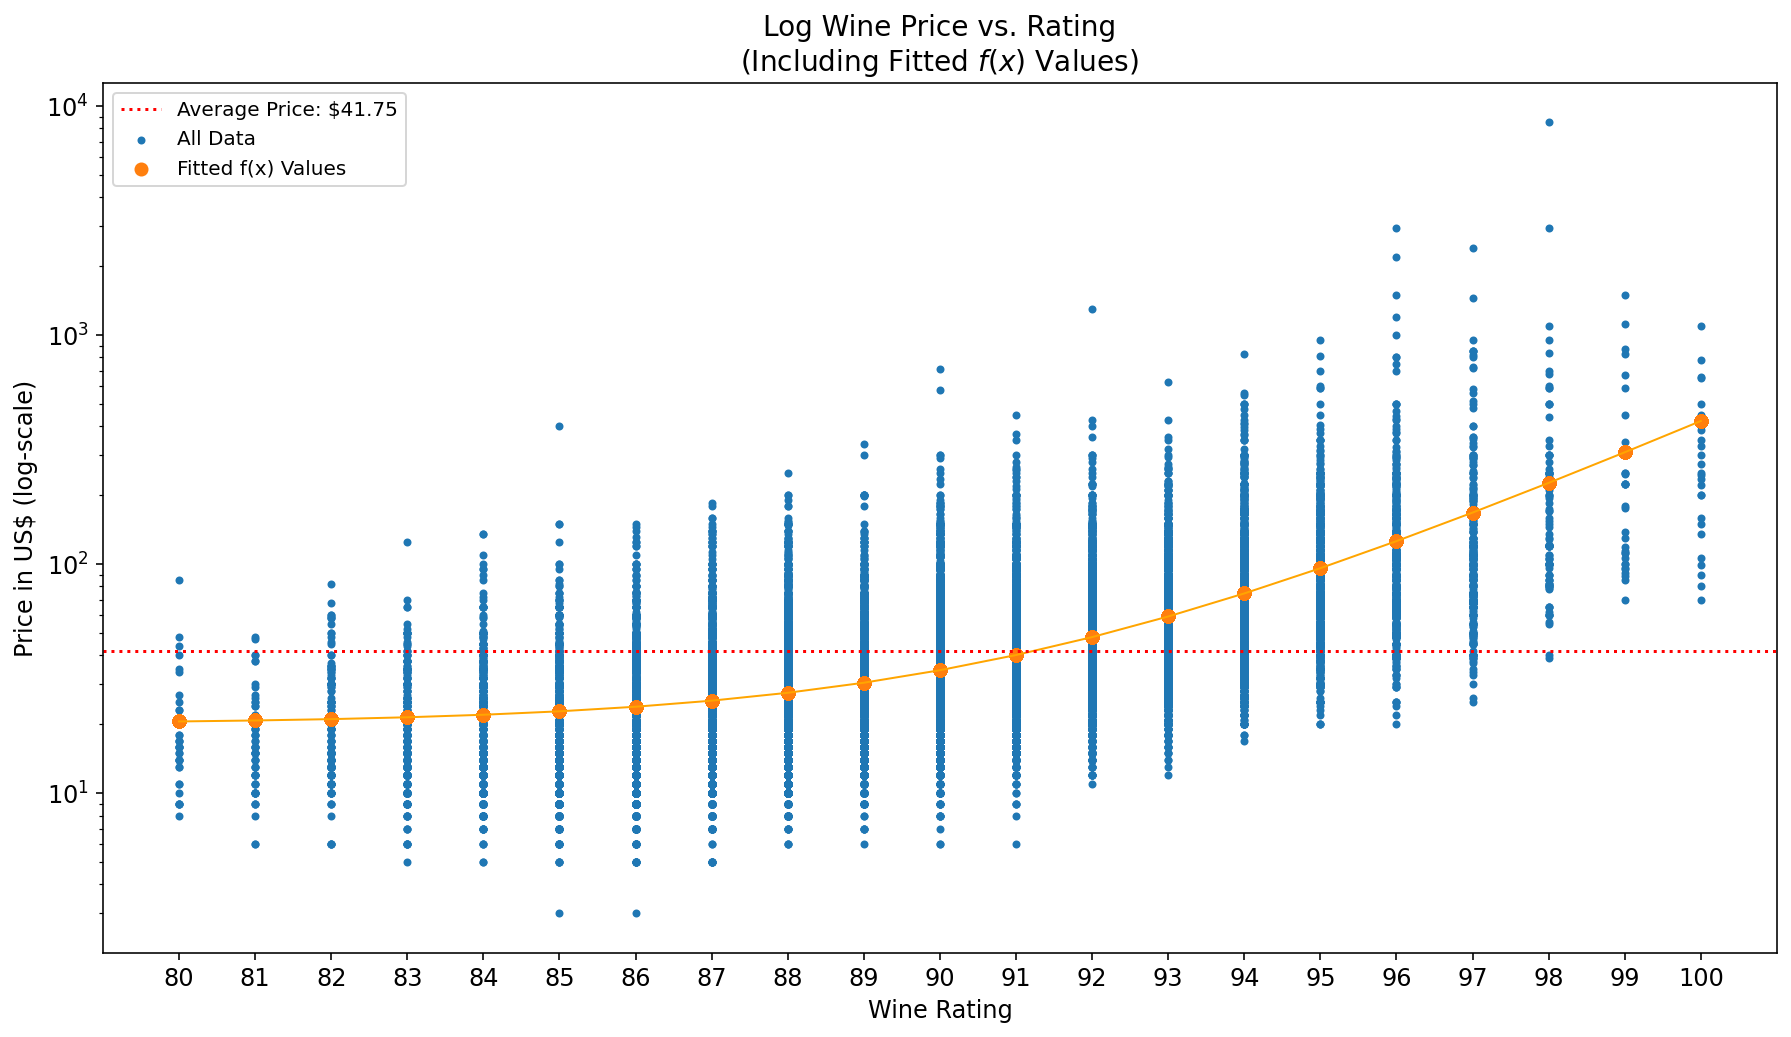

In [103]:
# Inspecting the fitted model visually
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(X_logfn,
           y_logfn,
           marker='.',label="All Data")
# To draw the fitted line through the data points
X_VALS = X_logfn.value_counts().sort_index().index
Y_VALS = logfn_vals.value_counts().sort_index().index
ax.plot(X_VALS,Y_VALS,lw=1,color='orange')
ax.scatter(X_logfn,
           logfn_vals,
           marker="o",label="Fitted f(x) Values")
ax.set_yscale('log')
ax.set_title("Log Wine Price vs. Rating\n(Including Fitted $f(x)$ Values)",fontsize=14)
ax.axhline(y_logfn.mean(),color='red',linestyle=':',
           label=f'Average Price: ${round(y_logfn.mean(),2)}')
ax.set_xticks(range(80,101))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel("Wine Rating",fontsize=12)
ax.set_ylabel("Price in US\\$ (log-scale)",fontsize=12)
plt.legend()
plt.show()

In [90]:
# Now to calculate the R2 value for the fitted logarithmic model
logfn_vals_tr = exp_price(X_logfn_tr,a=logfn_a,b=logfn_b,c=logfn_c,d=logfn_d)
logfn_vals_te = exp_price(X_logfn_te,a=logfn_a,b=logfn_b,c=logfn_c,d=logfn_d)

# Calculate RSS and TSS values for the training data
logfn_TSS_tr = sum((y_logfn_tr-y_logfn_tr.mean())**2)
logfn_RSS_tr = sum((y_logfn_tr-logfn_vals_tr)**2)

# Calculate RSS and TSS values for the test data
logfn_TSS_te = sum((y_logfn_te-y_logfn_te.mean())**2)
logfn_RSS_te = sum((y_logfn_te-logfn_vals_te)**2)

logfn_r2_tr = 1 - logfn_RSS_tr/logfn_TSS_tr
logfn_r2_te = 1 - logfn_RSS_te/logfn_TSS_te

print(f"Train R2:\t{logfn_r2_tr}")
print(f"Test  R2:\t{logfn_r2_te}")

Train R2:	0.15418232937766674
Test  R2:	0.2210599501696442


In [92]:
# And repeat this process to obtain cross-validated scores using KFold() splits
log_kf = KFold(n_splits=5,shuffle=True,random_state=29)

logfn_tr_r2 = []
logfn_te_r2 = []
a_b_c_d = []

for train_idx,test_idx in log_kf.split(X=X_logfn_tr,y=y_logfn_tr):
    X_logfn_tr_i = X_logfn_tr.iloc[train_idx]
    y_logfn_tr_i = y_logfn_tr.iloc[train_idx]
    
    X_logfn_te_i = X_logfn_tr.iloc[test_idx]
    y_logfn_te_i = y_logfn_tr.iloc[test_idx]
    
    popt_i,pcov_i = curve_fit(f=exp_price,
                              xdata=X_logfn_tr_i,
                              ydata=y_logfn_tr_i,
                              p0=init_vals)
    logfn_a_i = popt_i[0]
    logfn_b_i = popt_i[1]
    logfn_c_i = popt_i[2]
    logfn_d_i = popt_i[3]

    # Calculate expected values from each fitted model
    logfn_vals_tr_i = exp_price(X_logfn_tr_i,a=logfn_a_i,b=logfn_b_i,c=logfn_c_i,d=logfn_d_i)
    logfn_vals_te_i = exp_price(X_logfn_te_i,a=logfn_a_i,b=logfn_b_i,c=logfn_c_i,d=logfn_d_i)
    
    # Calculate RSS and TSS values for each fold
    logfn_TSS_tr_i = sum((y_logfn_tr_i-y_logfn_tr_i.mean())**2)
    logfn_RSS_tr_i = sum((y_logfn_tr_i-logfn_vals_tr_i)**2)

    logfn_TSS_te_i = sum((y_logfn_te_i-y_logfn_te_i.mean())**2)
    logfn_RSS_te_i = sum((y_logfn_te_i-logfn_vals_te_i)**2)

    # Calculate R2 values for each fold
    logfn_r2_tr_i = 1 - logfn_RSS_tr_i/logfn_TSS_tr_i
    logfn_r2_te_i = 1 - logfn_RSS_te_i/logfn_TSS_te_i

    # Store the R2 values for each fold iteration
    logfn_tr_r2.append(logfn_r2_tr_i)
    logfn_te_r2.append(logfn_r2_te_i)
    
    # Store the optimised coefficient values
    a_b_c_d.append((logfn_a_i,logfn_b_i,logfn_c_i,logfn_d_i))
sleep(1)
print(f"Average CV\nTrain R2 Score:\t{sum(logfn_tr_r2)/len(logfn_tr_r2)}")
print(f"Test  R2 Score:\t{sum(logfn_te_r2)/len(logfn_te_r2)}")

Average CV
Train R2 Score:	0.16591699847060454
Test  R2 Score:	0.22529379574647884


The simple exponential model offers significant improvement in execution time versus the optimised, regularised model and with comparable $R^2$ scores on unseen test data - although given the comparative computational intensity this is not overly surprising.

Given the common trend seen and known in the high-end wine industry in regards to supply and demand as mentioned earlier the fact that this exponential relationship can be modelled well should not be overly surprising, and is more easily understandable, in my view, than high-order polynomial regressions; a high $R^2$ score ultimately is not the only consideration to be taken into account. The value in model comprehensibility, while more qualitative, is also important, and perhaps even moreso depending on the target audience.

Finally, the simple linear regression fits of higher order polynomials can be seen to stabilise as we increase degrees of factorisation, suggesting that our linear polynomial model could simply be beginning to approximate a similar exponential relationship in the way that a Taylor approximation would look to accomplish.

The next step would be to apply this model as a transformation to the rating variable ahead of modelling to assess whether it could result in superior $R^2$ scores overall - more to come on this area later.

### 4.2 Natural Language Processing
We can also utilise natural language processing (NLP) techniques to create new columns using the body of text given for each wine in its review.
#### 4.2.1 Count Vectorizer
A reminder of the settings used for the column transformer used in §3.2.1 is shown below, where the `CountVectorizer()` is chosen to include the 25,000 most commonly occurring n-grams of length 1 and 2 (i.e. individual words and pairs of words) within all of the reviews, and converted each review into a sparse array where the frequency of an n-gram appearing in a given review is recorded, with the absence of any term represented by a zero.
```python
cvec = CountVectorizer(ngram_range=(1,2),stop_words=stopwords,max_features=25000)
one_hot = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
scaler = StandardScaler(with_mean=True)

# Transform the text, categorical and numerical fields using the column transformer
col_trans = ColumnTransformer([
        ('wine_text',cvec,'wine_text'), # For NLP
    
        ('wine_categorical',one_hot,    # Generate a sparse matrix for categorical features
             ['rating', # Return to using rating as a categorical feature
              'reviewer',
              'variety',
              'country',
              'region_all',
              'winery',
              'category',
              'vintage']),
    
        ('wine_numerical',scaler, # Centre and standardise the numerical features
             ['bottle_size',
              'age_when_drank'])
        ],
    remainder='drop',
    sparse_threshold=0.3)

wine_enc = col_trans.fit_transform(wine)
```
This essentially converts our raw-text array into a machine-readable array, allowing us to utilise similar machine-learning and model-fitting techniques to before, when we instead of before when had a sparse array of categorical features, we now have a sparse array of different words used within each wine's review.

In [57]:
# Extract the first 25,000 columns from the wine_enc, the output from the column-
# transformer in §3.2.1 Additional Data Preparation, and use column headings from
# the .get_feature_names() method of the count-vectorizer.
review_words = col_trans.named_transformers_['wine_text'].get_feature_names()
review_df = pd.DataFrame(wine_enc[:,:25000],columns=review_words)

review_df.head()

,00,000,000 feet,10,10 cabernet,10 grenache,10 malbec,10 merlot,10 months,10 mourvèdre,...,émilion ripe,éric,éric jöel,île,île de,ökonomierat,ökonomierat rebholz,österreich,österreichischer,österreichischer sekt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By summing across all the rows of the above table, we can get an idea for the most and least frequently occurring n-grams of length 1 and 2 within our dataset (i.e. single and paired words).

In [58]:
review_words_sum = review_df.sum(axis=0)

In [59]:
review_words_sum.to_frame(name='Top 10 Words').sort_values('Top 10 Words',ascending=False).head(10)

,Top 10 Words
fruit,15576.0
red,14295.0
tannins,13440.0
acidity,13110.0
black,12534.0
nose,12026.0
cherry,11118.0
finish,10807.0
ripe,10421.0
valley,8738.0


In [60]:
review_words_sum.to_frame(name='Bottom 10 Words').sort_values('Bottom 10 Words',ascending=True).head(10)

,Bottom 10 Words
00,10.0
months large,10.0
pretty raspberry,10.0
track,10.0
months soften,10.0
months stainless,10.0
buttery apple,10.0
bages,10.0
freshness full,10.0
toulouse,10.0


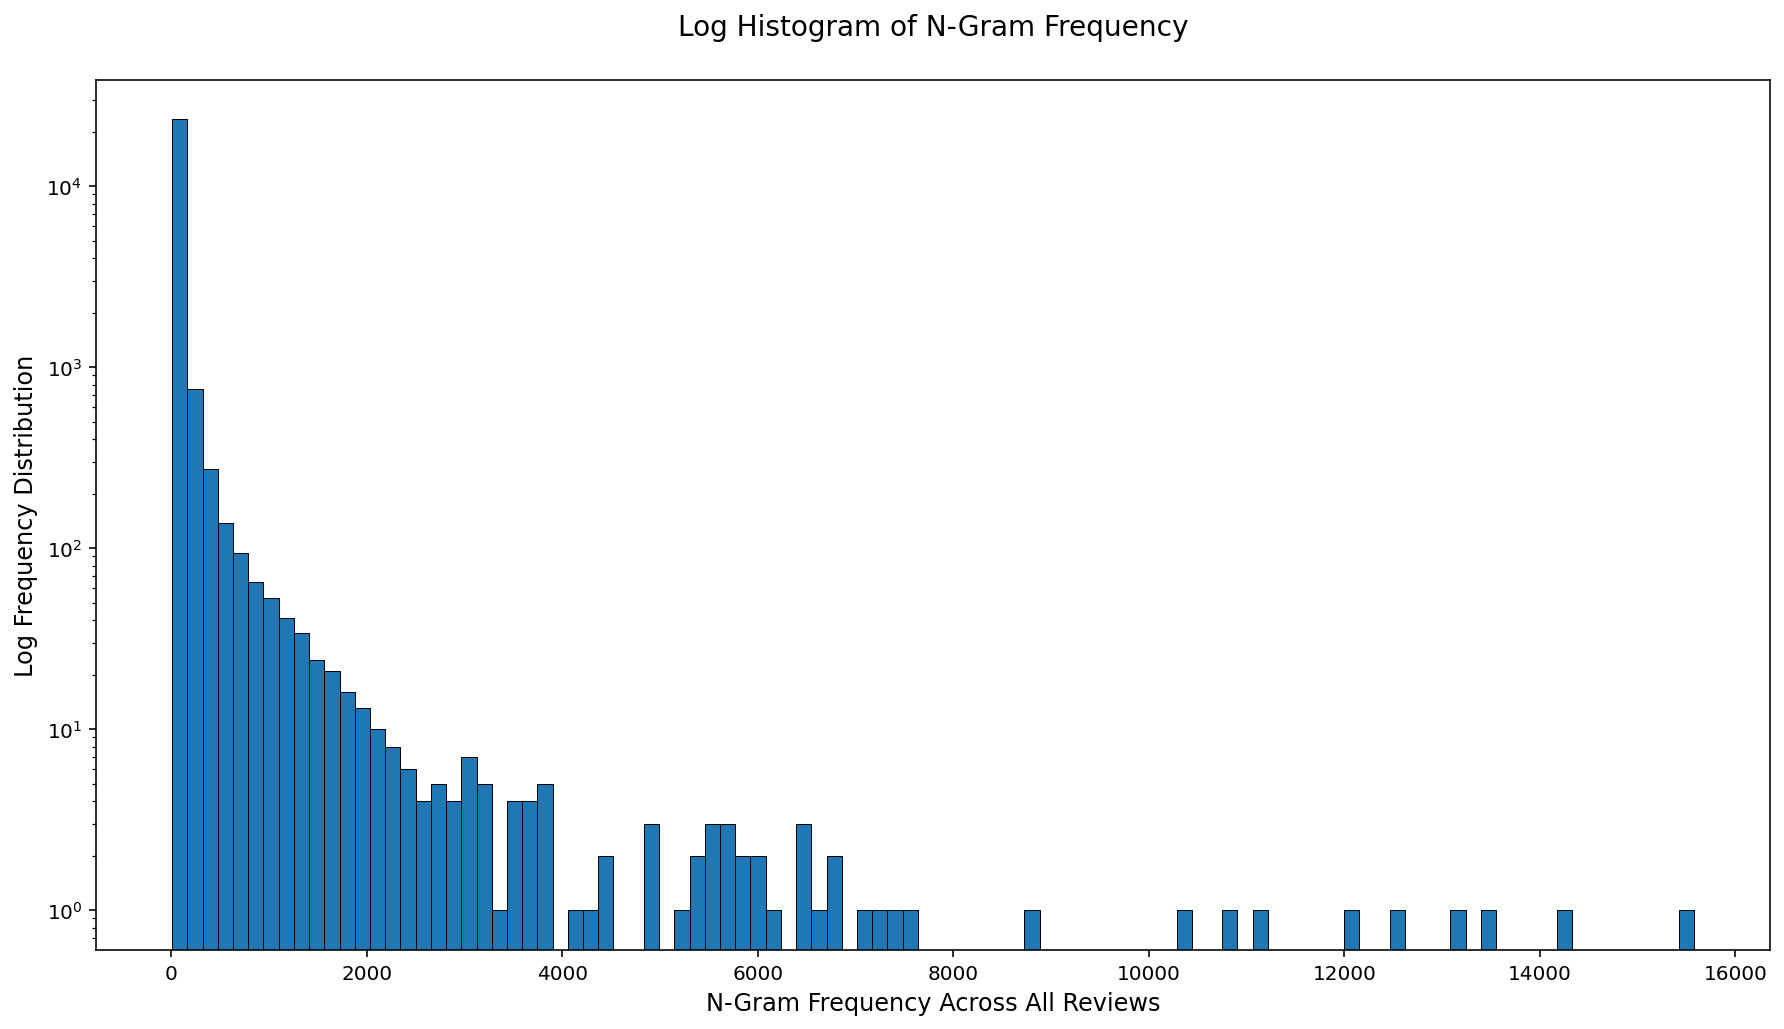

In [61]:
fig,ax = plt.subplots(figsize=(15,8))
ax.hist(review_words_sum,bins=100,edgecolor='black',lw=0.5)
ax.set_ylabel('Log Frequency Distribution',fontsize=12)
ax.set_xlabel('N-Gram Frequency Across All Reviews',fontsize=12)
ax.set_title('Log Histogram of N-Gram Frequency\n',fontsize=14)
plt.yscale('log')
plt.show()

As we can see, there is a great amount of variation between the frequency of certain words appearing within the most-common 25,000 n-grams, and from the histogram we can see that there is a large concentration of words appearing relatively infrequently across all the reviews.

We can now try to use this sparse matrix of n-gram frequencies to fit using the same SGDR base estimator that we used in the grid-search across the numercial and categorical features.

Our initial expectation is that this could well result in an over-fitted model, given the number of unique (or at least infrequently used) n-grams within the above table.

In [62]:
X = review_df
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

sgdr_nlp = SGDRegressor(penalty='l1',
                        max_iter=1000,
                        early_stopping=True,
                        n_iter_no_change=10)

sgdr_nlp.fit(Xtr,ytr)
best_nlp_cv = cross_val_score(sgdr_nlp,Xtr,ytr,cv=5,n_jobs=-1)

# Save the SGDR NLP model using joblib
joblib.dump(sgdr_nlp,"assets/sgdr_nlp")
joblib.dump(best_nlp_cv,"assets/best_nlp_cv")

['assets/best_nlp_cv']

In [63]:
# Reload the SGDR NLP model using joblib if necessary
# If reloading, y and X also will need to be redefined as above

X = review_df
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

sgdr_nlp = joblib.load("assets/sgdr_nlp")
best_nlp_cv = joblib.load("assets/best_nlp_cv")

In [64]:
print(f"All CV Scores: {best_nlp_cv}")
print(f"Avg CV Score:  {best_nlp_cv.mean()}")

All CV Scores: [0.33300797 0.10410541 0.06777772 0.03713697 0.2301285 ]
Avg CV Score:  0.15443131521736914


In [65]:
# Calculate the R2 score for the training data
cvec_train = sgdr_nlp.score(Xtr,ytr)
print(cvec_train)

0.5682325997881472


In [66]:
# Calculate the R2 score for test data, unseen by the model
cvec_test = sgdr_nlp.score(Xte,yte)
print(cvec_test)

0.08485462009486833


As we can see from the train, cross-validated and test scores above, the model is potentially exhibiting some over-fitting, as we might have expected, likely due to the sparse matrix attempting to solve simply for each unique bottle rather than by identifying common trends.

However, the test $R^2$ score is already showing some promising signs that we might be able to explain at least some of the price of wines 

We can investigate this assumption by looking at the coefficients within the fitted SGDR model utilising NLP techniques, but first let us look at the intercept to understand the base from which our coefficients will be assembling a final wine-price from.

In [67]:
print(f"Intercept =\t{sgdr_nlp.intercept_[0]}")
print(f"Mean Price =\t{wine['price'].mean()}")
print(f"Median Price =\t{wine['price'].median()}")

Intercept =	22.31480132926901
Mean Price =	41.74910601248251
Median Price =	30.0


This value of around $24 sits below the mean and median values from our dataset, also shown above.

Next, we can look at the coefficients themselves.

In [68]:
nlp_coef = pd.DataFrame(sgdr_nlp.coef_.reshape(1,-1),columns=review_df.columns,index=['Coefficient']).T
nlp_coef['Count'] = review_words_sum

In [69]:
# Extract the top-10 most positive coefficients and count
nlp_coef.sort_values('Coefficient',ascending=False).head(10)

,Coefficient,Count
extraordinary,254.835696,23.0
stunningly,204.673525,12.0
texture like,193.138500,12.0
full life,183.903257,12.0
crystal,174.593313,19.0
quinta crasto,168.057451,15.0
liquid,167.380792,24.0
acidity wood,166.480215,18.0
tawnies,164.190036,14.0
date,155.375868,40.0


In [70]:
# Extract the top-10 most negative coefficients and count
nlp_coef.sort_values('Coefficient',ascending=True).head(10)

,Coefficient,Count
estate bottled,-53.195115,297.0
dried fruits,-50.309497,24.0
sandeman,-45.965566,10.0
years old,-43.482120,101.0
old vines,-41.454769,517.0
old vine,-40.188348,270.0
old port,-35.150200,10.0
kopke,-32.474604,14.0
oldest vines,-32.430442,32.0
aged tawny,-31.668633,11.0


In [81]:
# Calculate the % of reviews that an n-gram with a count of 12 appears in
print(f"{round((12/wine['price'].shape[0])*100,4)}%")

0.0267%


As we can see from the relative size of the coefficients, particularly in the positive ones, some of the n-grams associated with largest coefficients occur very infrequently within the dataset. Even assuming that the count as shown above was equal to the number of reviews the n-gram appeared in (which is not necessarily true, as a n-gram can be repeated within a single review) we can see how rare some of these appearances really are; the n-gram "stunningly" appears, at best, in just 0.0267% of reviews.

Ideally we need a way to reduce the impact of incredibly common phrases, like "fruit", while also avoiding overly specific phrases, which could lead to model over-fitting.

#### 4.2.2 Term Frequency - Inverse Document Frequency (TF-IDF)
One way we can look to generate a sparse matrix representative of our review texts, while correcting for some of the problems mentioned in §4.2.1, is to implement a different type of NLP vectorizer that gives weighting to the relative frequency that a term appears within all the reviews.

Instead of simply taking the top 25,000 most commonly used features, TF-IDF takes into account how often a word appears in a single body of text (its term frequency) and inverse scales it by how commonly found that word is within all the bodies of text (its document frequency).

For example, in our ~43,000 reviews we can see from the output of simply counting the words that there are 15,576 mentions of the word "fruit", a word so commonly used we would likely make the assumption that its predictive power may well be limited; if it appears so frequently then how delineating is the presence of that word likely to be? This is the benefit of using the TF-IDF methodology.

However, given our desire to filter out words that are _too_ specific (e.g. the name of the wine, as seen in the original model with "Quinta do Crasto") we can also implement minimum and maximum document frequency filters to remove words that are too unique and too common, respectively.

In [72]:
# Instantiate a TF-IDF vectorizer with at most 25,000 features, removing any terms occurring in less
# than 0.5% of reviews or more than 99.5% of reviews; the latter of which we know is redundant given our
# top word (fruit) only appearing ~15,000 times across ~43,000 reviews, but is included for completeness
tfid = TfidfVectorizer(ngram_range=(1,2),stop_words=stopwords,min_df=0.005,max_df=0.995)
tfidf_df = pd.DataFrame(tfid.fit_transform(wine['wine_text']).todense(),columns=tfid.get_feature_names())
tfidf_df.head()

,10,100,100 varietal,12,15,20,25,30,40,50,...,ynez,ynez valley,young,youth,youthful,zest,zesty,zinfandel,zippy,émilion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312103
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Here we can see that instead of simply a count of the n-grams within the reviews being made, the values have been scaled according to their term frequency and inverse document frequency, resulting in float values rather than integers.

Once again, we can sum across this table to see which words hold the highest value when scaling in this way.

In [73]:
review_words_sum = tfidf_df.sum(axis=0)

In [74]:
review_words_sum.to_frame(name='Top 10 Words').sort_values('Top 10 Words',ascending=False).head(10)

,Top 10 Words
fruit,1479.312899
red,1438.793907
acidity,1330.129150
black,1314.499906
tannins,1292.533535
ripe,1192.279989
nose,1189.653749
cherry,1169.924510
finish,1143.226361
valley,1002.428590


In [75]:
review_words_sum.to_frame(name='Bottom 10 Words').sort_values('Bottom 10 Words',ascending=True).head(10)

,Bottom 10 Words
tannins leave,53.315744
cruz mountains,53.428115
knit,54.900886
medium weight,55.148679
santa cruz,55.311108
cool climate,55.573829
lemon drop,56.428905
santa maria,56.434691
dried black,56.518451
lithe,56.773470


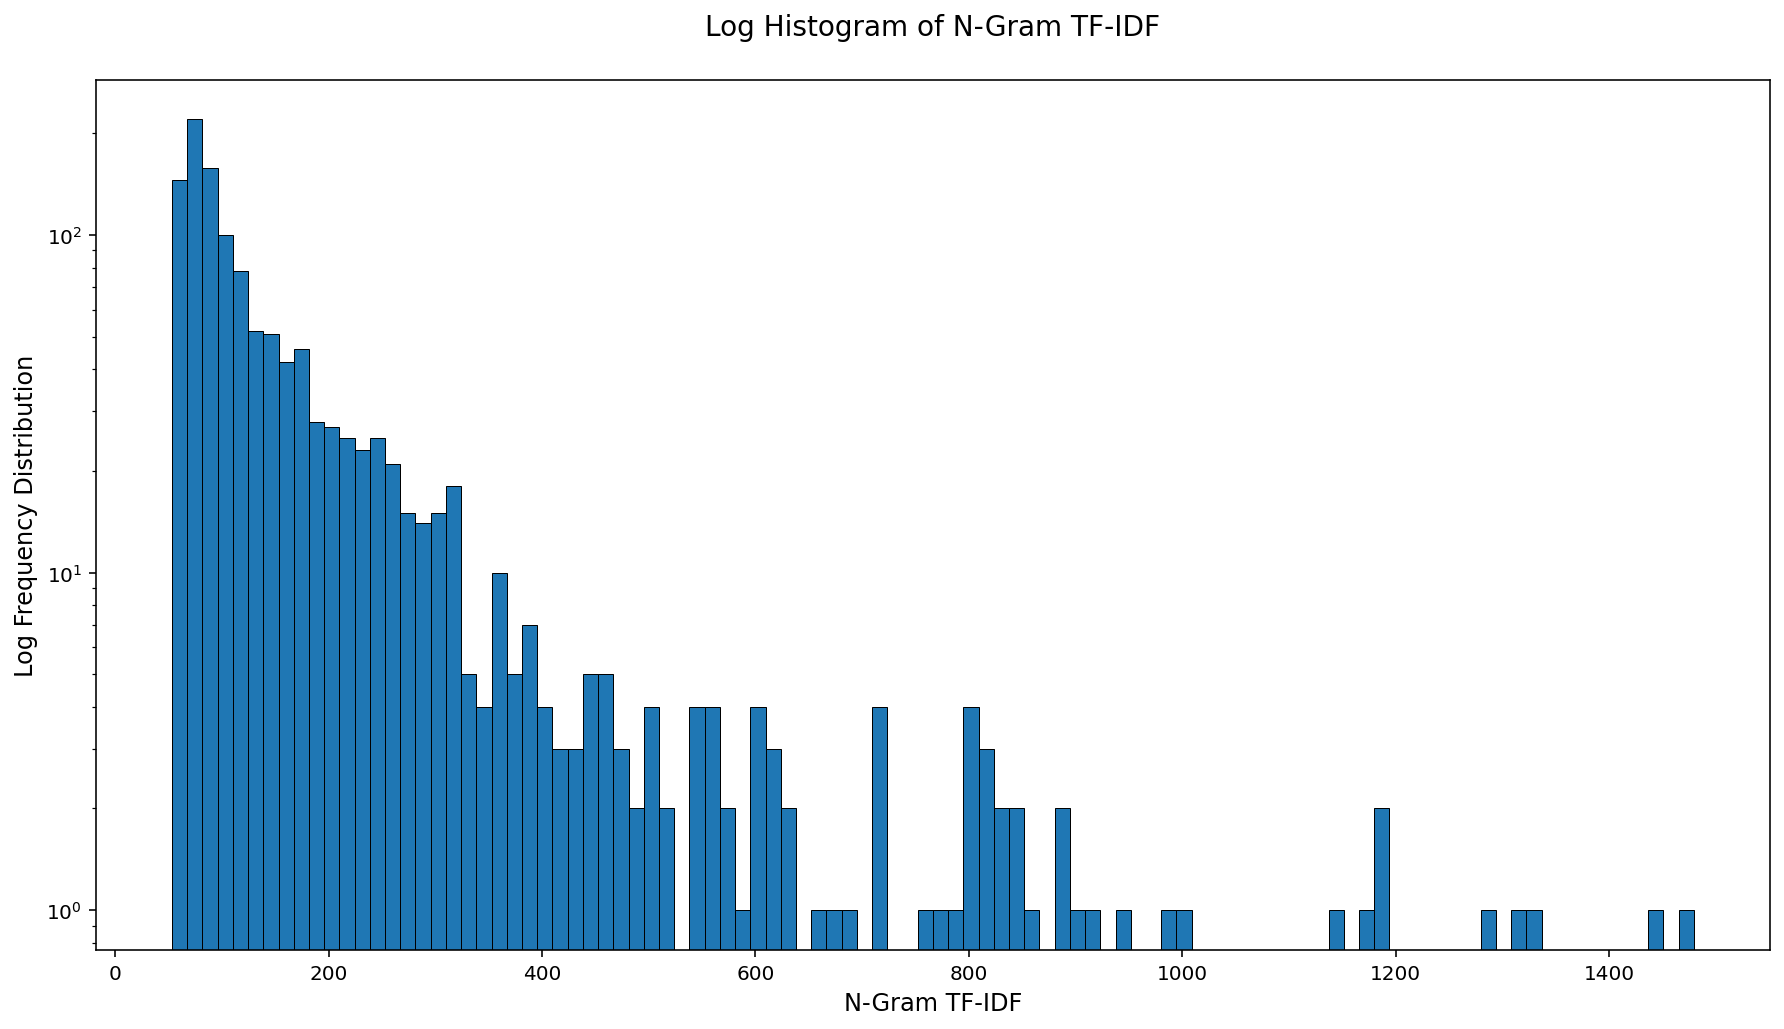

In [76]:
fig,ax = plt.subplots(figsize=(15,8))
ax.hist(review_words_sum,bins=100,edgecolor='black',lw=0.5)
ax.set_ylabel('Log Frequency Distribution',fontsize=12)
ax.set_xlabel('N-Gram TF-IDF',fontsize=12)
ax.set_title('Log Histogram of N-Gram TF-IDF\n',fontsize=14)
plt.yscale('log')
plt.show()

Comparing this to the `CountVectorizer()` histogram we can quickly see that the profile has been considerably smoothed from its previously much more starkly inverse exponential form.

We can then carry out our modelling as before to see whether scaling terms and removing very specific terms by imposing a minimum document frequency has helped our model's ability to generalise.

In [77]:
X = tfidf_df
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

sgdr_tfidf = SGDRegressor(penalty='l1',
                          max_iter=1000,
                          early_stopping=True,
                          n_iter_no_change=10)

sgdr_tfidf.fit(Xtr,ytr)
best_tfidf_cv = cross_val_score(sgdr_tfidf,Xtr,ytr,cv=5,n_jobs=-1)

# Save the SGDR NLP model using joblib
joblib.dump(sgdr_tfidf,"assets/sgdr_tfidf")
joblib.dump(best_tfidf_cv,"assets/best_tfidf_cv")

['assets/best_tfidf_cv']

In [78]:
# Reload the SGDR NLP model using joblib if necessary
# If reloading, y and X also will need to be redefined as above

X = tfidf_df
y = wine['price']

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=29)

sgdr_tfidf = joblib.load("assets/sgdr_tfidf")
best_tfidf_cv = joblib.load("assets/best_tfidf_cv")

In [79]:
print(f"All CV Scores: {best_tfidf_cv}")
print(f"Avg CV Score:  {best_tfidf_cv.mean()}")

All CV Scores: [0.19593135 0.04663949 0.24399426 0.16204355 0.20064203]
Avg CV Score:  0.1698501371098601


In [80]:
print("TF-IDF Vectorizer")
print(17*"-")
print(f"Train R2:   {sgdr_tfidf.score(Xtr,ytr)}")
print(f"Test R2:    {sgdr_tfidf.score(Xte,yte)}")
print(f"Avg CV R2:  {best_tfidf_cv.mean()}")
print(f"CV Std-Dev: {best_tfidf_cv.std()}\n")
print("Count Vectorizer")
print(16*"-")
print(f"Train R2:   {cvec_train}")
print(f"Test R2:    {cvec_test}")
print(f"Avg CV R2:  {best_nlp_cv.mean()}")
print(f"CV Std-Dev: {best_nlp_cv.std()}")

TF-IDF Vectorizer
-----------------
Train R2:   0.14188938509134308
Test R2:    0.17880985533081428
Avg CV R2:  0.1698501371098601
CV Std-Dev: 0.06688426940583309

Count Vectorizer
----------------
Train R2:   0.5682325997881472
Test R2:    0.08485462009486833
Avg CV R2:  0.15443131521736914
CV Std-Dev: 0.11083247766550638


From the results above we can see that while the training score has taken a notable hit when compared to the simple count-vectorizer methodology, the test and cross-validated scores are much more in-line with the training score implying that the model solution here is much more stable and can be better generalised.

The cross-validated scores for the TF-IDF actually outperform the simple count in terms of overall average, as well as standard deviation of values within the five K-folds.

The next area to investigate would be whether building a composite model of numerical, categorical and TF-IDF features will enable improvement on our previous model's $R^2$ score - more to come within this area soon.

### 4.3 Multiple Correspondence Analysis
Given the large number of one-hot encoded caqtegorical fields, resulting in a very high dimensional feature space, I investigated any methodologies to attempt to reduce this dimensionality while minimising any loss of information.

In a set of numerical features it would be simple enough to use a principal component analysis (PCA) decomposition of our features into a new coordinates system of a given number of eigenvectors. This would result in maximising the variance along the new axes of our feature space and a specified reduction of dimensions.

However, since practically all of the dimensions in the feature space of our wine dataset are based on categorical, one-hot encoded features, we must instead look to a different technique known as [multiple correspondence analysis](https://www.researchgate.net/publication/239542271_Multiple_Correspondence_Analysis) (MCA). In a similar principle to PCA, MCA attempts to create a new coordinates system to allow for grouping of different features, allowing for a reduction of dimensionality while maintaining as much variance from the original dataset.

#### Investigating Dimensionality Reduction
To carry out MCA on my dataset, I used the PyPI package [mca 1.0.3](https://pypi.org/project/mca/) as shown below. For the dimension decomposition, we can simply call the MCA function within the package and apply it to a Pandas DataFrame with a set tolerance level of explained inertia - a roughly analogous term to explained variance within PCA - required for each new dimension to contribute.

As a very rough baseline assumption, I assumed that should all one-hot encoded columns be equally contributing in information then simply dividing 1 by the number of categorical features should give us a starting point for the amount each new dimension should provide; if any dimension were to provide less than this tolerance level then it would not be included as a dimension in the new coordinates system.

In [1]:
# Finding a starting estimate for tolerance level to use with MCA
1/11222

8.911067545891998e-05

So we can set the tolerance level to $8.91\times10^{-5}$.

In [ ]:
# Instantiate the MCA, specify the categorical columns from the wine dataset and
# set the tolerance level as described above

pypi_mca = MCA(wine,cols=['rating','reviewer',
                          'variety','country',
                          'region_all','winery',
                          'category','vintage'],
               TOL=1e-4)

# Save the MCA model as the program takes considerable length to run, given the
# high number of dimensions
joblib.dump(pypi_mca,"pypi_mca_tol18,91e-5.jlib")

In [4]:
# Reload the file if necessary. This file is not available in the GitHub repo as
# it is incredibly large (>30GB)
pypi_mca_reload = joblib.load("/Users/jacklodge/My_Documents/capstone_data/pypi_mca_tol18,91e-5.jlib")

In [8]:
# Recover the number of original dimensions within the original dataset
pypi_mca_reload.expl_var().shape

(11222,)

In [69]:
# Calculate how many of these have been zeroed due to the inertia contribution
# falling below the tolerance level within the new coordinate system
(pypi_mca_reload.expl_var() > 8.91e-5).sum()

1135

In [70]:
# Resulting in a reduction of dimensions equal to the original number of dimensions
# minus this figure
11222-1135

10087

In [71]:
# Or in percentage terms a reduction of
print(f"{100*round(10087/11222,2)}%")

90.0%


In [72]:
# We can also plot the contributed amount of inertia within each dimension of
# the new coordinate system. These are listed in descending order.
pypi_mca_reload.expl_var()[:1135]

array([8.08489513e-03, 7.67010835e-03, 7.30275903e-03, ...,
       8.98264590e-05, 8.95042295e-05, 8.93287765e-05])

In [73]:
# Looking at the first 10 dimensions within this array can give us an idea of
# how useful the new coordinate system is at capturing the information within
# a smaller number of dimensions.
pypi_mca_reload.expl_var()[:1135][:10]

array([0.0080849 , 0.00767011, 0.00730276, 0.00703779, 0.00637748,
       0.0063167 , 0.00596123, 0.00579129, 0.00513439, 0.00505008])

Comparing these first 10 elements to our quick baseline estimate of simply 1 divided by 11,222 we can see that the new coordinate system has found some single value decomposition elements with around 100 times the information density than the naive baseline assumption, although still very small proportion of the overall inertia, or explained variance, with the first 10 elements only explaining 6.4% of the total.

In [74]:
# Summing across the explained variance of the first 10 dimensions
pypi_mca_reload.expl_var()[:1135][:10].sum()

0.064726717264962

In [75]:
# Summing all the elements in the 1,683 dimensions contributing more
# than the set tolerance level
pypi_mca_reload.expl_var()[:1135].sum()

0.6451808083609728

Summing across all of the elements show that we have managed to reduce our model from 11,222 features to a 1,683 dimensional space, which captures around 65% of the overall variance within our original dataset. We can also plot a scree plot of explained variance versus the number of dimensions included to see where any notable changes occur within the new coordinate system.

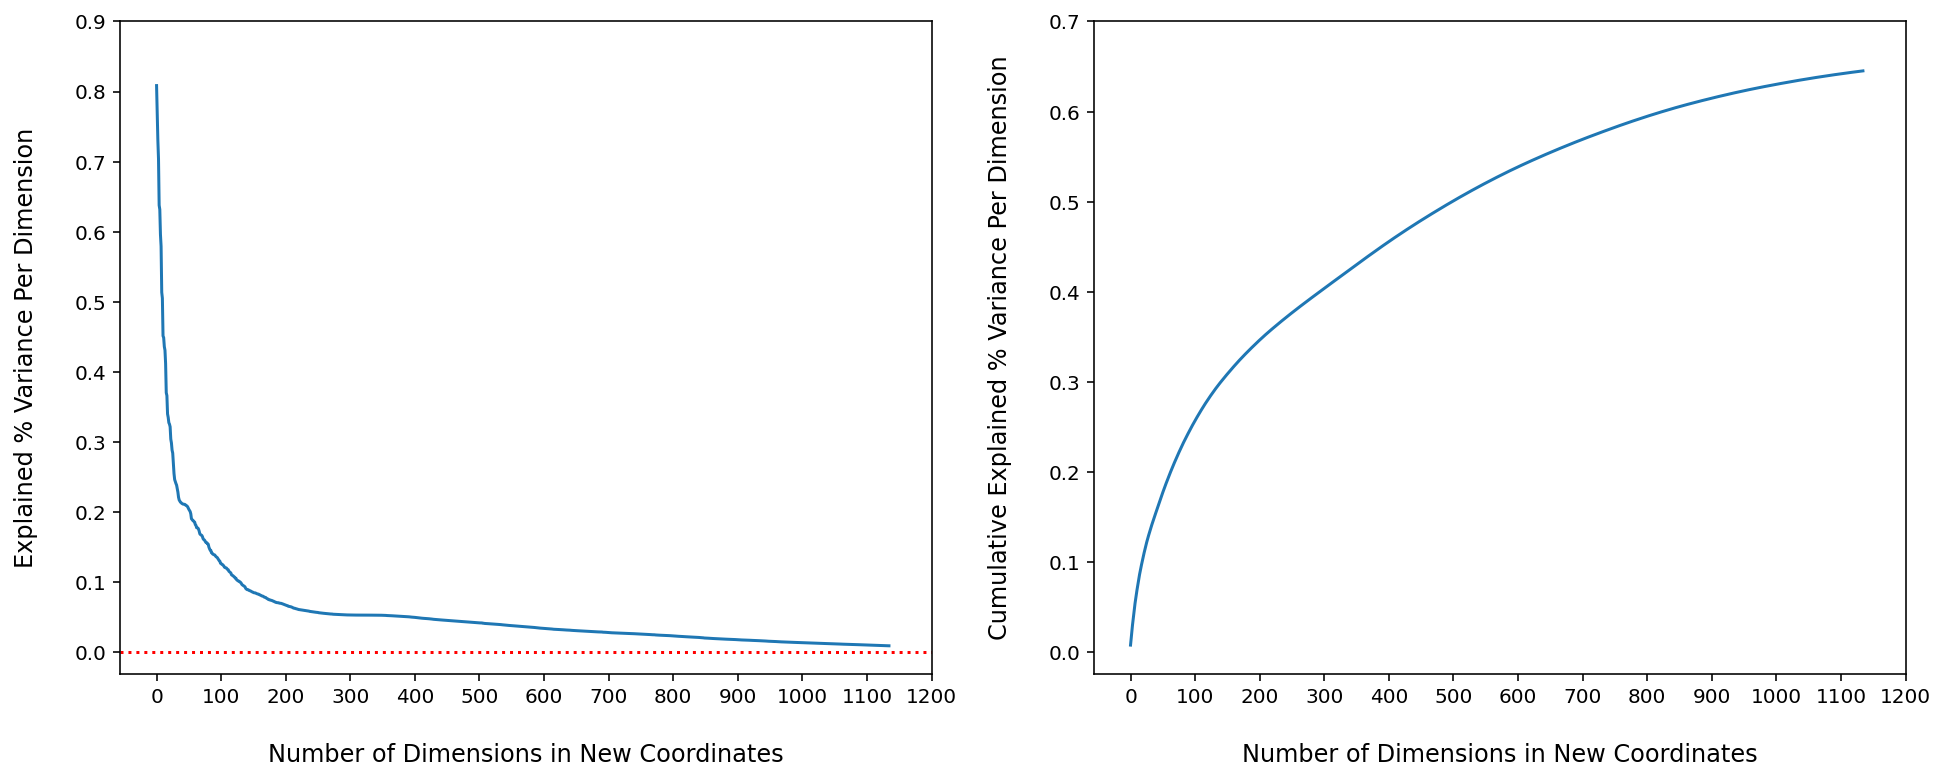

In [115]:
# Extract the explained variance array from the PyPI MCA object
expl_var = pypi_mca_reload.expl_var()[:1135]

# Instantiate a plot
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16,6))

# Plot explained variance and the reference tolerance level
ax1.plot(expl_var*100) # *100 to get percentage values
ax1.axhline(8.91e-5,c='r',linestyle=':')
ax1.set_xticks(range(0,1201,100))
ax1.set_yticks(np.arange(0,1.0,0.1))
ax1.set_ylabel("Explained % Variance Per Dimension\n",fontsize=12)
ax1.set_xlabel("\nNumber of Dimensions in New Coordinates",fontsize=12)

# Plot cumulative explained variance across dimensions contributing more
# than the set tolerance level.
ax2.plot(expl_var.cumsum())
ax2.set_xticks(range(0,1201,100))
ax2.set_yticks(np.arange(0,0.8,0.1))
ax2.set_ylabel("Cumulative Explained % Variance Per Dimension\n",fontsize=12)
ax2.set_xlabel("\nNumber of Dimensions in New Coordinates",fontsize=12)


plt.show()